# **k-seq analysis for BFO post-selection pool**

This notebook contains the analysis on Evan's k-seq data for post-selection BYO self-aminoacylation ribozymes, using `k-seq` package.

`k-seq` package [under development] provides core functions to parse, process, visualize data from k-seq experiments. It is currently implemented as a `python` package for flexible and customizable pipeline building. It will provide wrappers with standalone command line tools in [near] future release.

#### Core analysis steps: 
  - Parse and overview count files
  - Extract detected sequences
  - Fit valid sequences into kinetic model

### Requirements

To run this notebook, make sure:
  - Python 3 is install (versions to be check)
  - `k-seq` package and its dependencies are installed in your environemnt ([Installation]())
  - Count files from the experiment is obtained
  

## `k-seq` packge contents

  - `k_seq.data.pre_processing`: core module for data preprocessing before fitting, contains `SequencingSample`, `SequenceSet` and 
  - `k_seq.data.analysis`: module for preprocessing data analysis
  - `k_seq.fitting.fitting`: core module for kinetic model fitting
  - `k_seq.fitting.analysis`: module for fitting result analysis
  - `k_seq.utility`: module contains package-wide utility function

  See [documentary](https://ynshen.github.io/k-seq/) for details


## Initialization

Run the initialization cells to
- Load `k-seq` package
- Set up workspace (directory to count files and output directory)

In [450]:
import sys
# For developement: add local package directory to the top of sys.path
if sys.path[0] != '/home/yuning/Work/k-seq/src/pkg':
    sys.path = ['/home/yuning/Work/k-seq/src/pkg'] + sys.path #this should change to your path of package
    print('Local package path (/home/yuning/Work/k-seq/src/pkg) is added')

# For developement: reload k-seq package

%load_ext autoreload
%autoreload 1
%aimport k_seq
%aimport k_seq.data.io, k_seq.data.pre_processing, k_seq.data.visualizer

# Set default screen dpi for jupyter notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

from pathlib import Path

COUNT_FILES = '/mnt/storage/projects/k-seq/input/bfo_counts/counts'  # Directory to count files
WORKING_PATH = '/mnt/storage/projects/k-seq/working/bfo_evan/2019-6-28'

output_dir = Path(WORKING_PATH)
if not output_dir.exists():
    output_dir.mkdir(parents=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sequencing sample analysis
## load sample count files

In [404]:
# read counts files into sample_set
sample_set = k_seq.data.pre_processing.SeqSampleSet(
    file_root=COUNT_FILES,
    count_file_pattern='_counts.txt',
    x_values='byo',
    name_pattern='R4[{exp_rep}-{byo, float}{seq_rep}_S{id, int}]_counts.txt',
    sort_by = 'id',
    load_data=True,
    silent=True
)

NOTICE: no sample list is given, samples are collected from root folder:
R4A-0A_S7_counts.txt
	R4B-250A_S17_counts.txt
	R4B-250B_S24_counts.txt
	R4A-50A_S4_counts.txt
	R4B-2A_S20_counts.txt
	R4A-10B_S12_counts.txt
	R4B-inputA_S15_counts.txt
	R4A-inputA_S1_counts.txt
	R4A-250A_S3_counts.txt
	R4B-inputB_S22_counts.txt
	R4A-250B_S10_counts.txt
	R4B-50B_S25_counts.txt
	R4B-0A_S21_counts.txt
	R4A-50B_S11_counts.txt
	R4A-2A_S6_counts.txt
	R4B-10A_S19_counts.txt
	R4B-2B_S27_counts.txt
	R4A-inputB_S8_counts.txt
	R4A-10A_S5_counts.txt
	R4B-0B_S28_counts.txt
	R4B-1250B_S23_counts.txt
	R4B-50A_S18_counts.txt
	R4B-10B_S26_counts.txt
	R4B-1250A_S16_counts.txt
	R4A-2B_S13_counts.txt
	R4A-1250B_S9_counts.txt
	R4A-1250A_S2_counts.txt
	R4A-0B_S14_counts.txt


# Get quantification factors

In [395]:
# indicate spike-in amount to calculate quantification factors
spike_in_amounts = []
for i in range(4):
    spike_in_amounts += [4130, 1240, 826, 413, 207, 82.6, 41.3]   # Unit: fmol
    
sample_set.get_quant_factors(from_spike_in_amounts=spike_in_amounts,
                             spike_in_seq='AAAAACAAAAACAAAAACAAA',
                             max_dist=2,
                             max_dist_to_survey=10,
                             silent=False)

Survey spike-in counts for sample A-inputA_S1. Done.
Survey spike-in counts for sample A-1250A_S2. Done.
Survey spike-in counts for sample A-250A_S3. Done.
Survey spike-in counts for sample A-50A_S4. Done.
Survey spike-in counts for sample A-10A_S5. Done.
Survey spike-in counts for sample A-2A_S6. Done.
Survey spike-in counts for sample A-0A_S7. Done.
Survey spike-in counts for sample A-inputB_S8. Done.
Survey spike-in counts for sample A-1250B_S9. Done.
Survey spike-in counts for sample A-250B_S10. Done.
Survey spike-in counts for sample A-50B_S11. Done.
Survey spike-in counts for sample A-10B_S12. Done.
Survey spike-in counts for sample A-2B_S13. Done.
Survey spike-in counts for sample A-0B_S14. Done.
Survey spike-in counts for sample B-inputA_S15. Done.
Survey spike-in counts for sample B-1250A_S16. Done.
Survey spike-in counts for sample B-250A_S17. Done.
Survey spike-in counts for sample B-50A_S18. Done.
Survey spike-in counts for sample B-10A_S19. Done.
Survey spike-in counts for

In [336]:
sample_set.sample_set[0].log

Sample instance created at 2019-07-13 19:40:59.820569
Data imported at 2019-07-13 19:41:00.073541
Spike-in sequences surveyed on 2019-07-13 19:41:03.903264 with maximal distance 10
quantification factor estimated from spike seq within distance 2 at 2019-07-13 19:41:07.729973


## List sample overview

In [270]:
sample_set.sample_overview

sample type          name  total counts  unique sequences  x_value  \
0        input   A-inputA_S1       2165970            330565      NaN   
1      reacted    A-1250A_S2       2006578             29455   1250.0   
2      reacted     A-250A_S3       1845900             23911    250.0   
3      reacted      A-50A_S4       2617260             43687     50.0   
4      reacted      A-10A_S5       1515552             26410     10.0   
5      reacted       A-2A_S6       1580503             24362      2.0   
6      reacted       A-0A_S7       2948173              2825      0.0   
7        input   A-inputB_S8       1257100            174225      NaN   
8      reacted    A-1250B_S9       3451114             42691   1250.0   
9      reacted    A-250B_S10      10273787            120423    250.0   
10     reacted     A-50B_S11       2544354             56718     50.0   
11     reacted     A-10B_S12       2401143             65885     10.0   
12     reacted      A-2B_S13       1913930             41178      2.0   
13     reacted      A-0B_S14       2545559              2201      0.0   
14       input  B-inputA_S15       2546171            491652      NaN   
15     reacted   B-1250A_S16       1616904             27376   1250.0   
16     reacted    B-250A_S17       3186048             43505    250.0   
17     reacted     B-50A_S18       3661612             67469     50.0   
18     reacted     B-10A_S19       3801335             67576     10.0   
19     reacted      B-2A_S20       2569754             30430      2.0   
20     reacted      B-0A_S21       1971971              1861      0.0   
21       input  B-inputB_S22       2340997            496360      NaN   
22     reacted   B-1250B_S23       3102130             47268   1250.0   
23     reacted    B-250B_S24       3230772             37131    250.0   
24     reacted     B-50B_S25       2878311             54080     50.0   
25     reacted     B-10B_S26       2101362             38602     10.0   
26     reacted      B-2B_S27       2562117             42324      2.0   
27     reacted      B-0B_S28       2204073             19959      0.0   

    spike-in amount  spike-in counts (dist=2)  spike-in percent  \
0            4130.0                    416438          0.192264   
1            1240.0                    322730          0.160836   
2             826.0                    267257          0.144784   
3             413.0                    453121          0.173128   
4             207.0                    351337          0.231821   
5              82.6                    460933          0.291637   
6              41.3                   2839946          0.963290   
7            4130.0                    304332          0.242091   
8            1240.0                    601219          0.174210   
9             826.0                   1312643          0.127766   
10            413.0                    329774          0.129610   
11            207.0                    354022          0.147439   
12             82.6                    398710          0.208320   
13             41.3                   2462237          0.967268   
14           4130.0                    731109          0.287141   
15           1240.0                    286251          0.177036   
16            826.0                    424314          0.133179   
17            413.0                    571166          0.155988   
18            207.0                    798440          0.210042   
19             82.6                    830313          0.323110   
20             41.3                   1910791          0.968975   
21           4130.0                    479406          0.204787   
22           1240.0                    536628          0.172987   
23            826.0                    435436          0.134778   
24            413.0                    487128          0.169241   
25            207.0                    488872          0.232645   
26             82.6                    794099          0.309939   
27       

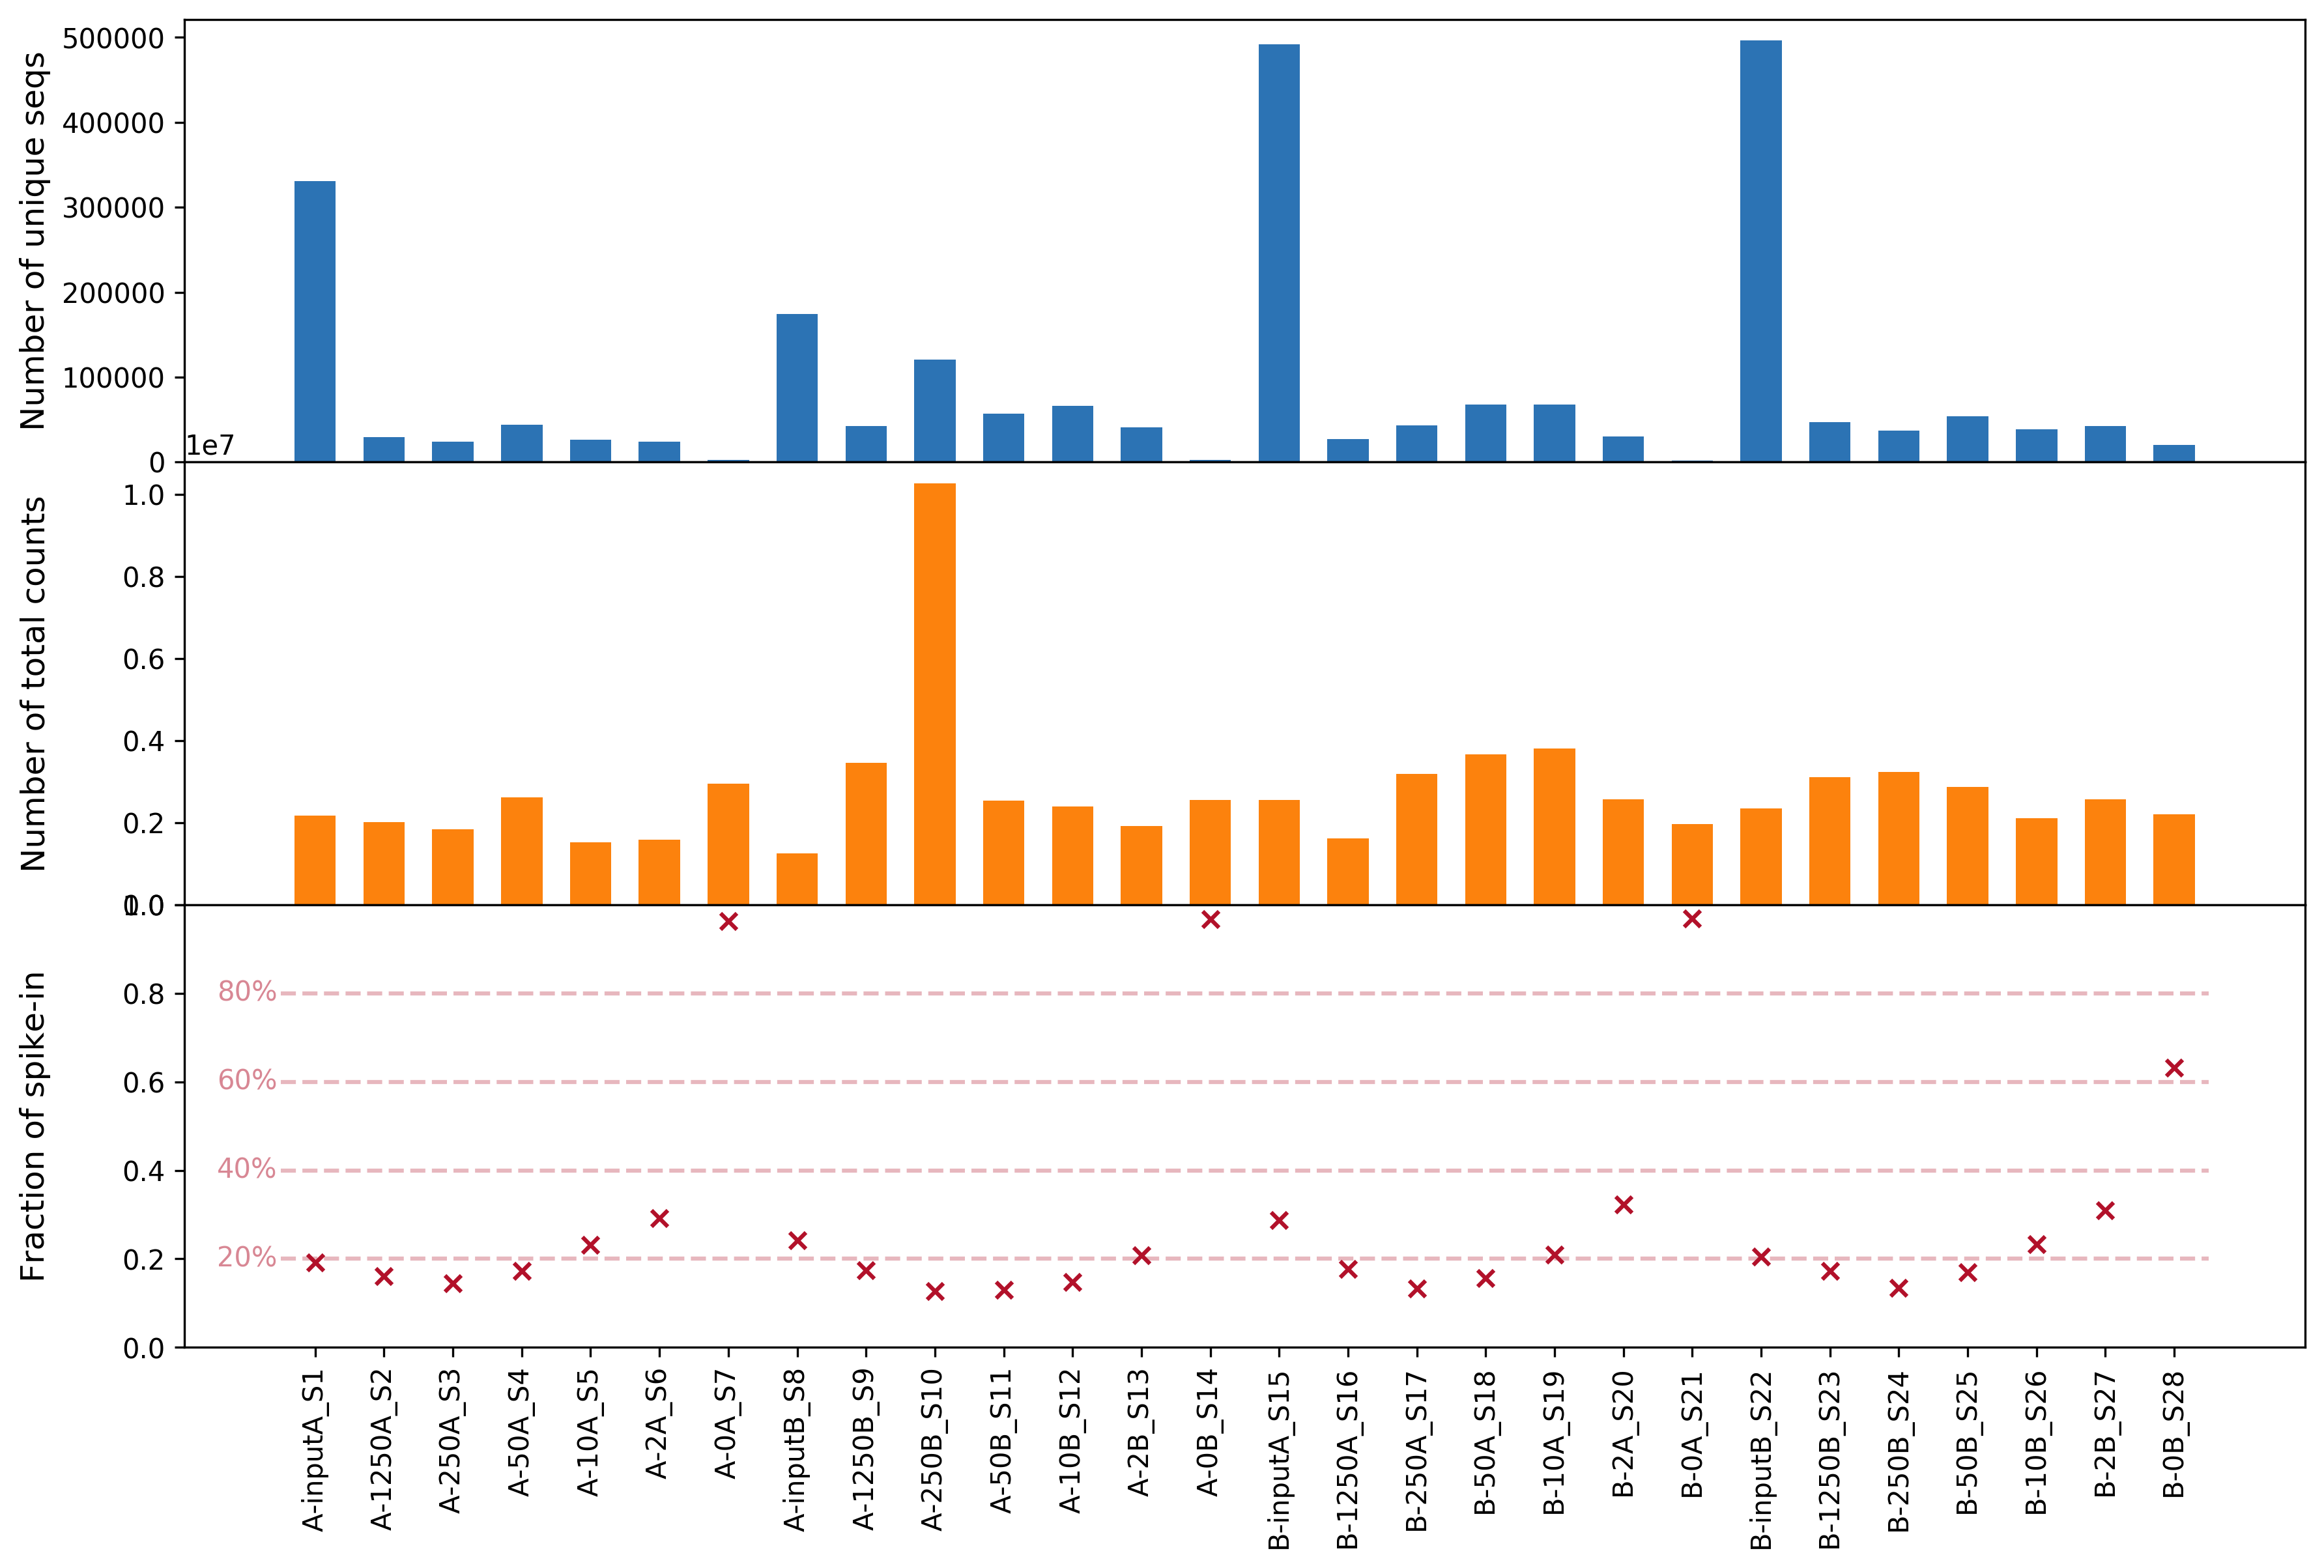

In [119]:
k_seq.data.visualizer.count_file_info_plot(sample_set=sample_set,
                                           plot_total_counts=True,
                                           plot_unique_seq=True,
                                           plot_spike_in_frac=True,
                                           sep_plot=True)

## Distribution of spike-in peak

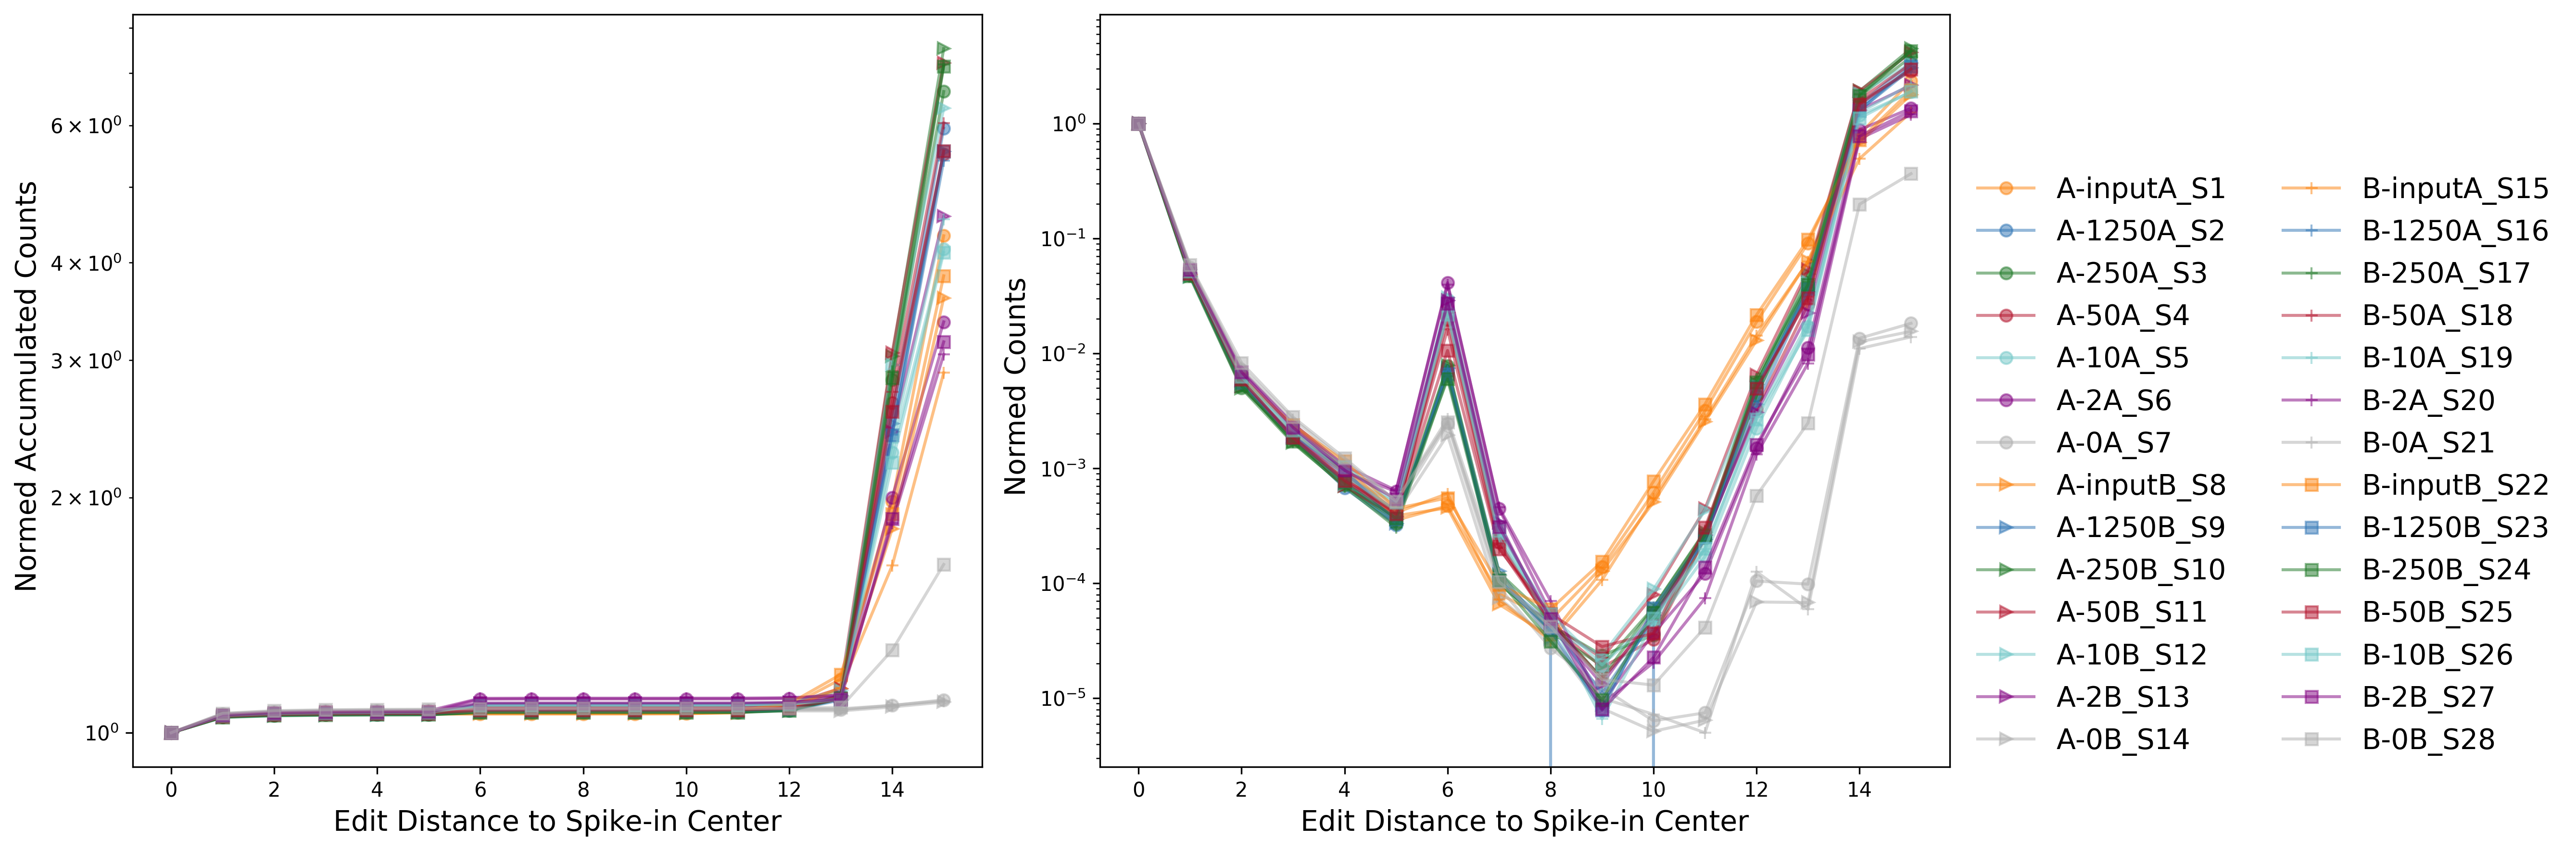

In [171]:
import numpy as np

# Manual marker/color list for each reps
marker_list = np.repeat(['-o', '->', '-+', '-s'], 7)
color_list = np.tile(['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE'], reps=4).reshape([28])

# create a master figure side by side
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=[18, 6])
# add left figure as accumulated
k_seq.data.visualizer.spike_in_peak_plot(sample_set, accumulate=True, max_dist=15, norm_on_center=True,
                                         color_list=color_list, marker_list=marker_list,
                                         legend_off=True,  ax=axes[0])
# add right figure as average peak shape, with legend
k_seq.data.visualizer.spike_in_peak_plot(sample_set, max_dist=15, norm_on_center=True,log_y=True,
                                         color_list=color_list, marker_list=marker_list,
                                         legend_off=False,  ax=axes[1])
plt.show()

## Repeatability at sample level

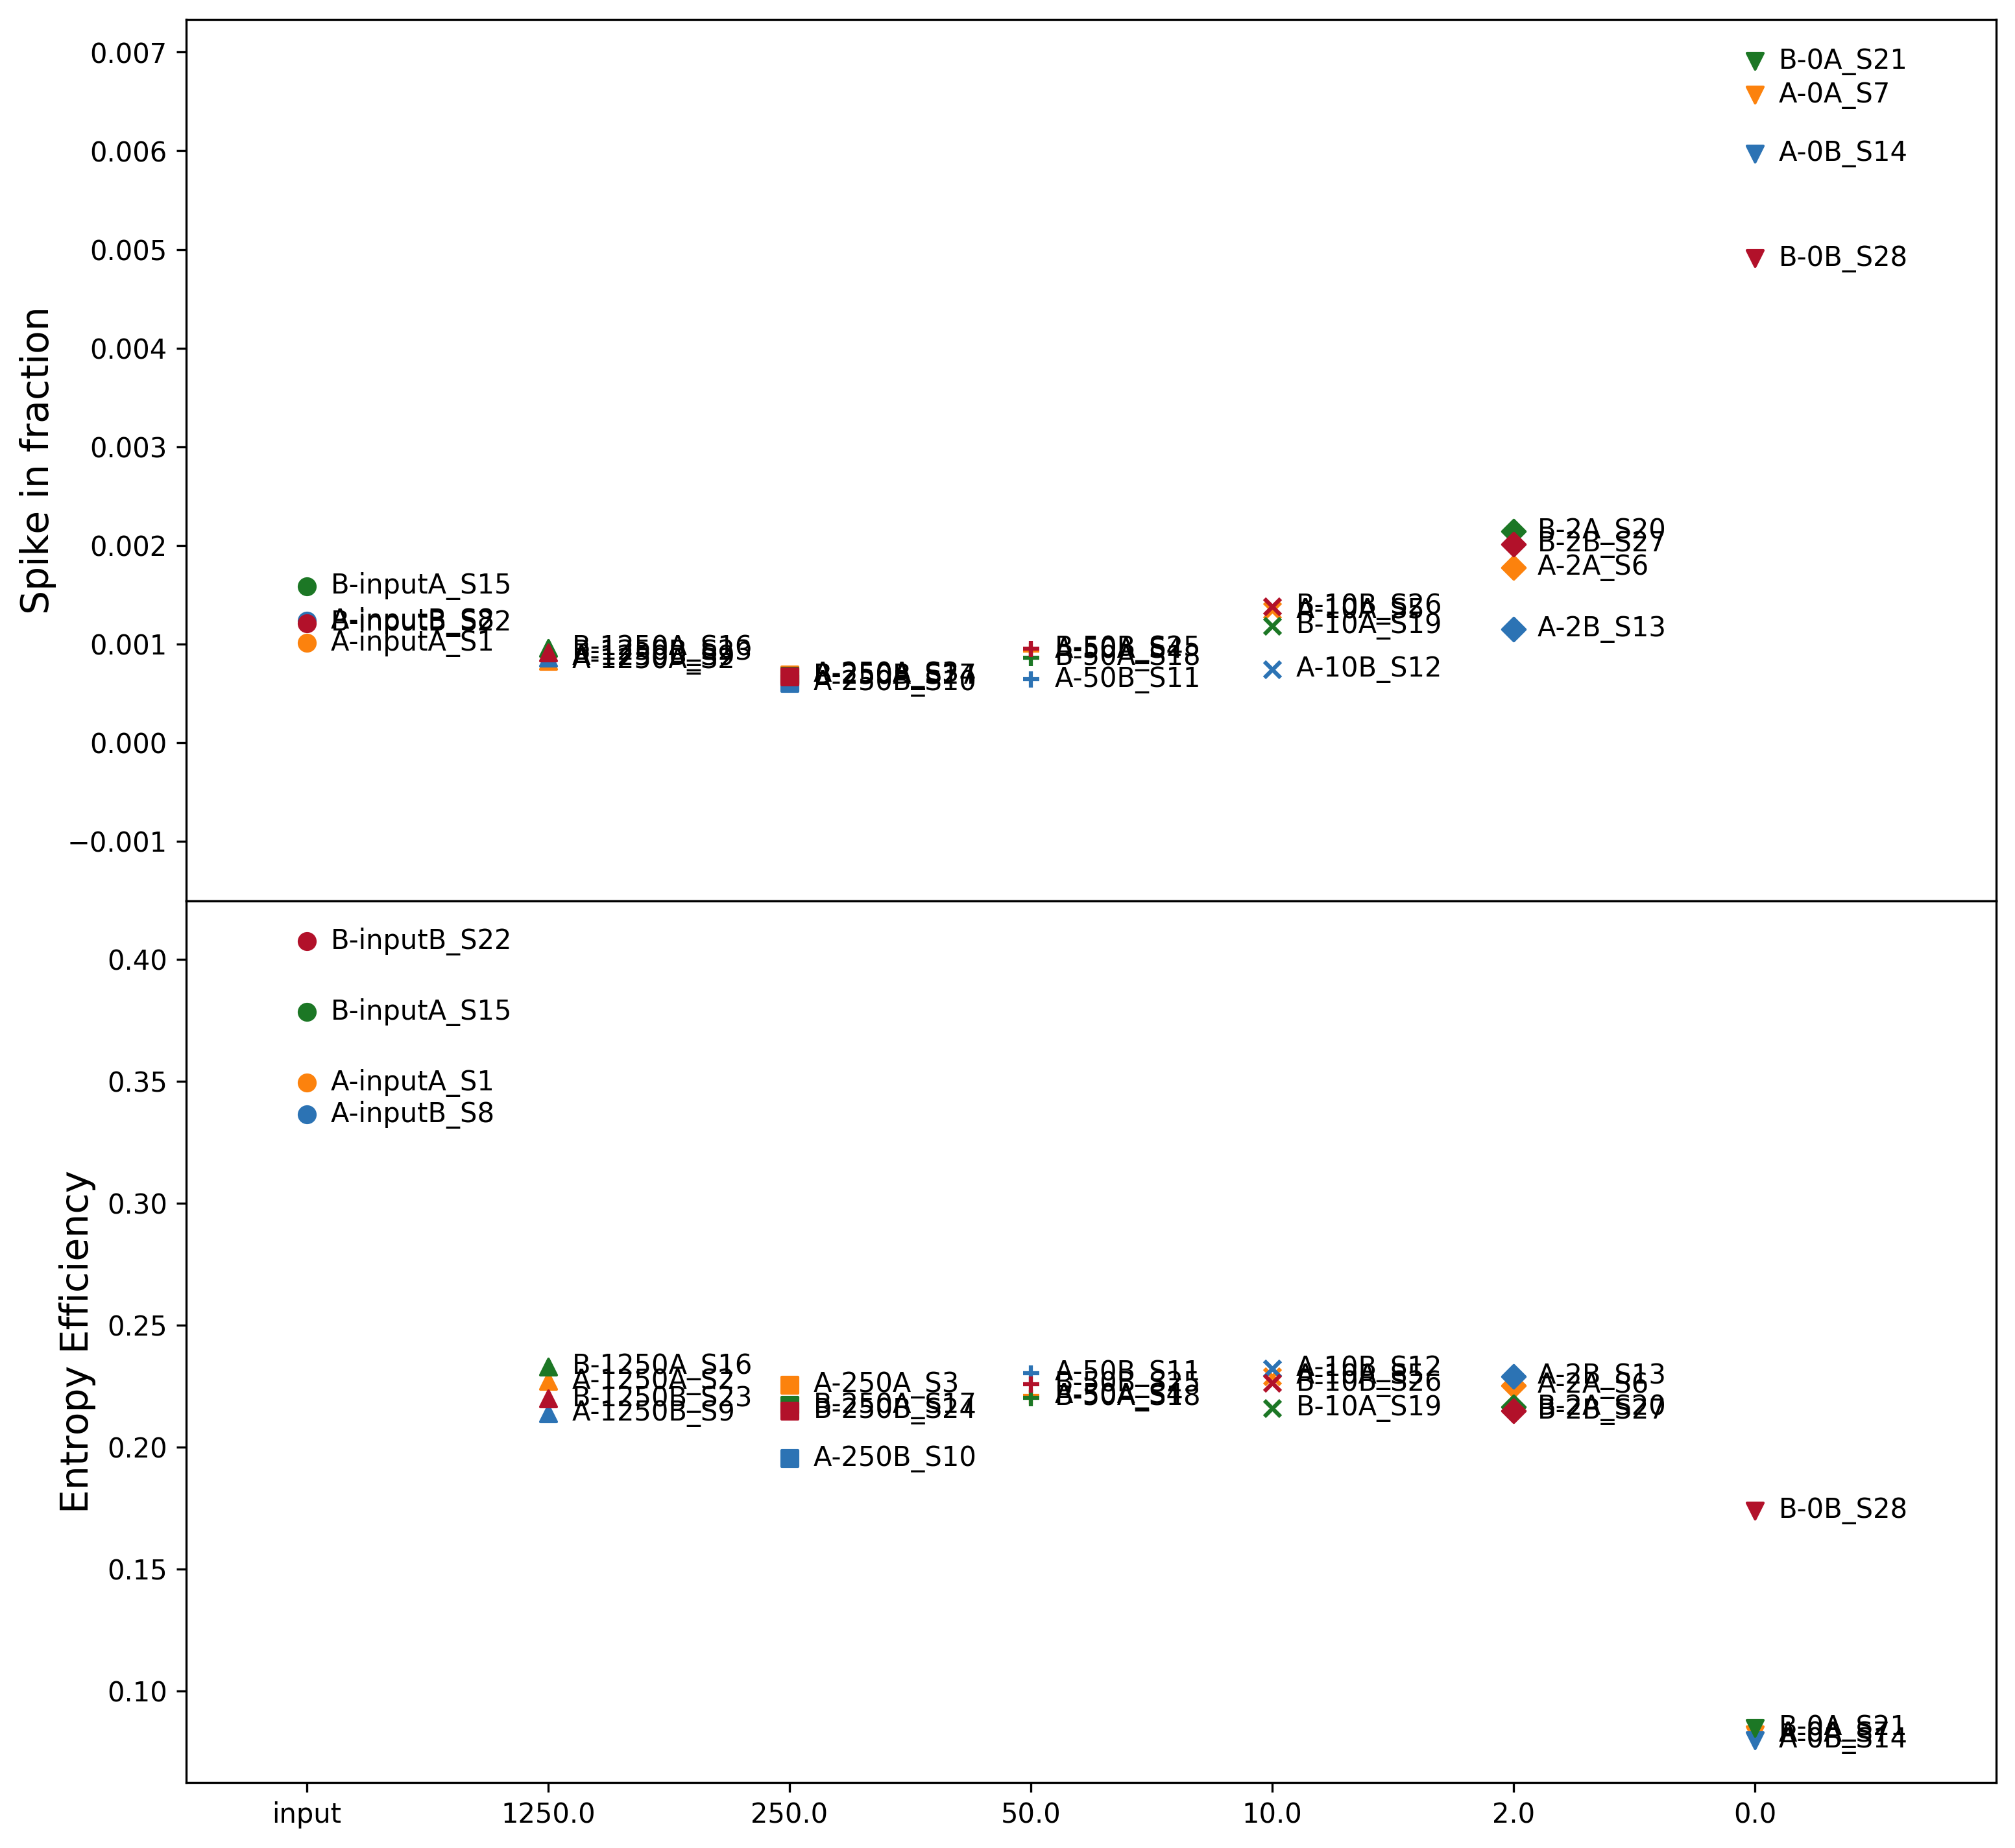

In [216]:
k_seq.data.visualizer.rep_spike_in_plot(sample_set=sample_set, group_by='byo')

## Distribution of sequence lengths

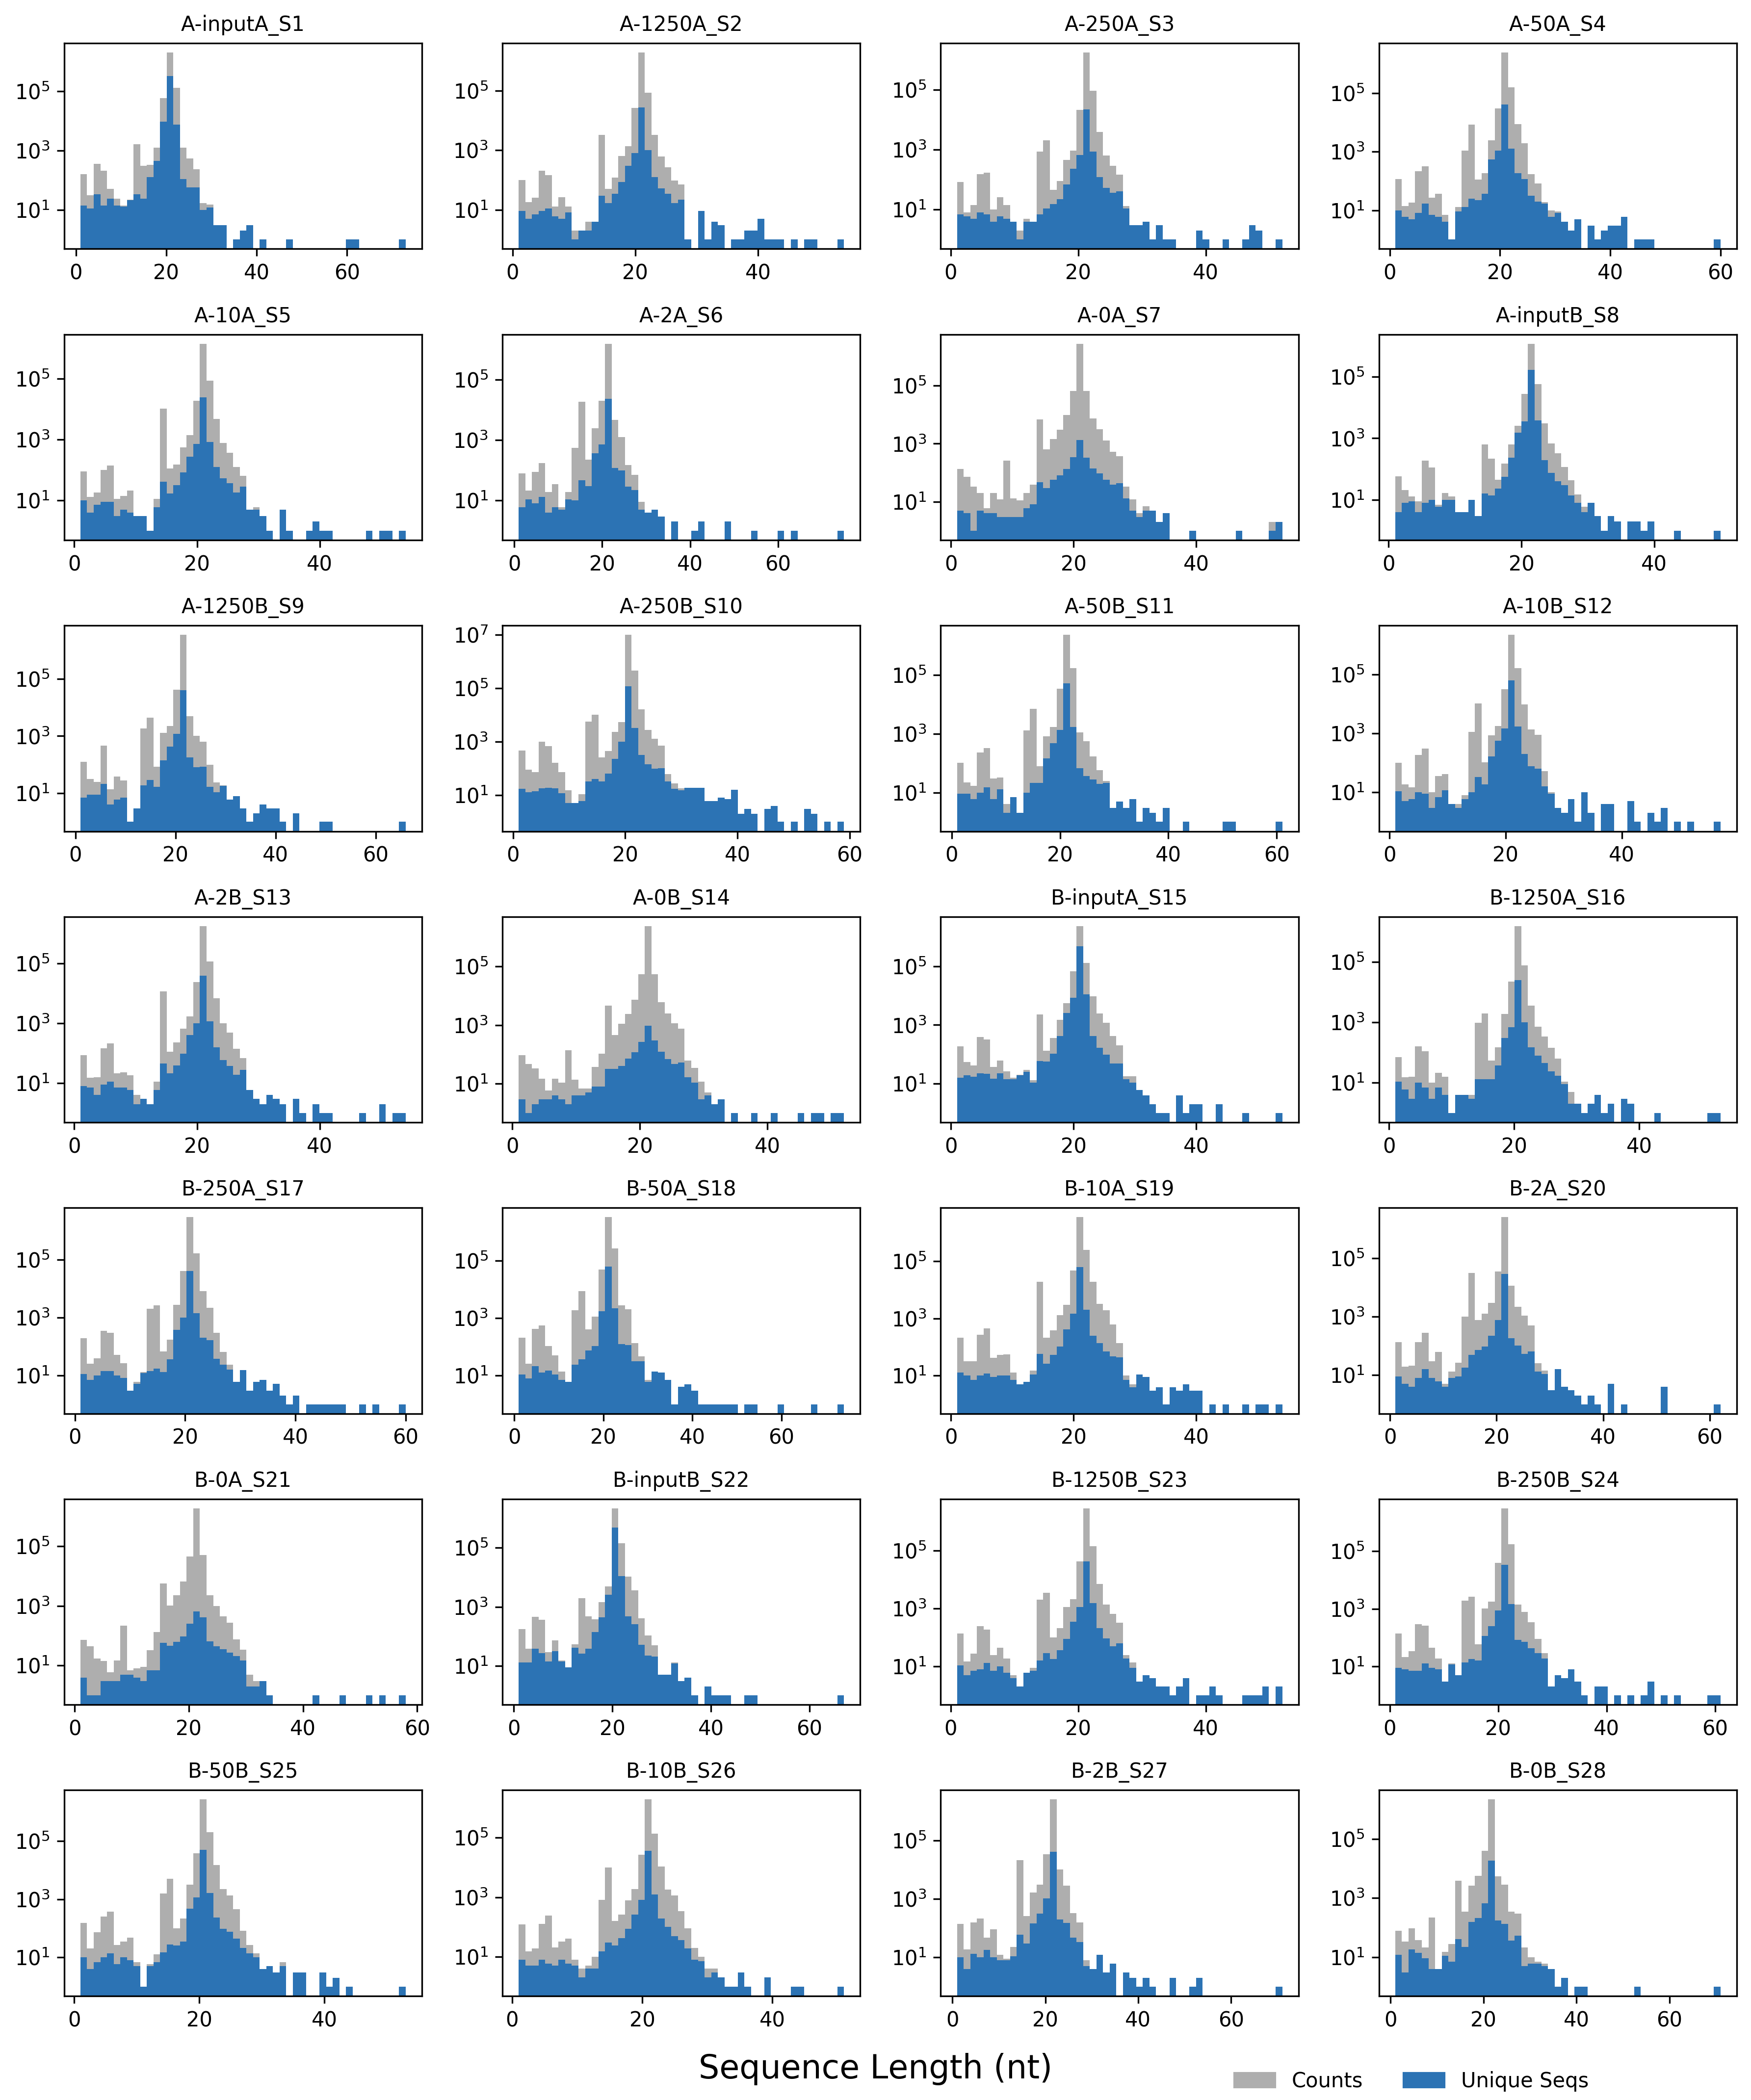

In [241]:
k_seq.data.visualizer.length_dist_plot_all(sample_set=sample_set)

## Sample thresholding test

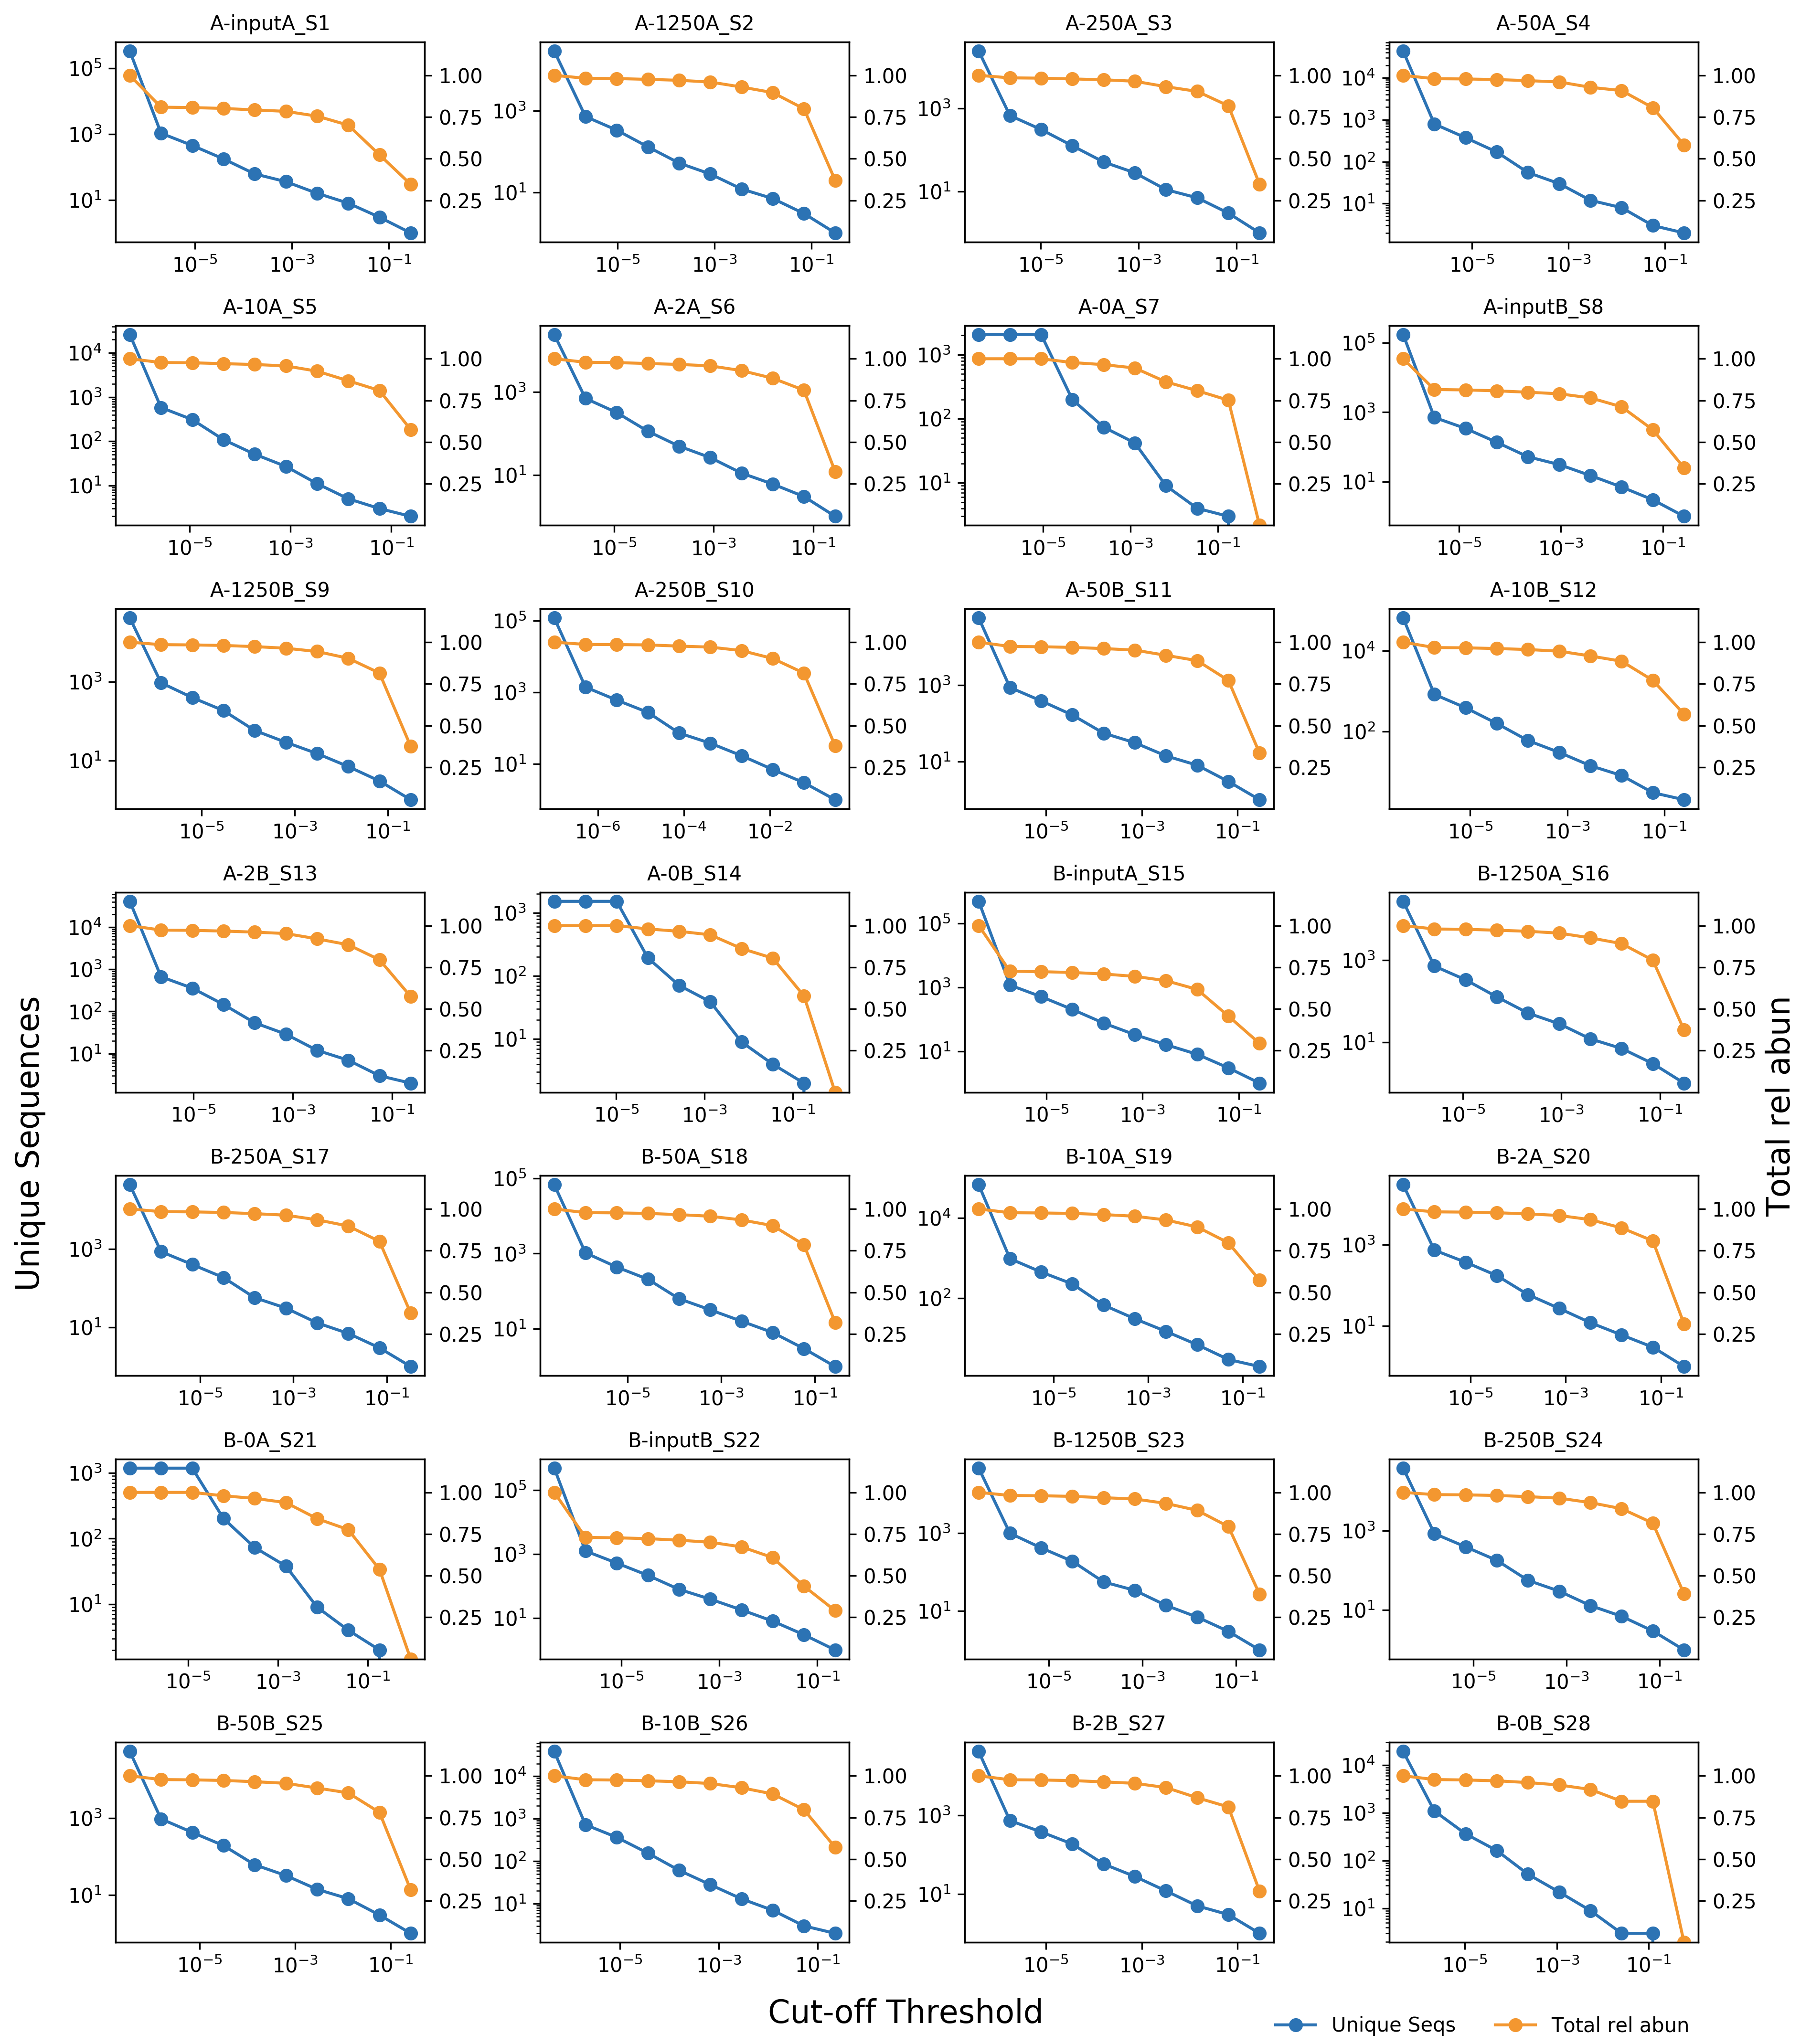

In [312]:
k_seq.data.visualizer.sample_count_cut_off_plot_all(sample_set)

In [405]:
input_set = sample_set.get_sample(sample_id=lambda sample: sample.sample_type == 'input')
reacted_set = sample_set.get_sample(sample_id=lambda sample: sample.sample_type == 'reacted')
valid_set = set(input_set.index) & set(reacted_set.index)

In [431]:
df.divide(df.median(axis=1), axis=0)

A-inputA_S1  A-inputB_S8  B-inputA_S15  \
AAAAACAAAAACAAATACAAA          0.927536     0.608696      1.420290   
ATAAACAAAAAACAAAAACAAA         1.000000          NaN           NaN   
CCGCTTCAAACAATCGGTACTG              NaN          NaN      0.500000   
TCATCCGGACCCGCAACGTGA               NaN          NaN      1.000000   
AAAACCCTGGTCATCGAGTGA          1.200000     0.800000      0.800000   
ATTCACCTAGGTCATCGGATGT         0.933333     0.400000      1.066667   
CTGTTTCAAACAATCGATCGC          1.000000          NaN      1.000000   
CACTTCAAACAATCGGTC             0.666667          NaN      1.333333   
CATTCGCACTTCAATAATCGG          1.000000          NaN           NaN   
CTACTTCAATTAATCGGTTGC          1.000000          NaN           NaN   
CTCCTTCAATAATCGGTCCGC               NaN          NaN           NaN   
CCACTTCAATAATCGGCTGCG               NaN          NaN      0.666667   
CTCTACTTCAAGCAATCGGTC          0.858934     0.382445      1.178683   
TGGTTTCATTGCCGAACGTGA          1.000000          NaN           NaN   
GGCCCCCCTTCAATAATCGGT               NaN          NaN      1.000000   
AAGAAAACAAAAACAAAAACAAA             NaN     1.000000           NaN   
GGGTCGGTCGCATTCCTGTGT          1.000000          NaN           NaN   
ACTTCAAACAATCGGCCTG            1.000000          NaN           NaN   
AAAAAAACAAAAGCAAAAACAAA             NaN     1.000000           NaN   
CTACTTCAAATAATCGGCTGC               NaN     1.000000           NaN   
ATTACCCTGGTCATCGAGTGAG         0.666667     0.666667      1.333333   
GTTCAGGTGCCATTCCGGTGA               NaN          NaN      1.000000   
CA                             1.000000          NaN      0.500000   
AAAAACAAAAAAAACAAAAACAAA       0.849315     0.589041      1.876712   
CTGTTTCAAACAATCGGCTGC          1.000000     0.200000      1.000000   
TTTGTGGTACCGTCCCCGTGA               NaN          NaN      1.000000   
CTGCCACTTCAAACAATCGGT          0.789116     0.353741      1.210884   
GGACACCACCCCGACTTGTGA               NaN          NaN      1.000000   
CAAAACAAAACAAAAACAAA           1.000000          NaN           NaN   
AACAAAAAAAAAACAAA              1.000000          NaN           NaN   
...                                 ...          ...           ...   
CCACCTTCAATAATCGGCGCA               NaN          NaN           NaN   
ATTCACCTAGGTCATCGGGTGTTCAT          NaN          NaN      1.000000   
AAAACAAA                            NaN          NaN      1.000000   
CGTTGTATTGTCCGCCCGTGA               NaN          NaN           NaN   
TCCCTTCAACAATCGGTCTGG               NaN          NaN      1.000000   
AAAAAAAACAAAAACAAAAACAAA       0.792402     0.648575      1.861601   
CCGTGCCTTCAAACAATCGGTCTG       1.000000          NaN           NaN   
ATTCACCGAGGTCATCGAGTGA              NaN          NaN           NaN   
CCAGACTTCAAGCAATCGGTC          1.000000          NaN      1.000000   
ACTTCAACCAATCGGTCTTGC          1.000000     1.000000      1.000000   
CCTGCTATCAAACAATCGGTC          1.000000          NaN           NaN   
CCACGCTTCAAGCAATCGGTCC              NaN          NaN           NaN   
ATCTCGCTTCAACCAATCGGT          1.125000     0.500000      1.250000   
TTCAAACAATCGGTCTGCCGC          0.500000          NaN      2.500000   
GGGACCTGATCGCCACAGTGA               NaN          NaN           NaN   
CTGTTTCAATAATCGCCTGCG          0.666667          NaN      1.333333   
ATCCACCTAGGTCATCGGGTG          1.655172     0.896552      1.103448   
ATAGCCCGTCCTATCAGTTGA               NaN     1.000000           NaN   
ACCCACTTCAAACAATCAGTC          0.750000     0.750000      1.750000   
CATTCCAAAACGTGCGGTGAA               NaN          NaN           NaN   
CTACTTCAGACAATCGGTCTC               NaN     1.000000      1.000000   
GTTCCACTGCAAGCTATGTGA               NaN          NaN      1.000000   
CTCGGGCTTCAAGCAATCGGT          1.000000          NaN           NaN   
ATTACCATGGTCATCGAGTAA          1.000000          NaN           NaN   
CTCCCTCAAACAATCGGTCTG               NaN          NaN      1.000000   
AAAAAGAAAAACAAAAACAAA          0.90909

In [385]:
df.loc['CTACTTCAAACAATCGGTCTG']

A-1250A_S2      624126.0
A-250A_S3       546971.0
A-50A_S4        650718.0
A-10A_S5        303851.0
A-2A_S6         281969.0
A-0A_S7          23699.0
A-1250B_S9     1069139.0
A-250B_S10     3391792.0
A-50B_S11       739631.0
A-10B_S12       609722.0
A-2B_S13        411664.0
A-0B_S14         14626.0
B-1250A_S16     497181.0
B-250A_S17     1036256.0
B-50A_S18       988301.0
B-10A_S19       856067.0
B-2A_S20        452499.0
B-0A_S21         10047.0
B-1250B_S23     998197.0
B-250B_S24     1092010.0
B-50B_S25       755244.0
B-10B_S26       444605.0
B-2B_S27        494326.0
B-0B_S28        276180.0
Name: CTACTTCAAACAATCGGTCTG, dtype: float64

In [359]:
sample.sequences[['counts']].rename({'counts': sample.name}, axis=1)

A-0A_S7
AAAAACAAAAACAAAAACAAA              2670604
ATTACCCTGGTCATCGAGTGA                35141
AAAACAAAAACAAAAACAAA                 26557
AAAAAACAAAAACAAAAACAAA               26485
CTACTTCAAACAATCGGTCTG                23699
ATTACCCTGGTCATCGAGTGT                22473
AAAAACAAAACAAAAACAAA                 15490
AAAAACAAAAAACAAAAACAAA               15078
AAAAACAAAAACAAAAAACAAA               14893
AAAAACAAAAACAAAACAAA                 12754
AAAAACAAAAACAAA                       6183
AAAAACAAAAACAAAAACAA                  5512
AAAAAAACAAAAACAAAAACAAA               4509
AAACAAAAACAAAAACAAA                   2753
CAAAAACAAAAACAAAAACAAA                2198
AAAAAAAACAAAAACAAAAACAAA              2098
AAAAACAAAAACAAAAACAAT                 1669
AAAAACAAAAAAAAAACAAA                  1591
AAAAACAAACAAAAACAAA                   1561
AAAAACAAAAACAAACAAA                   1294
AAAAAAAAAACAAAAACAAA                  1180
ATTCACCTAGGTCATCGGGTG                 1022
AAAAACAAAAACAAAAAAACAAA               1015
AAAAACAAAAAAACAAAAACAAA                952
GAAAACAAAAACAAAAACAAA                  945
AAAAACAAAAACAAAAAAAA                   942
AACAAAAACAAAAACAAA                     919
AAAAAAAAACAAAAACAAAAACAAA              869
ATTCACCTAGGTCATCGGGTGT                 803
AAAAACCAAAAACAAAAACAAA                 778
...                                    ...
AAAAAAAAAACAAAAACAAAA                    1
AAAAAAAAAACAAAAAACAAAAAAACAAA            1
AAAAAAAAAACAAAAAAAACAAA                  1
AAAAAAAAAAACCAAAAACAAA                   1
AAAAAAAAAAACACAAACAAAAACAAAAACAAA        1
AAAAAAAAAAACAAGAACAAA                    1
AAAAAAAAAAACAAACAAA                      1
AAAAAAAAAAACAAAACAAAAACAAA               1
AAAAAAAAAAACAAAAACAAT                    1
AAAAAAAAAAACAAAAACAAC                    1
AAAAAAAAAAACAAAAACAAAATCAAA              1
AAAAAAAAAAACAAAAACAAAAACA                1
AAAAAAAAAAACAAAAAACAAAAACAAA             1
AAAAAAAAAAACAAAAAAAACAAA                 1
AAAAAAAAAAACAAAAAAAAA                    1
AAAAAAAAAAACAAAAAAAA                     1
AAAAAAAAAAACAAA                          1
AAAAAAAAAAAACAAAAACCAAAACAAA             1
AAAAAAAAAAAACAAAAACAAAAAACAAA            1
AAAAAAAAAAAACAAAAACAA                    1
AAAAAAAAAAAACAAAAAACAAA                  1
AAAAAAAAAAAACAAA                         1
AAAAAAAAAAAAACAAAACAAA                   1
AAAAAAAAAAAAACAAAA                       1
AAAAAAAAAAAAAAACAAAACAAA                 1
AAAAAAAAAAAAAAACAAAAACAAA                1
AAAAAAAAAAAAAAAACAAAAACAAA               1
AAAAAAAAAAAAAAAAACAAAAACAAAAACAAA        1
AAAAAAAAA                                1
AAAAAAAA                                 1

[2825 rows x 1 columns]

# Valid sequences analysis
## Convert valid sequences to ```sequence_set```

In [408]:
sequence_set = pre_processing.SequenceSet(sample_set=sample_set, remove_spike_in=True, note='test')

NameError: name 'pre_processing' is not defined

In [550]:
zero_samples = [sample_name for sample_name in sequence_set.sample_info.keys() if '-0' in sample_name]
sequence_set.get_reacted_frac(
    input_average='median',
    black_list=zero_samples,
    inplace=True
)

## Valid sequence characterization

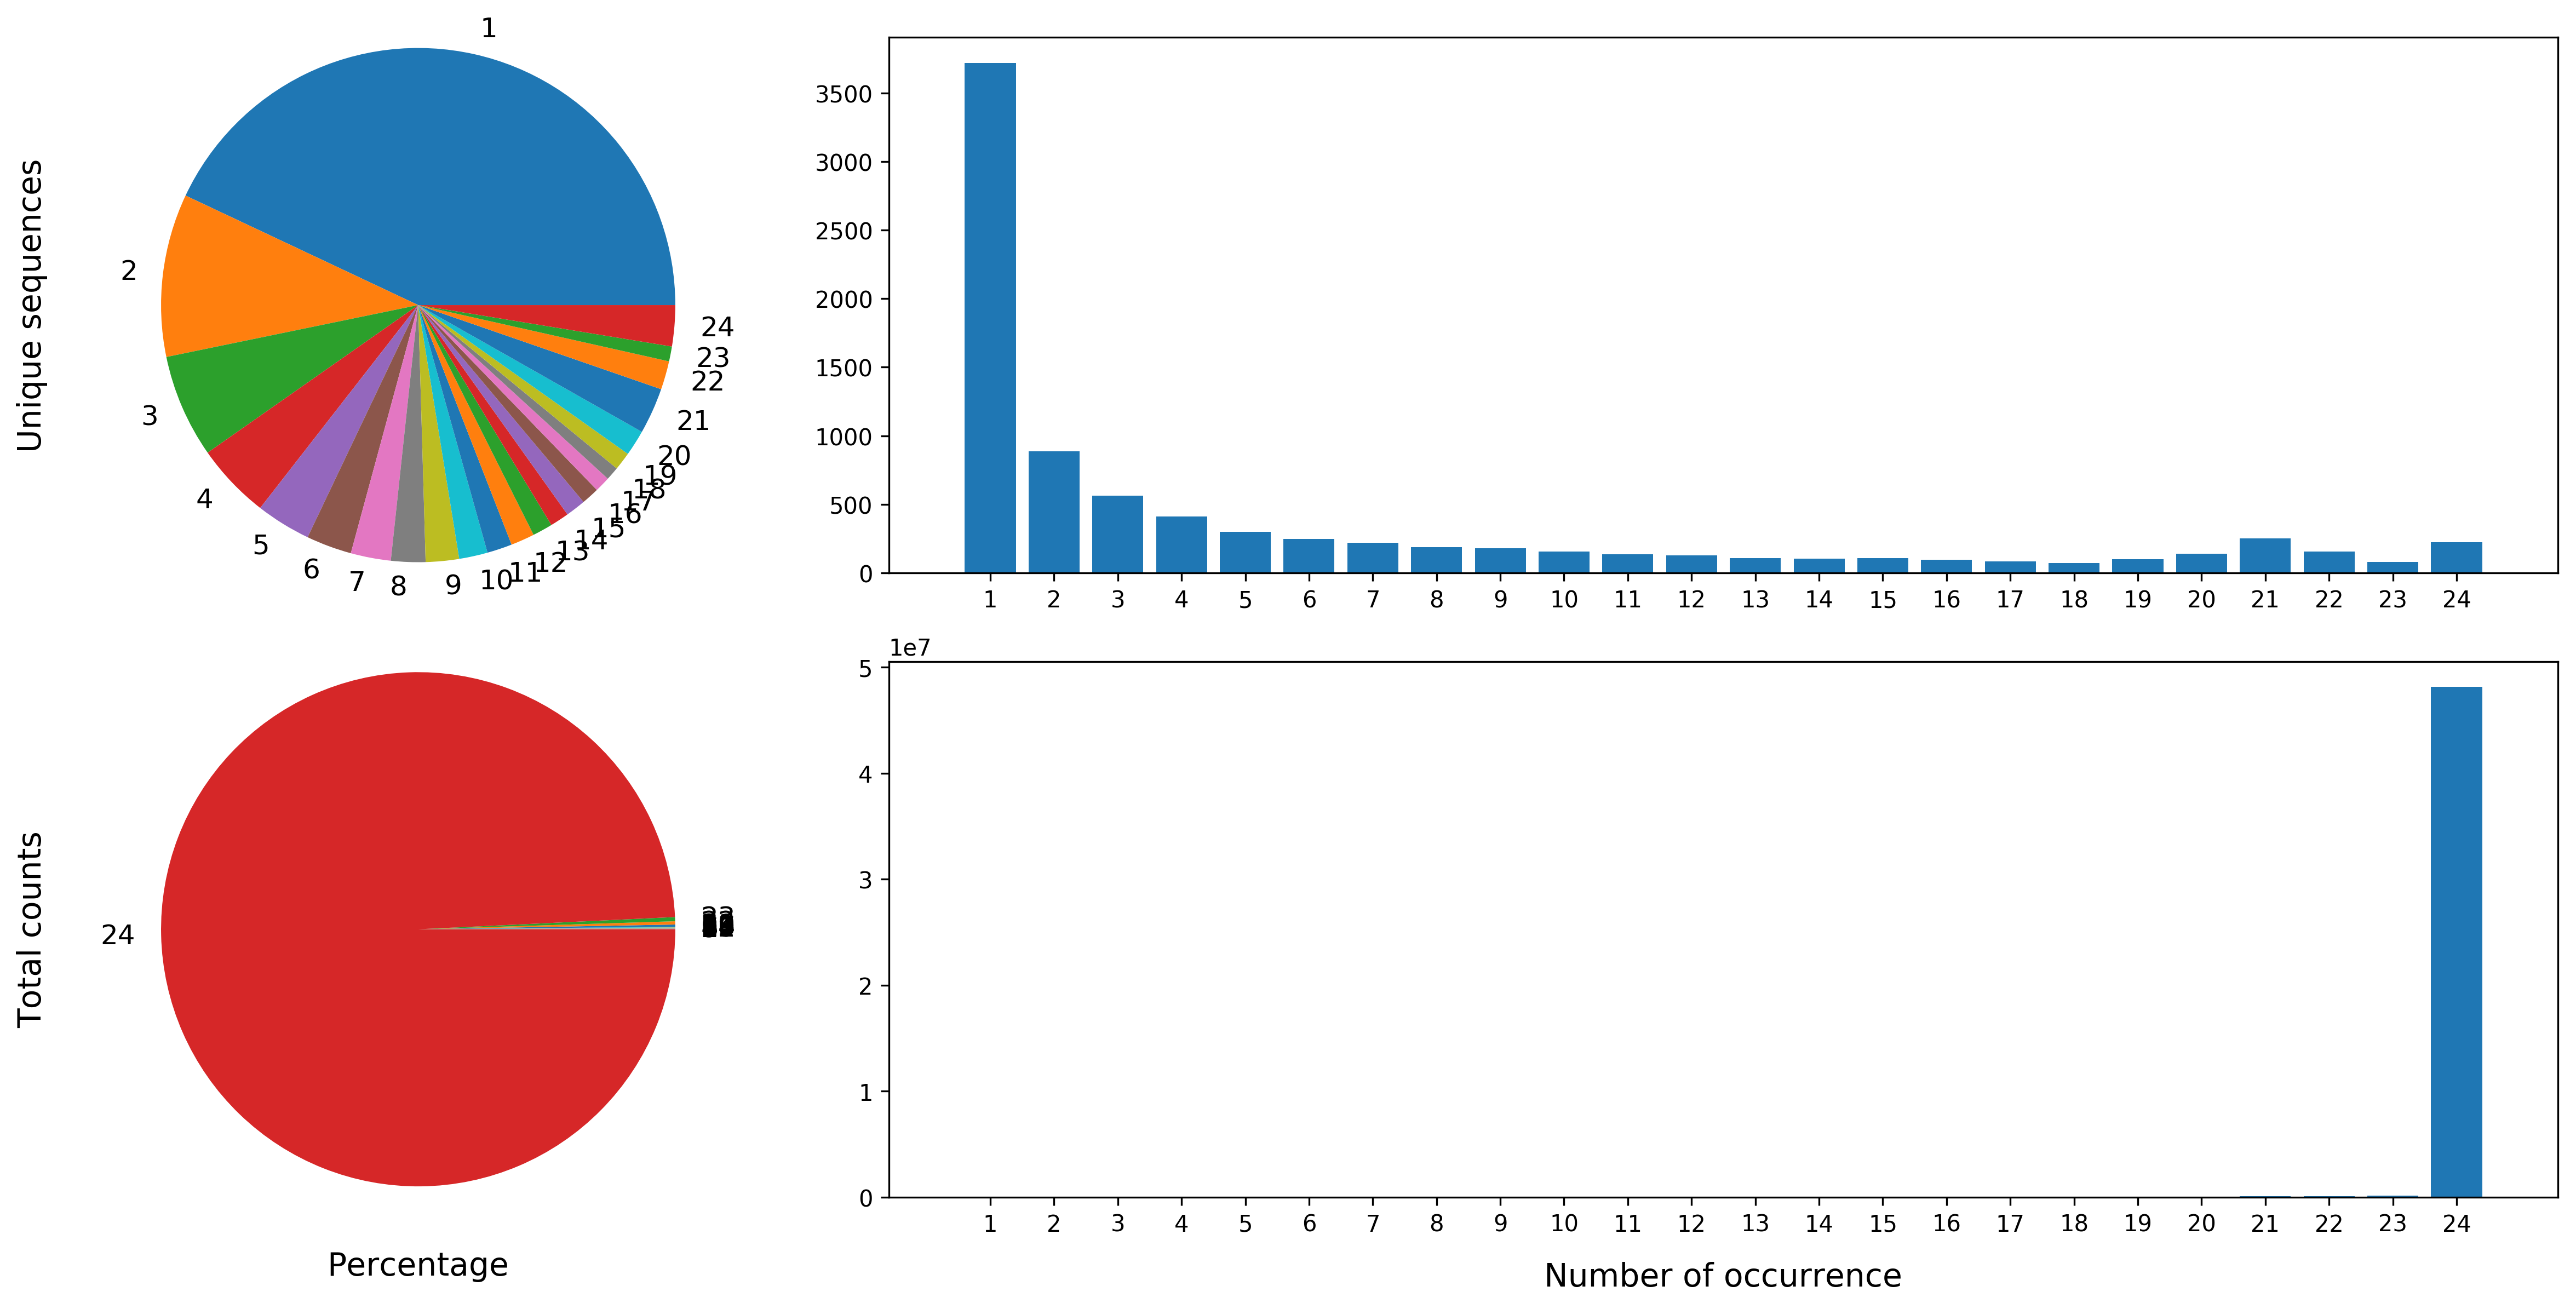

In [567]:
count_bins, count_bins_weighted = analysis.survey_seq_occurrence(sequence_set=sequence_set, display=True)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


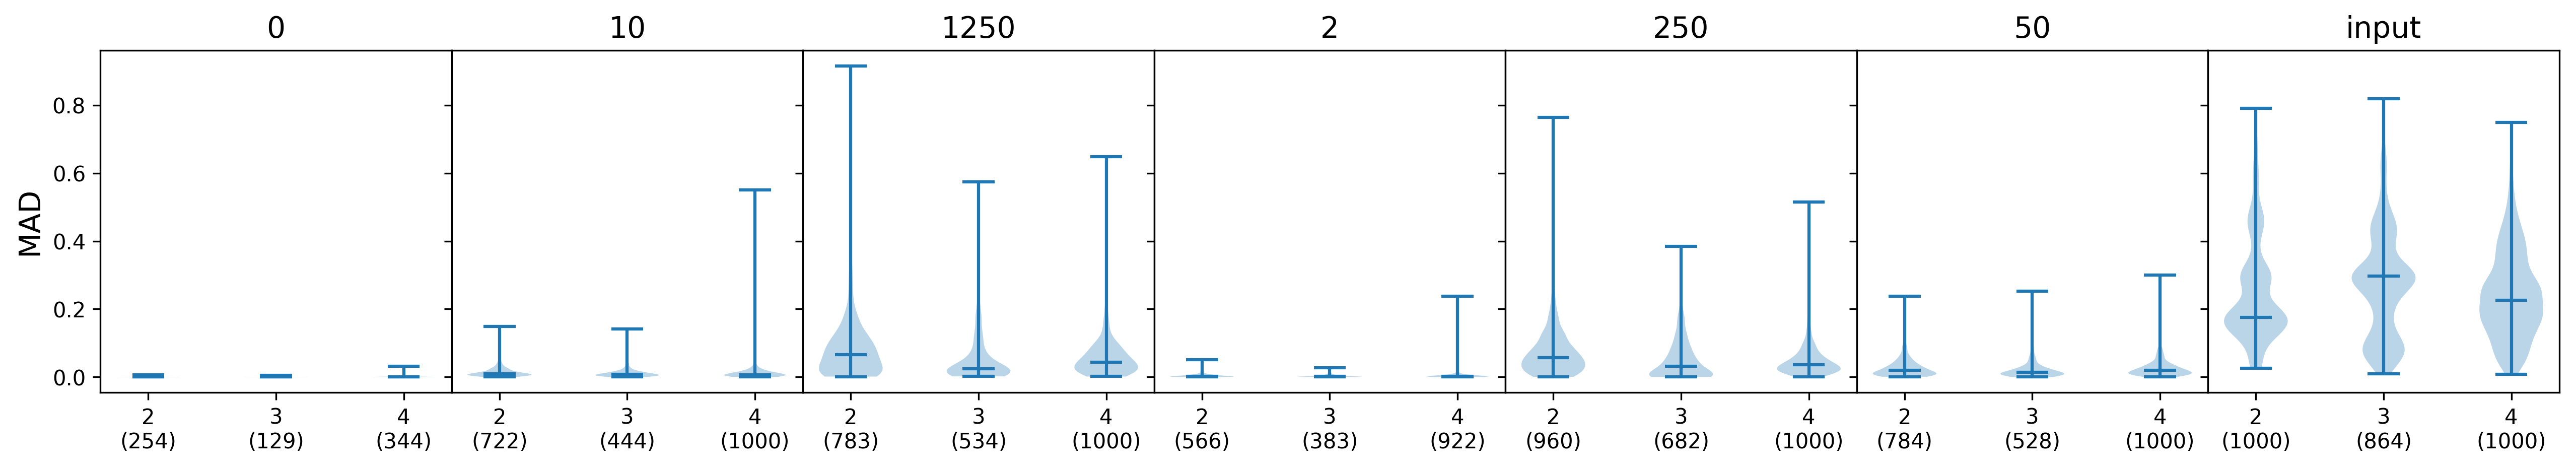

In [569]:

_ = analysis.analyze_rep_variability(sequence_set, display=True, key_domain='byo',percentage=False)

# Fitting

In [464]:
?pd.DataFrame()

In [461]:
np.linspace(0, 9, 10, dtype=np.int)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [425]:
import multiprocessing as mp

flag='this is flag'

def work_fn(col):
    print('seq:{}\tsum:{}; flag:{}'.format(col[0], np.nansum(list(col[1])), flag))

pool = mp.Pool(processes=4)
results = pool.map(work_fn, sequence_set.reacted_frac_table.iloc[:10].iterrows())

seq:ATTCACCTAGGTCATCGGCTGT	sum:2.9524773679864404; flag:this is flag
seq:CTACTTTAAACAATCGGTCTC	sum:1.1651032743869087; flag:this is flag
seq:CCGCTTCATACAATCGGTTTG	sum:4.568002181606462; flag:this is flag
seq:TTACCTTGGTCATCGAGTGT	sum:2.0456324234721492; flag:this is flag
seq:CCGCTTCAAGCAATCGGACGC	sum:0.20711076834767175; flag:this is flag
seq:TTACCCTGGACATCGAGTGT	sum:1.7824983396030338; flag:this is flag
seq:TTCAAACAATCGGTCGCGGTT	sum:0.0831211369106148; flag:this is flag
seq:AGTGGAGACCTGCCCGTGTGA	sum:0.2682265534683705; flag:this is flag
seq:ATTAGCCTGGTCATCGAGTGT	sum:5.939569148437322; flag:this is flag
seq:TCTCAATTGTATGCACCGTGT	sum:0.09841479036310784; flag:this is flag


# fitting

In [45]:
fitting_res = fitting.fitting_single(x_data=x_data,
                           y_data=y_data,
                           func=curve,
                           missing_data_as_zero=False,
                           bootstrap=True,
                           bounds=((0, 0, -np.inf), (1, np.inf, np.inf)),
                           bs_depth=2000,
                           bs_residue=True,
                           bs_return_verbose=True)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [27]:
fitting_res[0]

{'fitting_weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 'mean': array([8.25326473e-02, 3.15710939e+01, 1.97461797e-04]),
 'p2.5': array([nan, nan, nan]),
 'p50': array([nan, nan, nan]),
 'p97.5': array([nan, nan, nan]),
 'params': array([1.13938771e-03, 2.33935701e+01, 2.05347888e-04]),
 'pcov': array([[ 6.03540866e-08, -2.43419627e-03,  1.28327993e-09],
        [-2.43419627e-03,  1.41930998e+02, -4.23390745e-04],
        [ 1.28327993e-09, -4.23390745e-04,  5.00818902e-09]]),
 'pct_res': array([-0.51302153,  0.4609354 , -0.51302153, -0.12696553, -0.56348276,
        -0.56348276, -0.06013544,  0.87972911,  0.25315274, -0.05138287,
         0.18577142, -0.05138287,  0.04222877,  0.04222877,  0.48889824,
         0.16144001, -0.26090181, -0.47207272, -0.17078827,  0.07797525,
         0.24381759]),
 'sd': array([2.60841556e-01, 3.16569584e+01, 6.15641375e-05]),
 'x_data': array([   0,    0,    0,   10,   10,   10,   50,   5

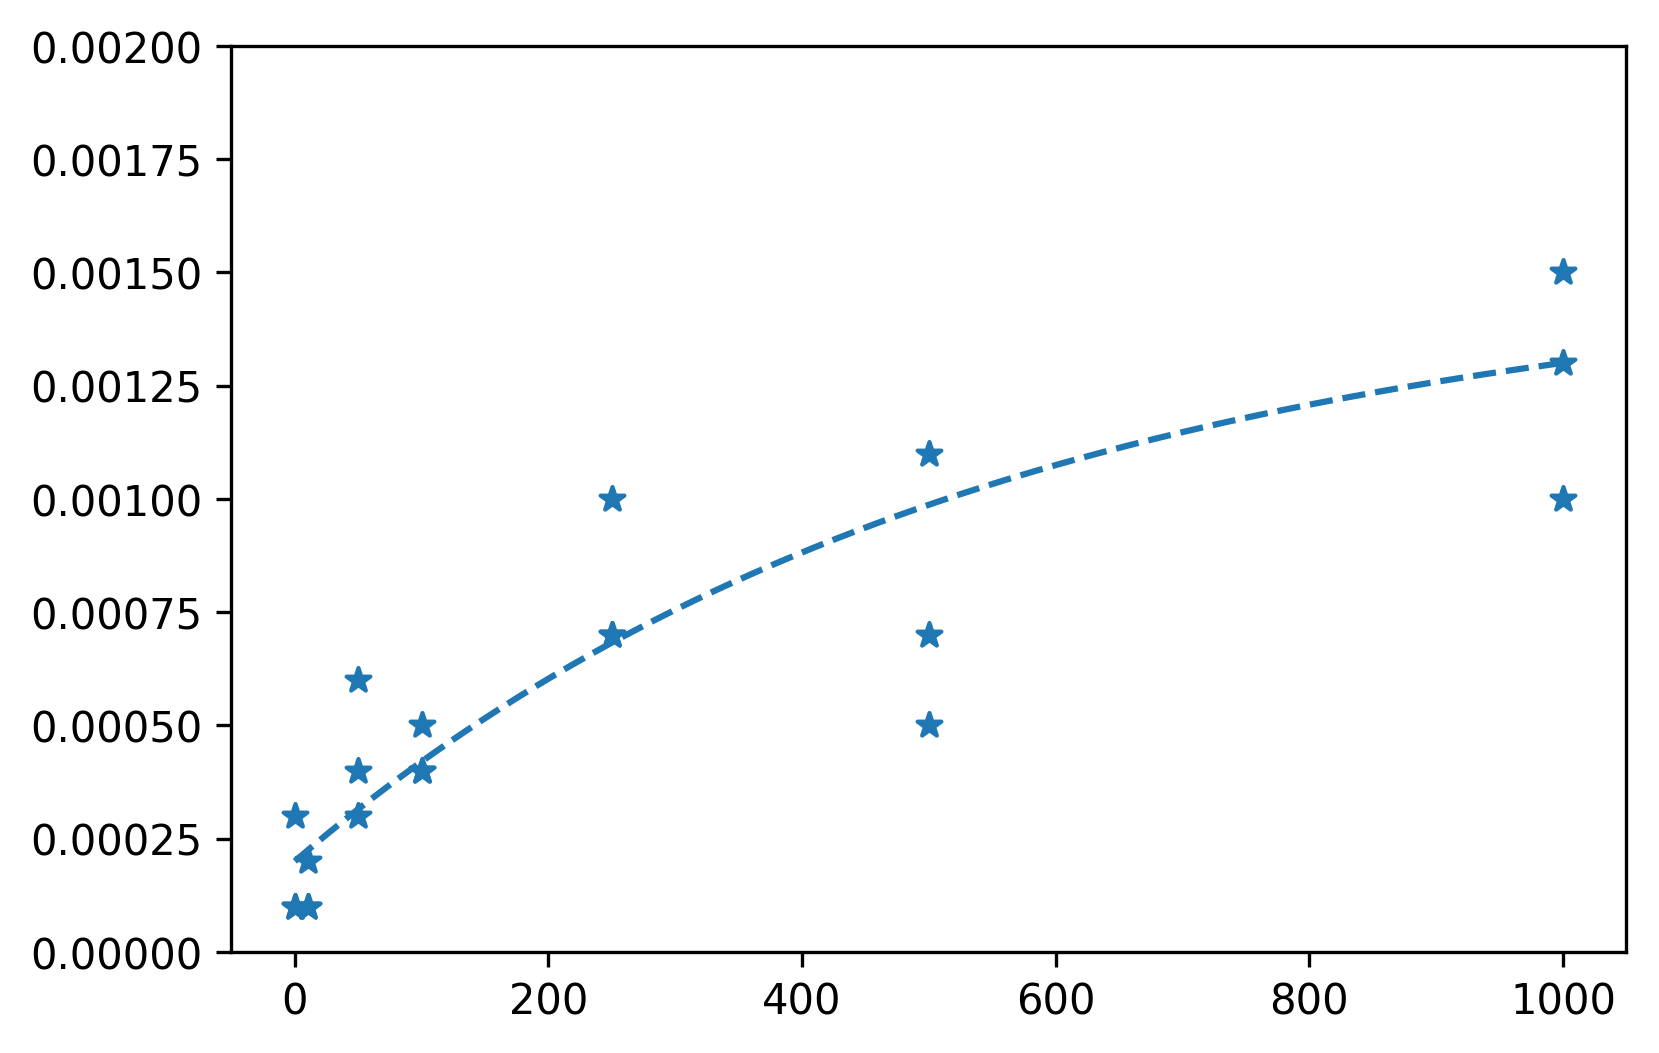

In [24]:
import matplotlib.pyplot as plt


x_values = np.linspace(0, 1000, 500)
y_values = curve(x_values, 0.001307, 20.48, 0.0002)
plt.scatter(fitting_res[0]['x_data'], fitting_res[0]['y_data'], marker='*')
plt.plot(x_values, y_values, '--')
plt.ylim([0, 0.002])
plt.show()


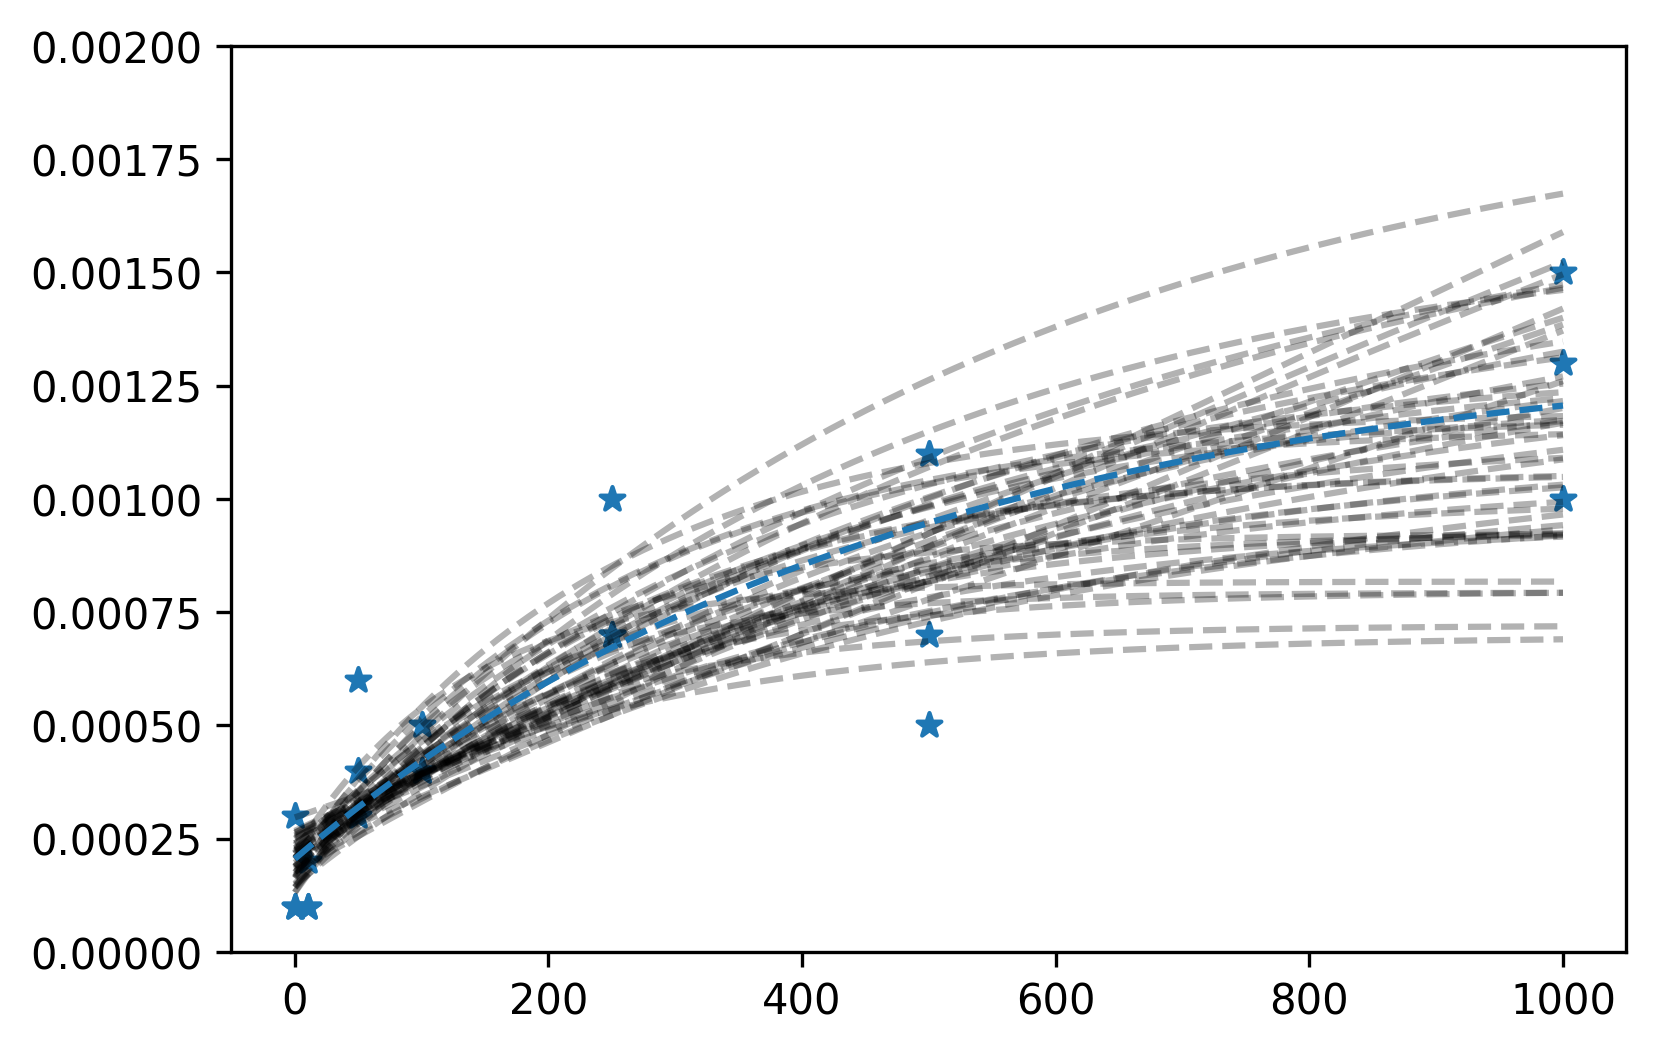

In [46]:
x_values = np.linspace(0, 1000, 500)
y_values = curve(x_values, *fitting_res[0]['params'])
plt.scatter(fitting_res[0]['x_data'], fitting_res[0]['y_data'], marker='*')
for bs_params in np.random.choice([i for i in range(len(fitting_res[1]))], replace=False, size=50):
    bs_y_values = curve(x_values, *fitting_res[1][bs_params])
    plt.plot(x_values, bs_y_values, 'k--', alpha=0.3)
plt.plot(x_values, y_values, '--')
plt.ylim([0, 0.002])
plt.show()

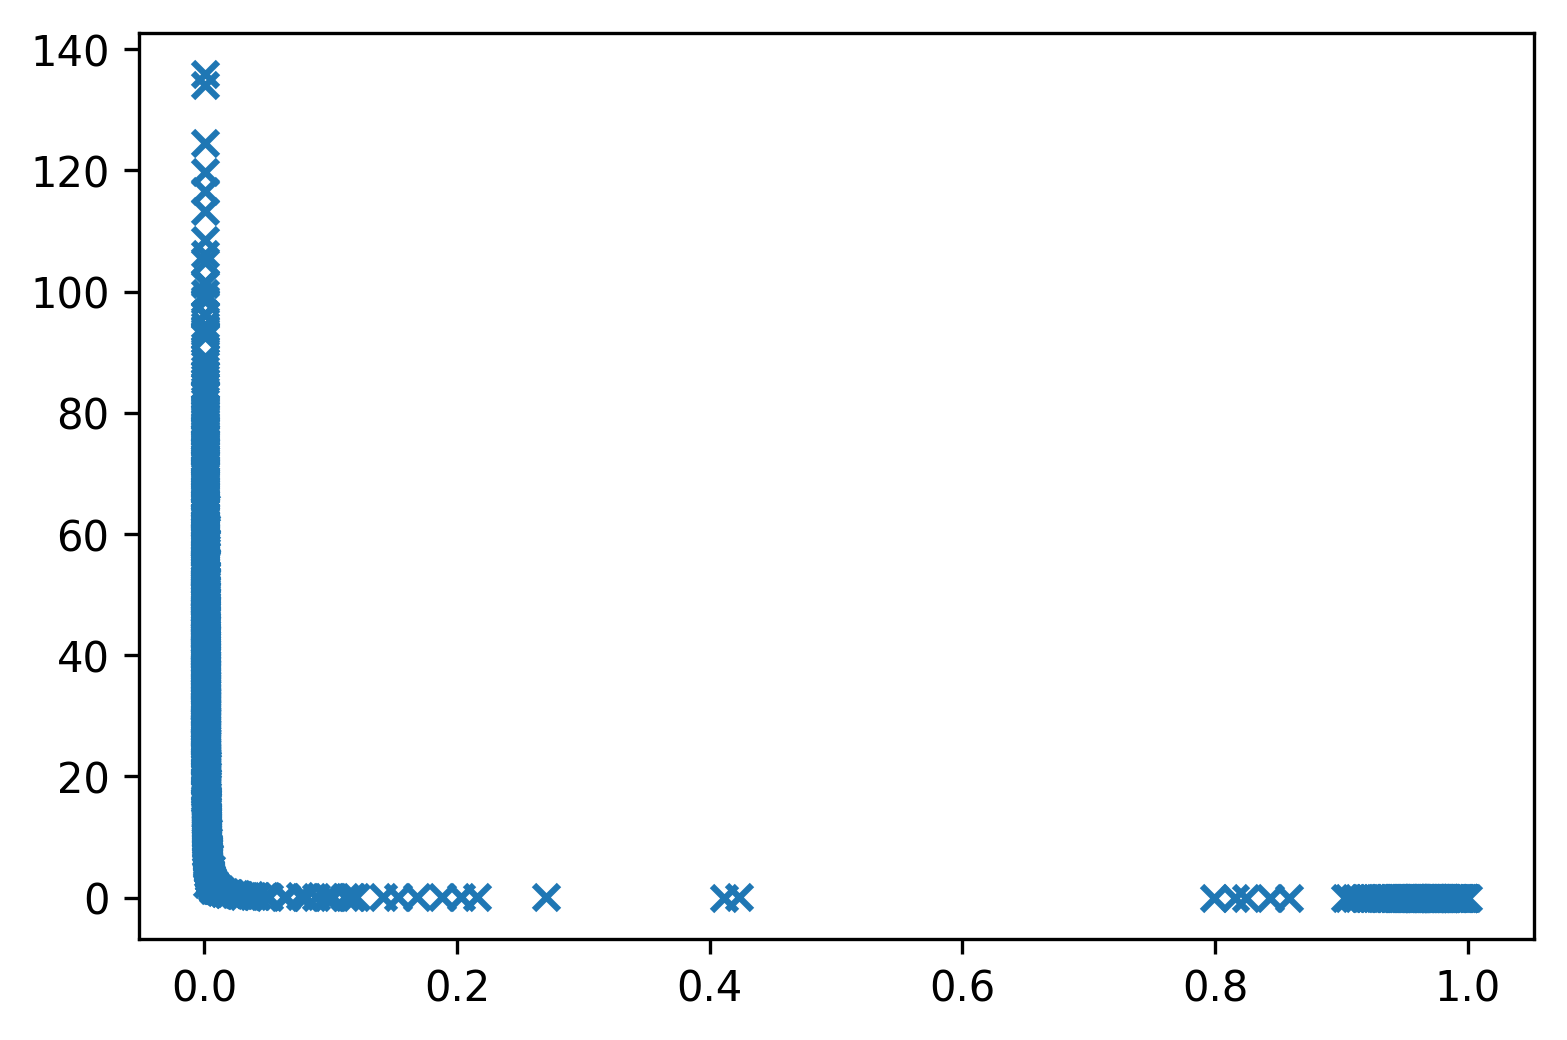

In [48]:
k_values = np.array(fitting_res[1]).T[1]
A_values = np.array(fitting_res[1]).T[0]
kA_values = k_values * A_values
plt.scatter(A_values, k_values, marker='x')
plt.show()

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


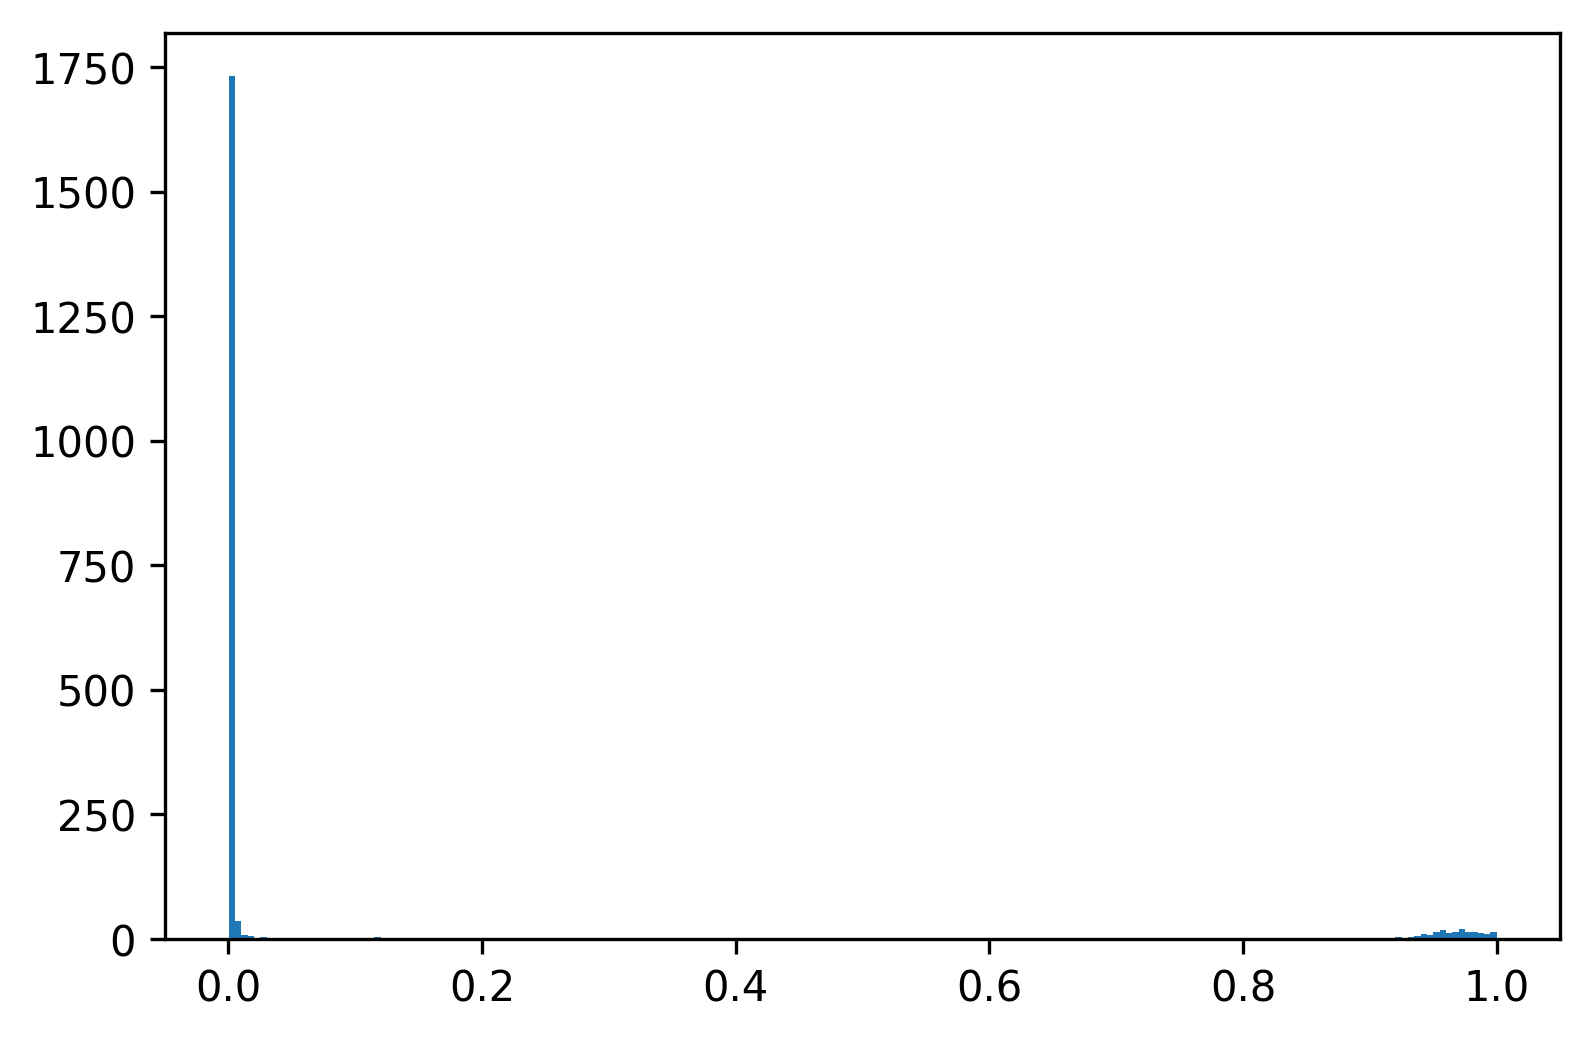

0.0006036151415226418 - 0.9783971726731509


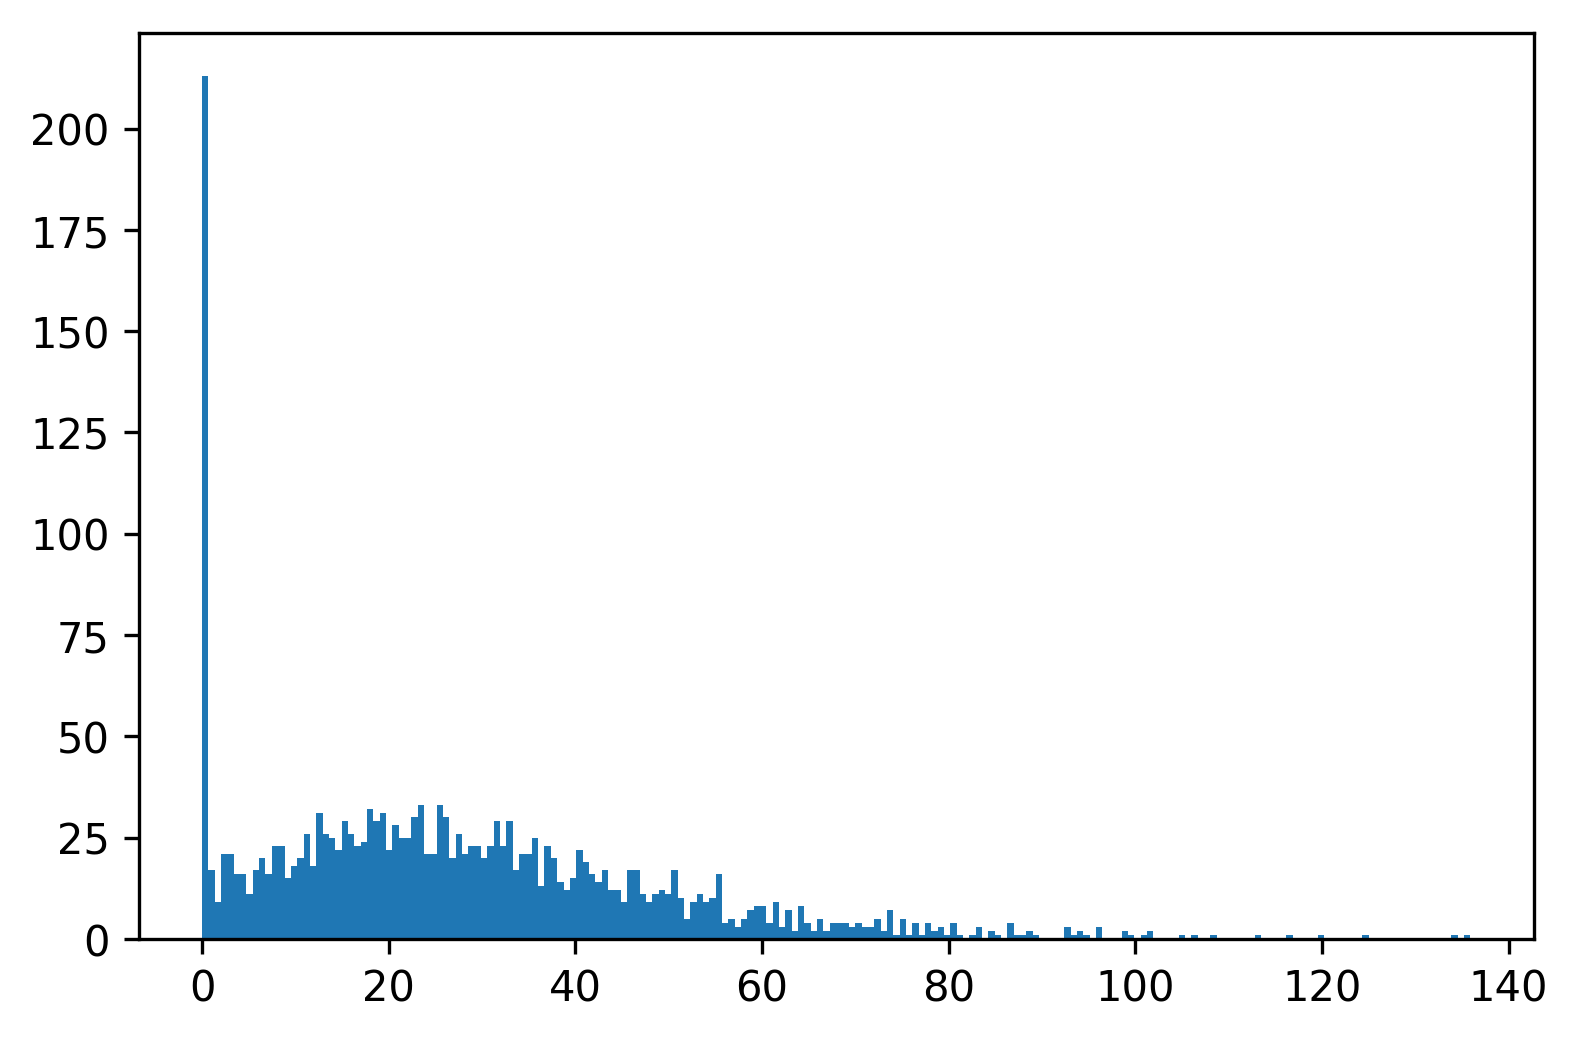

0.012009061591442004 - 78.7173509494445


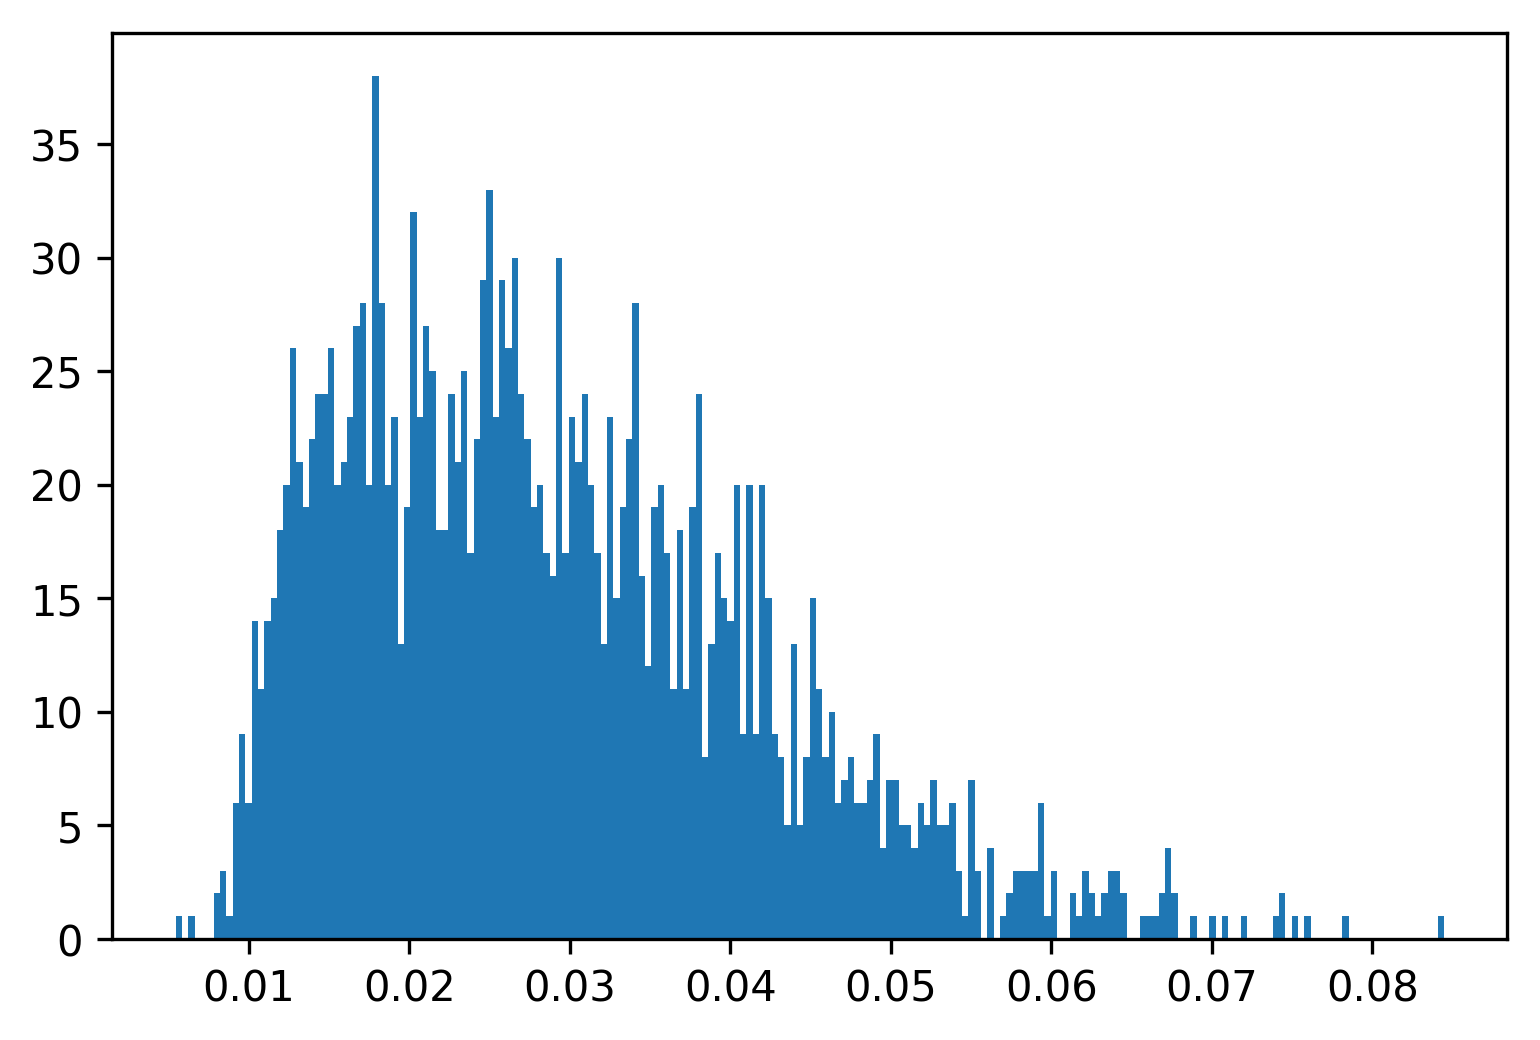

0.010870529241524743 - 0.05924373655988702


In [50]:
plt.hist(A_values, bins=200)
plt.show()
print('{} - {}'.format(np.nanpercentile(A_values, q=2.5), np.nanpercentile(A_values, q=97.5)))
plt.hist(k_values, bins=200)
plt.show()
print('{} - {}'.format(np.nanpercentile(k_values, q=2.5), np.nanpercentile(k_values, q=97.5)))
plt.hist(kA_values, bins=200)
plt.show()
print('{} - {}'.format(np.nanpercentile(kA_values, q=2.5), np.nanpercentile(kA_values, q=97.5)))

In [498]:
sequence_set_test = sequence_set
print(sequence_set_test.reacted_frac_table.__dict__.keys())
sequence_set_test.reacted_frac_table.drop(labels=sequence_set_test.reacted_frac_table.index[11:], inplace=True)
sequence_set_test.reacted_frac_table.__dict__.keys()

dict_keys(['is_copy', '_data', '_item_cache', 'input_avg_type', 'col_x_values', 'input_avg', '_iloc'])


dict_keys(['is_copy', '_data', '_item_cache', 'input_avg_type', 'col_x_values', 'input_avg', '_iloc'])

In [541]:
fitting.fitting_sequence_set(sequence_set=sequence_set_test, inplace=True, parallel_threads=6)

/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq

In [535]:
def func_1(arg_1, arg_2, arg_3, **kwargs):
    print(arg_1)
    print(arg_2)
    print(arg_3)
    print('kwargs:{}'.format(kwargs))

def func_2(arg_1, **kwargs):
    func_1(arg_1=arg_1, **kwargs)
    
func_2(arg_1=1, arg_2=2, arg_3=3, arg_4=34)

1
2
3
kwargs:{'arg_4': 34}


# Fitting results analysis

In [13]:
fittingRes = util.load_pickle(dirc='/mnt/storage/projects/k-seq/working/bfo_evan/fittingRes_bfo_deep_new_alpha.pkl')

fittingRes_bfo_deep_new_alpha.pkl:
Fitting results of BFO data with new degradation coefficient alpha, including the CI 95 estimation using 1000 bootstrap, on Pod (15 cores)


In [29]:
seq_filter = lambda seq: (np.sum(~np.isnan(seq['reactedFrac'])) == 20) and (np.sum(~np.isnan(seq['negStdRaw'])) == 4)

fitting_res_filtered = [seq for seq in fittingRes if seq_filter(seq)]

print(len(fitting_res_filtered))

337


In [31]:
median_kA_filters = [
    lambda seq: seq['ci95'][2][1] <= 70,
    lambda seq: 70 < seq['ci95'][2][1] <= 275,
    lambda seq: 275 < seq['ci95'][2][1]
]

seq_selected = [np.random.choice([seq for seq in fitting_res_filtered if kA_filter(seq)], size=5, replace=False) for kA_filter in median_kA_filters]

In [32]:
seq_selected

[array([{'seq': 'GTCCACTTCAAACAATCGGTC', 'initRaw': [175, 86, 223, 209], 'kSeqRaw': [59, 36, 40, 21, 17, 88, 268, 68, 56, 32, 59, 100, 80, 79, 24, 108, 97, 64, 31, 25], 'negStdRaw': [3, 1, 1, 11], 'kSeqFmol': array([0.22669104, 0.11126369, 0.03645825, 0.01237274, 0.00304643,
        0.18149792, 0.16864296, 0.08516135, 0.03274373, 0.00662938,
        0.25557989, 0.19466716, 0.05784658, 0.02048119, 0.00238753,
        0.24955835, 0.18400408, 0.05426089, 0.01312614, 0.00260043]), 'initFmol': array([1.73555247, 1.16708069, 1.2597164 , 1.80049895]), 'reactedFrac': array([0.15136607, 0.07429296, 0.02434389, 0.00826152, 0.00203416,
        0.12118974, 0.11260622, 0.05686391, 0.02186363, 0.00442657,
        0.17065573, 0.12998309, 0.0386253 , 0.01367569, 0.0015942 ,
        0.16663503, 0.12286315, 0.03623107, 0.00876458, 0.00173636]), 'r2': 0.9414754690791457, 'params': [0.15171253079041397, 178.47441720891604, 27.076805516108863], 'stdevs': array([4.26925419e-02, 7.72486762e+01, 1.15764351e+0

limit_output extension: Maximum message size of 10000 exceeded with 18807 characters

'<__main__.SampleClass object at 0x7facc7122c18>'

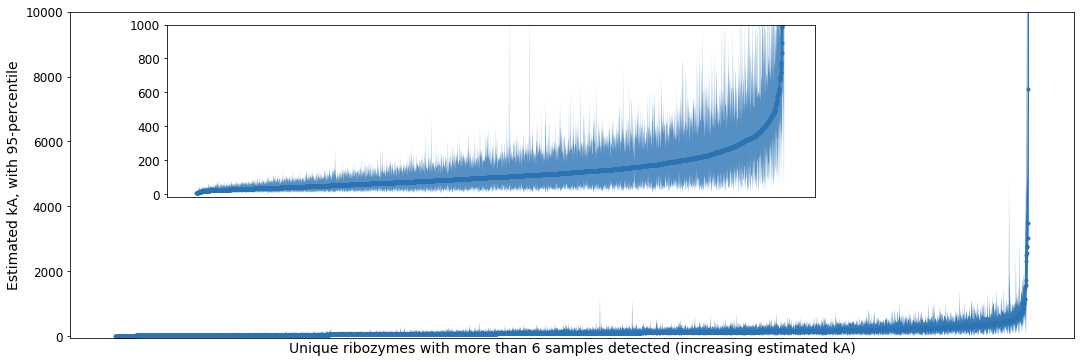

In [183]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 10000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_ylim([-20, 1000])
    axInset.set_xticks([])
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

surveyRes = []
# Only survey ribozymes at least detected 6 times and the CI can be estimated, return prediction and CI
for res in fittingRes:
    if np.sum(~np.isnan(res['kSeqFmol'])) >= 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)

In [185]:
len(surveyRes)

3039

In [175]:
def get_config(res):
    return np.sum(~np.isnan(res['kSeqFmol'].reshape(4, 5)), axis=0)

def sort_fn(res):
    if np.isnan(res['params'][2]):
        return (0, 0)
    elif len(res['ci95'])==1:
        return (1, 0)
    else:
        return (1, res['ci95'][2][1])


def export_csv(fittingRes, dirc):
    fittingRes.sort(key=sort_fn, reverse=True)
    with open(dirc, 'w') as output:
        output.write('seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean\n')
        for res in fittingRes:
            output.write('%s,%i,%s,' %(res['seq'], np.nanmedian(res['initRaw']), get_config(res)))
            if np.isnan(res['params'][2]):
                output.write('0,0,%s\n' %(','.join(['nan' for i in range(15)])))
            elif len(res['ci95'])==1:
                output.write('1,0,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2], ','.join(['nan' for i in range(12)])))
            else:
                output.write('1,1,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2],
                                                    ','.join(['%f'%i for i in list(res['ci95'][2]) + list(res['ci95'][0]) + list(res['ci95'][1])])))

export_csv(fittingRes, dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [15]:
import pandas as pd

df = pd.read_csv('/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [18]:
df.sort_values(by='inputCountMedian', ascending=False)

seq  inputCountMedian       config  kAEstimate  \
1949     CTACTTCAAACAATCGGTCTG            535826  [4 4 4 4 4]           1   
2248     AAAAACAAAAACAAAAACAAA            424144  [4 4 4 4 4]           1   
282      ATTACCCTGGTCATCGAGTGA            166719  [4 4 4 4 4]           1   
197      ATTACCCTGGTCATCGAGTGT            119288  [4 4 4 4 4]           1   
4470     CTCTTCAAACAATCGGTCTTC             73892  [4 4 4 4 4]           1   
3859     ATTCACCTAGGTCATCGGGTG             63062  [4 4 4 4 4]           1   
1025    ATTCACCTAGGTCATCGGGTGT             62453  [4 4 4 4 4]           1   
4493     CCACACTTCAAGCAATCGGTC             50627  [4 4 4 4 4]           1   
1738     CCGCTTCAAACAATCGGTTTG             33567  [4 4 4 4 4]           1   
1028    ATTCACCTAGGTCATCGAGTGT             18526  [4 4 4 4 4]           1   
4726      CACACTTCAAGCAATCGGTC             18498  [4 4 4 4 4]           1   
4362     ACCCACTTCAAACAATCGGTC             17398  [4 4 4 4 4]           1   
3834     CTGCTTCAAACAATCGGTGTG              9298  [4 4 4 4 4]           1   
3374      TACTTCAAACAATCGGTCTG              8536  [4 4 4 4 4]           1   
1299    ATTCACCTAGGTCATCGAGTGA              7976  [4 4 4 4 4]           1   
3232    CTACTTCAAACAATCGGTCTTC              7091  [4 4 4 4 4]           1   
4393     CTGTTTCAAACAATCGGTCTC              5953  [4 4 4 4 4]           1   
394    ATTCACCTAGGTCATCGGGTGTT              4524  [4 4 4 4 4]           1   
2093     CCACTTCAAACAATCGGTCTG              4422  [4 4 4 4 4]           1   
3638     CCAGTCTTCAAACAATCGGTC              4084  [4 4 4 4 4]           1   
1958    AAAAAACAAAAACAAAAACAAA              3793  [4 4 4 4 4]           1   
2069      AAAACAAAAACAAAAACAAA              3708  [4 4 4 4 4]           1   
4696     AGCCCGCTTCAAACAATCGGT              3257  [4 4 4 4 4]           1   
4995      TCTTCAAACAATCGGTCTTC              3147  [4 4 4 4 4]           1   
4205     CCAAACTTCAAACAATCGGTC              2618  [4 4 4 4 4]           1   
3361     CTGTTTCAAACAATCGGCCTG              2618  [4 4 4 4 4]           1   
570       TTACCCTGGTCATCGAGTGT              2488  [4 4 4 4 4]           1   
4263     CCGCTTCAAGCAATCGGTCGC              2487  [4 4 4 4 4]           1   
2241    AAAAACAAAAAACAAAAACAAA              2298  [4 4 4 4 4]           1   
4619     CTGTTTCAAACAATCGGTCGC              2260  [4 4 4 4 4]           1   
...                        ...               ...          ...         ...   
4656     ACCCTCTTCAACCAATCGGTC                 1  [1 1 1 0 0]           1   
1784    AAAAACAAAAACAGAAAACAAA                 1  [2 0 0 1 0]           1   
4654     CCTGTCTTCAACCAATCGGTC                 1  [2 1 0 0 0]           1   
390   ATTACCCTGGTCATCGAGTGATTA                 1  [1 3 3 3 2]           1   
374    CATTACCCTGGTCATCGAGTGAT                 1  [4 3 4 4 4]           1   
373      ACACTTCAAACAATCGGTCGC                 1  [0 0 2 0 1]           1   
372          AAAACAAAAACAACAAA                 1  [2 2 1 1 3]           1   
1412     CGGCTTCAAACAATCGGTTTG                 1  [3 4 4 1 1]           1   
349    CCCCACACTTCAAGCAATCGGTC                 1  [0 0 1 1 0]           1   
350   ACCGCCTTCAAACAATCGGTCTTC                 1  [0 0 1 1 0]           1   
351      TTCAAACAATCGGTCCTGCAT                 1  [0 0 1 1 0]           1   
352      CCAGTATTCAAACAATCGGTC                 1  [0 0 2 0 1]           1   
4699     GCTCTTCAACAATCGGCCTGC                 1  [1 0 1 0 0]           1   
4698     CTACCTCAAACAATCGGCCTG                 1  [1 0 1 0 0]           1   
353     ATTACCCTTGGTCATCGAGTGA                 1  [4 4 4 4 3]           1   
1768    AAAAACAAAAAACCAAAACAAA                 1  [0 1 0 1 1]           1   
355     AAAAAAACAAAAAAAAAACAAA                 1  [0 1 1 2 3]           1   
356       TTACCCTGGTTATCGAGTGA                 1  [0 1 1 2 0]           1   
359       CACACTTCAAGCAATGGGTC                 1  [0 1 0 0 1]           1   
361       AAAATAAAAACAAAAACAAA                 1  [2 3 2 1 3]           1   
4691     ACACCCGCCTTCAA

limit_output extension: Maximum message size of 10000 exceeded with 33203 characters

In [19]:
len(df)

9086

In [34]:
def filter_fn(seq):
    return np.sum([int(seq[1]['config'][i]) for i in [1,3,5,7]])>=6

dfNew = df[[filter_fn(seq) for seq in df.iterrows()]]

In [38]:
dfNew.sort_values(by='kA', ascending=False)

seq  inputCount     config  kAEstimate  CIEstimate  \
39       TGATTTCAAGCAATCGGTCTG           1  [3 1 2 0]           1           1   
0       CCAAAACTTCAAACAATCGGTC           6  [6 5 3 4]           1           1   
1           CCGCTTCAAATCGGTTTG           1  [4 3 1 4]           1           1   
513      ACTTCAAACAATCGATCGGCA           1  [1 3 2 0]           1           1   
3           CTACTTCAAATCGGTCTG           2  [5 4 0 4]           1           1   
30      CCAAGTTTTCAAACAATCGGTC           1  [6 5 3 4]           1           1   
27      CCGCACTTCAAGCAATCGGTCT           1  [6 5 3 4]           1           1   
23         CCGCTTCACAATCGGTTTG           1  [6 4 3 4]           1           1   
99       GCTTCAACCAATCGGTCCGCC           1  [6 5 3 4]           1           1   
58       CCGCTTCAAACAATCCGTTTG           3  [6 5 3 4]           1           1   
57          CCAGTCTTCAAATCGGTC           1  [3 3 0 3]           1           1   
284     TTCAAACAATCGGTCTGCCGTT           1  [6 5 3 4]           1           1   
49        ATTACCCTGTCATCGGGTGT           3  [6 5 3 4]           1           1   
209     ACTTCAAACAATCGGTCTGATT           1  [6 5 3 4]           1           1   
19       ATTACCCTGGTCATCCAGTGA           4  [6 5 3 4]           1           1   
48       ATCCCCCTGGTCATCGAGTGA           2  [3 3 0 3]           1           1   
529       CGCTTCAAGCAATCGGTCGC           1  [6 5 3 4]           1           1   
300     CGCTTCAAGCAATCGGTGTGCT           2  [6 5 3 4]           1           1   
356       CCGCTTCAACAATCGGTTTG           7  [6 5 3 4]           1           1   
306      CTTTTTCAAACAATCGGCCTG           1  [6 5 3 4]           1           1   
103       ATGACCCTGGTCATCGGGTG           2  [6 5 3 4]           1           1   
438                 ATTACCCTGG           1  [6 5 3 4]           1           1   
553       CTACTTCAAACAATCGTCTG           3  [6 5 3 4]           1           1   
97        ATGACCCTGGTCATCGGGGT           1  [6 5 3 4]           1           1   
533      CCTTACTTCAAACAATCGGTC           1  [6 5 3 4]           1           1   
536      CCGCTTCGAGCAATCGGTCGC           1  [6 5 3 4]           1           1   
589      ACCCCGCTTCAAACAATCGGT           1  [6 5 3 4]           1           1   
616      CCGCTTCAATCAATCGGTCTC           1  [6 5 3 4]           1           1   
309      ACTTCAAACAATCGGTCCGCA           1  [6 5 3 4]           1           1   
666      AGCCGCTTCAACCAATCGGTC           1  [6 5 3 3]           1           1   
...                        ...         ...        ...         ...         ...   
403711   AATAATCGTCTGCGGGTAAAT           2  [5 0 0 2]           0           0   
403718   AATTAATCGGTCCTGCAGTAT           1  [4 0 0 2]           0           0   
403721   AATCAATCGGTCTGTCGCTCA           1  [5 0 0 1]           0           0   
403723   AATCAATCGGTCTGCTTGGGT           2  [4 0 0 2]           0           0   
403724   AATCAATCGGTCTGCGTAGCT           1  [5 0 0 2]           0           0   
403728   AACAATCGGTCTGCACAGGAG           6  [5 0 1 0]           0           0   
403729   AACAATCGGTCTACAGCCTCT           1  [5 0 0 2]           0           0   
403730   AACAATCGGTCTGTACTGACT           3  [4 0 0 2]           0           0   
403731   AACAATCGGTCTGTATTTAAT           1  [5 0 0 2]           0           0   
403732   AACAATCGGTCTGGGGCGAGC           1  [5 0 0 1]           0           0   
403733   AACAATCGGCCTGTAGTATGT           1  [4 0 0 2]           0           0   
403734   AACAATCGGCCTCGCAGTGGC           1  [6 0 0 2]           0           0   
403745   ATTGCCCTGGTGATCGAGTGG           1  [4 0 0 2]           0           0   
403763   ATTCTTTTGGTCATTTGCTGC           4  [4 0 0 3]           0           0   
403766   ATTCTCTCTTCAATAATCGTC           2  [4 0 0 2]           0           0   
403769   ATCTAGCTTCAACCAATCGGT           1  [4 0 0 2]           0           0   
403787   ACCCTGGCTTCAAGCAATCAG           1  [5 0 0 1]           0           0   
403791  TGTGCTTCAAAAATCGGTGGCA           1  [5 0 0 1]     

limit_output extension: Maximum message size of 10000 exceeded with 31468 characters

In [246]:
selected_seq['S-1A.1-a']

{'gel_shift_data': array([[0.43969945, 0.26818966, 0.12608435, 0.0882598 , 0.07635634],
        [0.42030006, 0.23722362, 0.07205889, 0.03691233, 0.03135119],
        [0.41725538, 0.25986244, 0.08677028, 0.04042544, 0.0331289 ]]),
 'gel_shift_res': {'bs_params': array([[  0.61085818, 161.60857694,  98.71992148],
         [  1.        , 154.59564204, 154.59564204],
         [  0.74603574, 507.93705365, 378.93919372],
         ...,
         [  1.        , 345.91275997, 345.91275997],
         [  1.        , 263.21215029, 263.21215029],
         [  1.        , 125.47543986, 125.47543986]]),
  'mean': array([  0.89205005, 452.38857865, 376.86906718]),
  'params': array([  0.42538185, 131.41261085,  55.90053901]),
  'pcov': array([[ 4.94246009e-04, -2.75404256e-01],
         [-2.75404256e-01,  4.06292765e+02]]),
  'pct_res': array([ 4.07865454e-02, -7.10486272e-04,  6.39995140e-01,  4.30853146e+00,
          2.16010295e+01, -5.13261896e-03, -1.16091630e-01, -6.27208253e-02,
          1.22015

# Analysis on selected sequences
## import data

In [5]:
selected_seq = [
    ('S-2.1-a', 'ATTACCCTGGTCATCGAGTGA'),
    ('S-2.1-t', 'ATTACCCTGGTCATCGAGTGT'),
    ('S-1A.1-a', 'CTACTTCAAACAATCGGTCTG'),
    ('S-1B.1-a', 'CCACACTTCAAGCAATCGGTC'),
    ('S-1B.2-a', 'CCGCTTCAAGCAATCGGTCGC'),
    ('S-1B.3-a', 'CCGAGTTTCAAGCAATCGGTC'),
    ('S-3.1-a', 'AAGTTTGCTAATAGTCGCAAG'),
]
selected_seq_seq = [seq[1] for seq in selected_seq]

#####---------------- load k-seq data ----------------------------
k_seq_results = util.load_pickle('/mnt/storage/projects/k-seq/working/bfo_evan/fittingRes_bfo_deep_new_alpha.pkl')
k_seq_results = {seq['seq']: seq for seq in k_seq_results}

######--------------- below is appended new dataset -----------------

gel_reacted_frac = {
    'S-2.1-a': [[0.489295509, 0.419323485, 0.305418426, 0.120166882, 0.035873405, 0.016173072],
                [0.478626156, 0.403143794, 0.274715664, 0.102872995, 0.033116803, 0.017166082],
                [0.489551715, 0.426821441, 0.301406226, 0.117392596, 0.034023201, 0.015117505]], #same as previous
    'S-2.1-t': [[0.247654488, 0.170506483, 0.100291314, 0.049161798, 0.027529764, 0.018740413],
                [0.229005216, 0.151884012, 0.089851748, 0.033955861, 0.012286652, 0.017338768],
                [0.231373165, 0.149670088, 0.084938506, 0.033389647, 0.015474962, 0.01170447],
                [0.243403682, 0.153396259, 0.095408276, 0.042586067, 0.019300099, 0.012896074],
                [0.226927481, 0.140380394, 0.091431174, 0.042169283, 0.018667761, 0.010952174],
                [0.230181996, 0.146927058, 0.096956494, 0.047895733, 0.018487228, 0.009239871]], # last three rows are newly added
    'S-1A.1-a': [[0.439699452, 0.268189655, 0.126084347, 0.088259795, 0.076356344, 0.059860081],
                 [0.420300055, 0.237223625, 0.072058892, 0.036912327, 0.031351187, 0.029645931],
                 [0.417255385, 0.259862445, 0.086770284, 0.040425438, 0.033128899, 0.031331471]], # large change from last data
    'S-1B.1-a': [[0.416238141, 0.184055558, 0.068116894, 0.028315413, 0.004227116, 0.004596165],
                 [0.455159602, 0.218512114, 0.065886528, 0.025261185, 0.014807864, 0.013362008],
                 [0.330508197, 0.121268749, 0.039476592, 0.02612634, 0.022842214, 0.020548252]], # last one row is newly added, and seems smaller than previous two
    'S-1B.2-a': [[0.391371256, 0.15789507, 0.051620219, 0.032881246, 0.030953661, 0˚.028037674],
                 [0.432537944, 0.185661549, 0.052941428, 0.021257904, 0.017119468, 0.019511053],
                 [0.288784317, 0.102286783, 0.038452036, 0.02845557, 0.026151375, 0.02505473]], # last one row is newly added, and seems smaller than previous two
    'S-1B.3-a': [[0.372488705, 0.181137492, 0.063979744, 0.034339158, 0.027761498, 0.024546059],
                 [0.414744167, 0.211518582, 0.078759508, 0.030439581, 0.019163878, 0.01264281],
                 [0.308792227, 0.120899245, 0.045028565, 0.031398849, 0.027748936, 0.026723334],
                 [0.47562996, 0.268289712, 0.08550071, 0.036814349, 0.026340063, 0.022892661],
                 [0.462661054, 0.265942326, 0.092524106, 0.044660471, 0.03144388, 0.028969754]], # new dataset
    'S-3.1-a':  [[0.629629071, 0.267061308, 0.084716043, 0.041885866, 0.033853309, 0.031580398],
                 [0.693690731, 0.355765177, 0.112267161, 0.046034788, 0.031727659, 0.028746741],
                 [0.688746745, 0.365462046, 0.118545135, 0.048411197, 0.035810519, 0.033815235]] # newly added data
}
 
#mask 0 BFO concentration
for seq in gel_reacted_frac.keys():
    gel_reacted_frac[seq] = np.array(gel_reacted_frac[seq])[:, :-1]
    

# ------------------------    
selected_seq = {
    seq[0]:{
        'seq': seq[1],
        'k_seq_data': k_seq_results[seq[1]]['reactedFrac'].reshape(4, 5),
        'gel_shift_data': gel_reacted_frac[seq[0]]
    } for seq in selected_seq
}

fittingRes_bfo_deep_new_alpha.pkl:
Fitting results of BFO data with new degradation coefficient alpha, including the CI 95 estimation using 1000 bootstrap, on Pod (15 cores)


## fitting

In [449]:
import k_seq.fitting.fitting

NameError: name 'func_default' is not defined

In [451]:
def bfo_model(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x))

def fitting_classic(x, y_list):
    result = {}
    result['point_estimation'] = fitting.fitting_single(x_data=np.array(x), 
                                                        y_data=np.mean(y_list, axis=0),
                                                        bounds=([0, 0], [1., np.inf]),
                                                        ci_est=False,
                                                        func=func,
                                                        missing_data_as_zero=False)['params']
    result['point_estimation'] = [result['point_estimation'][0],
                                  result['point_estimation'][1],
                                  result['point_estimation'][0]*result['point_estimation'][1]]
    result['rep_res'] = np.array([
        fitting.fitting_single(x_data=np.array(x),                    
                               y_data=y_list[i],           
                               bounds=([0, 0], [1., np.inf]),          
                               ci_est=False,
                               func=func,
                               missing_data_as_zero=False)['params']
        for i in range(3)
    ])
    params = result['rep_res']
    result['rep_res'] = np.append(params.T, [params[:, 0]*params[:, 1]], axis=0).T
    result['sd_estimation'] = np.std(result['rep_res'], axis=0, ddof=1)
    return result


def fitting_bs(x, y_list):
    
    x_data = np.tile(x, len(y_list))
    x_data = np.reshape(a=x_data, newshape=np.size(x_data))
    y_data = np.reshape(a=y_list, newshape=np.size(y_list))
    result, bs_params = fitting.fitting_single(x_data=x_data,
                                               y_data=y_data,                    
                                               bounds=([0, 0], [1., np.inf]),                    
                                               bs_depth=1000,    
                                               bs_return_verbose=True,
                                               bs_residue=False,      
                                               ci_est=True,               
                                               func=func,                      
                                               missing_data_as_zero=False)
    bs_params = np.array(bs_params)
    result['bs_params'] = bs_params
    result['kA'] = {
        'params': result['params'][0] * result['params'][1],
        'bs_params': bs_params[:, 0] * bs_params[:, 1]
    }
    result['kA']['mean'] = np.nanmean(result['kA']['bs_params'], axis=0)
    result['kA']['sd'] = np.nanstd(result['kA']['bs_params'], axis=0, ddof=1)
    result['kA']['p2.5'] = np.percentile(result['kA']['bs_params'], 2.5, axis=0)
    result['kA']['p50'] = np.percentile(result['kA']['bs_params'], 50, axis=0)
    result['kA']['p97.5'] = np.percentile(result['kA']['bs_params'], 97.5, axis=0)
    return result

In [30]:
x_series = list(np.array([1250, 250, 50, 10, 2])*1e-6)

# fitting for gel_shift_data
for seq in selected_seq.keys():
    # calculate classic method for both dataset
    # selected_seq[seq]['k_seq_res_classic'] = fitting_classic(x_series, selected_seq[seq]['k_seq_data'])
    # selected_seq[seq]['gel_shift_res_classic'] = fitting_classic(x_series, selected_seq[seq]['gel_shift_data'])
    # calculate bootstrap method for both dataset
    selected_seq[seq]['k_seq_res_bs_2'] = fitting_bs(x_series, selected_seq[seq]['k_seq_data'])
    selected_seq[seq]['gel_shift_res_bs_2'] = fitting_bs(x_series, selected_seq[seq]['gel_shift_data'])

In [26]:
print(selected_seq['S-1A.1-a']['k_seq_data'])
print(selected_seq['S-1A.1-a']['k_seq_res_bs']['p97.5'])

[[0.52584042 0.37069319 0.13005529 0.03925604 0.01108008]
 [0.48352898 0.46801738 0.20311785 0.07817561 0.01870101]
 [0.47226802 0.44234293 0.15670263 0.04866707 0.00987086]
 [0.50578269 0.45423613 0.14040856 0.04128087 0.01127504]]
[  0.82825967 447.11066924]


## Results analysis
### On classic methods

In [452]:
def plot_param_alignment(selected_seq, method='bs', param='k', log=True):

    import plot
    import matplotlib.pyplot as plt
    import numpy as np
    
    param_sym = param
    param_map = {'A':0, 'k':1, 'kA':2}
    param = param_map[param]
    
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(111)
    
    k_seq_res_key ='k_seq_res_{}'.format(method)
    gel_shift_res_key = 'gel_shift_res_bs'.format(method)
    if method == 'bs':
        k_seq_points = [selected_seq[seq]['k_seq_res_bs']['percentiles']['50'][param] for seq in selected_seq.keys()]
        k_seq_ci = [(selected_seq[seq]['k_seq_res_bs']['percentiles']['50'][param] - selected_seq[seq][k_seq_res_key]['percentiles']['2.5'][param],
                     selected_seq[seq]['k_seq_res_bs']['percentiles']['97.5'][param] - selected_seq[seq][k_seq_res_key]['percentiles']['50'][param])
                    for seq in selected_seq.keys()]
        gel_shift_points = [selected_seq[seq]['gel_shift_res_bs']['percentiles']['50'][param] for seq in selected_seq.keys()]
        gel_shift_ci = [(selected_seq[seq]['gel_shift_res_bs']['percentiles']['50'][param] - selected_seq[seq]['gel_shift_res_bs']['percentiles']['2.5'][param],
                 selected_seq[seq]['gel_shift_res_bs']['percentiles']['97.5'][param] - selected_seq[seq]['gel_shift_res_bs']['percentiles']['50'][param])
                        for seq in selected_seq.keys()]
    else:
        k_seq_points = [selected_seq[seq]['k_seq_res_classic']['point_estimation'][param]
                        for seq in selected_seq.keys()]
        k_seq_ci = [selected_seq[seq]['k_seq_res_classic']['sd_estimation'][param]*2/np.sqrt(3)
                    for seq in selected_seq.keys()]
        gel_shift_points = [selected_seq[seq]['gel_shift_res_classic']['point_estimation'][param]
                        for seq in selected_seq.keys()]
        gel_shift_ci = [selected_seq[seq]['gel_shift_res_classic']['sd_estimation'][param]*2/np.sqrt(3)
                    for seq in selected_seq.keys()]
    
    ax.errorbar(x=k_seq_points, y=gel_shift_points,
                xerr=np.array(k_seq_ci).T, yerr=np.array(gel_shift_ci).T,
                marker='o', linestyle='', capsize=5, alpha=0.5)
    # plot.set_ticks_size(ax)

    ax.plot([0, 2000], [0, 2000], 'k--', alpha=0.5)
    ax.set_ylim([1, 2000])
    ax.set_xlim([1, 2000])
    if log:
        ax.set_yscale('log')
        ax.set_xscale('log')
    
    ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(param_sym), fontsize=14)
    ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(param_sym), fontsize=14)
    plt.show()
    
    
def plot_fitting_single(seq_res, func, data=True, bootstrap_curve=50,
                        legend_off=False, axis_labels=('x_label', 'y_label'), seq_name=None,
                        ax=None, save_dirc=None):
    import matplotlib.pyplot as plt
    
    if ax is None:
        fig = plt.figure(figsize=[6, 4])
        ax = fig.add_subplot(111)
        ax_return = False
    else:
        ax_return = True
    if data:
        ax.scatter(seq_res['x_data'], seq_res['y_data'], marker='x', s=15, color='#2C73B4', zorder=2)
    
    x_series = np.linspace(0, np.max(seq_res['x_data']) * 1.2, 100)
    
    if bootstrap_curve is not None: 
        rand_ix = np.random.choice([i for i in range(len(seq_res['bs_params']))],
                                   replace=False, size=bootstrap_curve)
        for ix in rand_ix:
            ax.plot(x_series, func(x_series, *seq_res['bs_params'][ix]),
                    color='#AEAEAE', ls='-', lw=2, alpha=0.2, zorder=1)
    
    ax.plot(x_series, func(x_series, *seq_res['p50']),
            color='#F39730', ls='-', lw=3, zorder=3)
    
    ax.set_xlim([0, np.max(seq_res['x_data']) * 1.2])
    ax.set_ylim([0, np.max(seq_res['y_data']) * 1.2])
    
    if axis_labels is not None:
        ax.set_xlabel(axis_labels[0], fontsize=12)
        ax.set_ylabel(axis_labels[1], fontsize=12)
    
    if seq_name is not None:
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        ax.text(s=seq_name,
                x=xlims[0] + 0.05 * (xlims[1] - xlims[0]),
                y=ylims[1] - 0.05 * (ylims[1] - ylims[0]),
                ha='left', va='top',
                fontsize=12)
        
    if not legend_off:
        from matplotlib.lines import Line2D
        handles = [ax.scatter([], [], marker='x', s=15, color='#2C73B4', label='Data'),
                   Line2D([], [], color='#F39730', ls='-', lw=2, label='Fitted line'),
                   Line2D([], [], color='#AEAEAE', ls='-', lw=2, label='Bootstrapped lines')]
        labels = ['Data', 'Fitted line', 'Bootstrapped lines']
        ax.legend(handles, labels, frameon=False, loc='lower right')
        
    if ax_return:
        return ax
    if save_dirc:
        fig.savefig(save_dirc, bbox_inches='tight', dpi=300)
    plt.show()
    

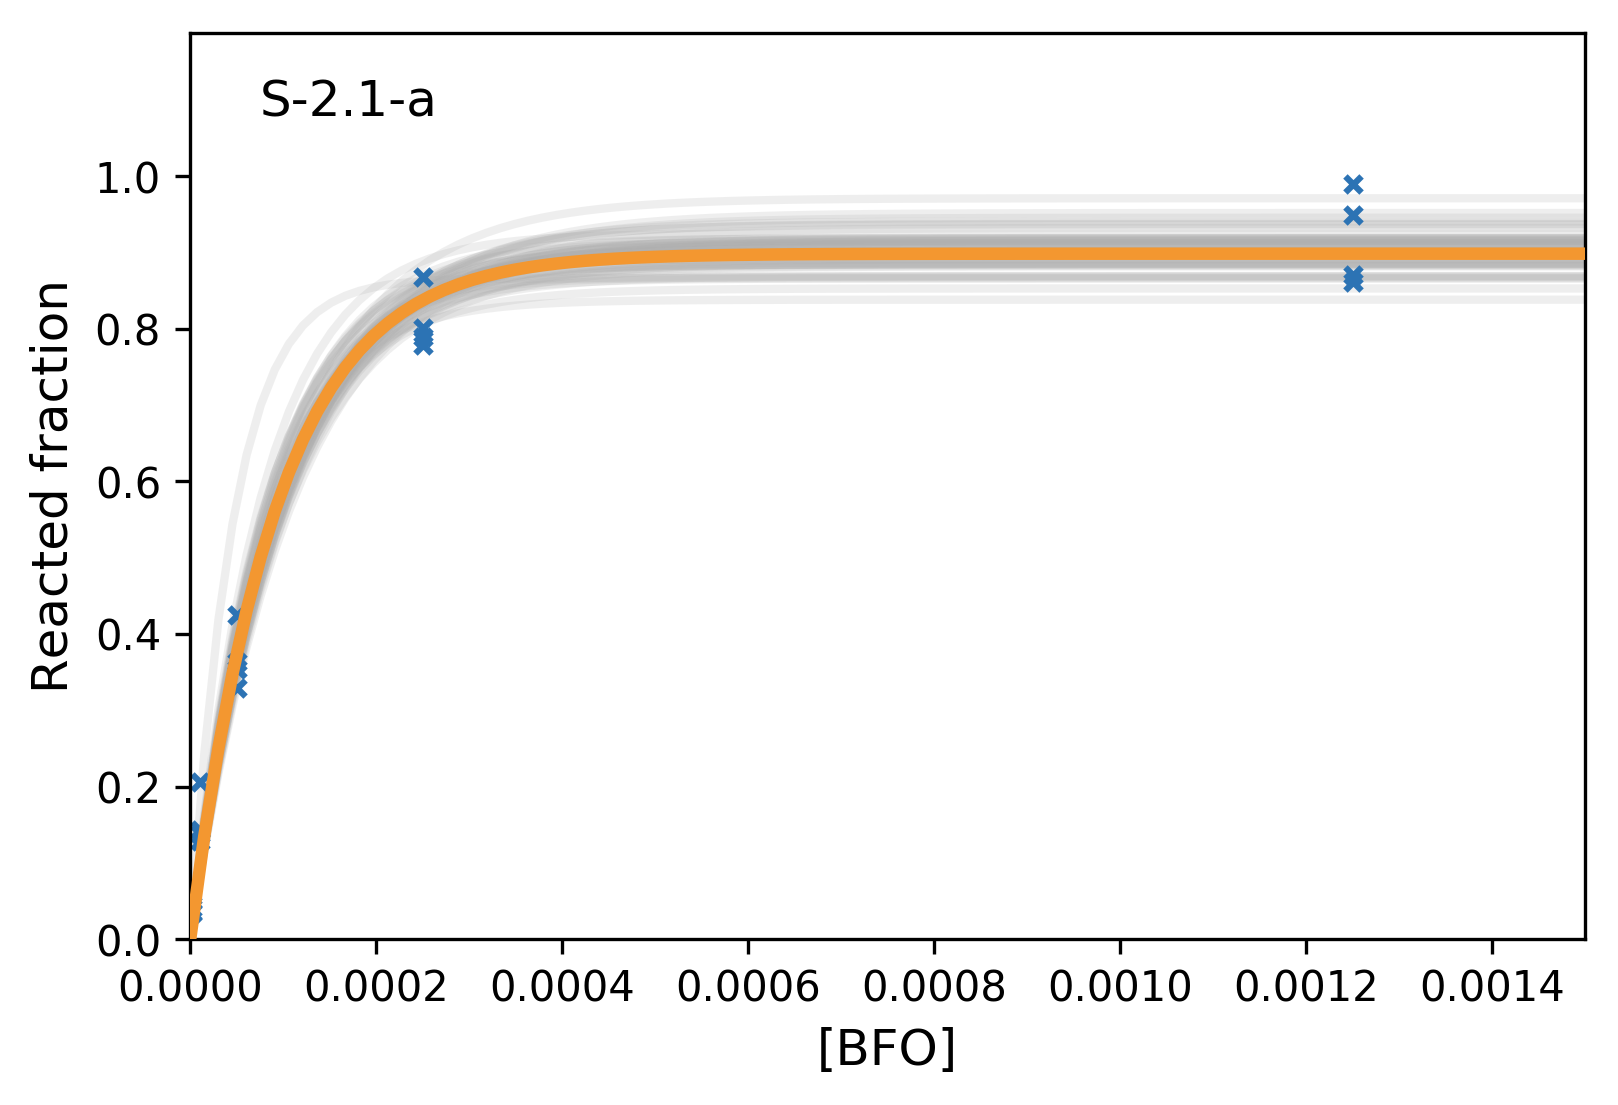

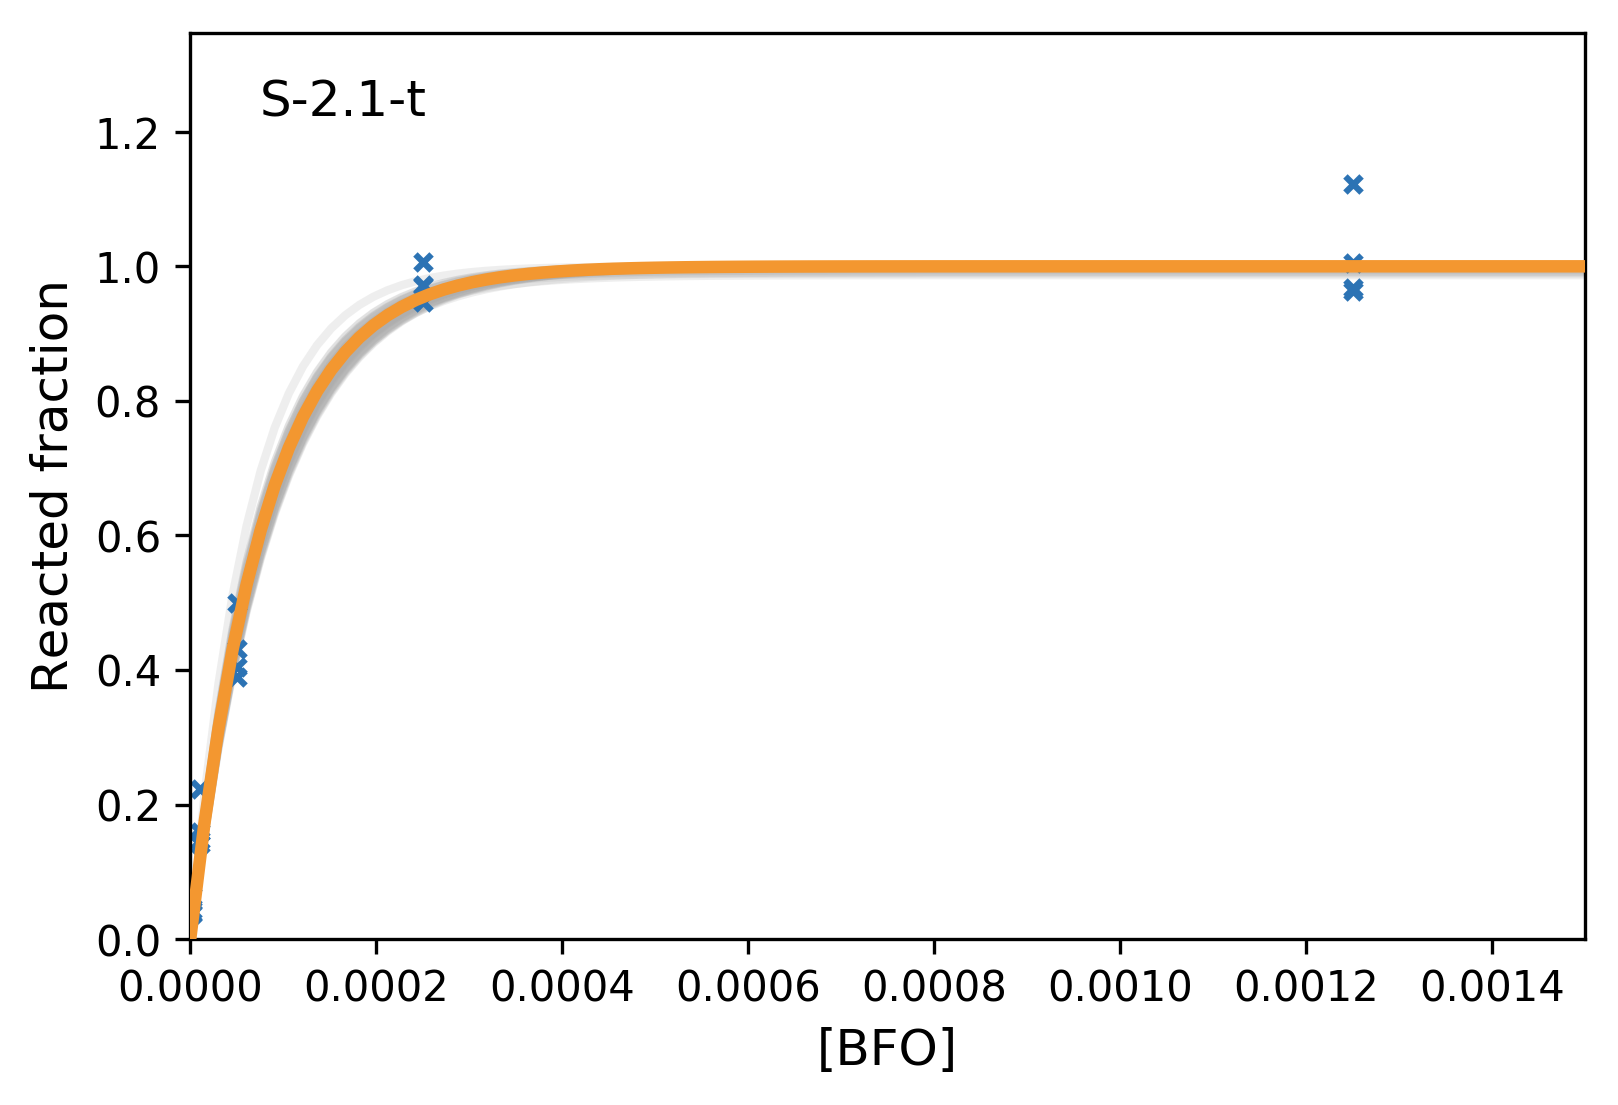

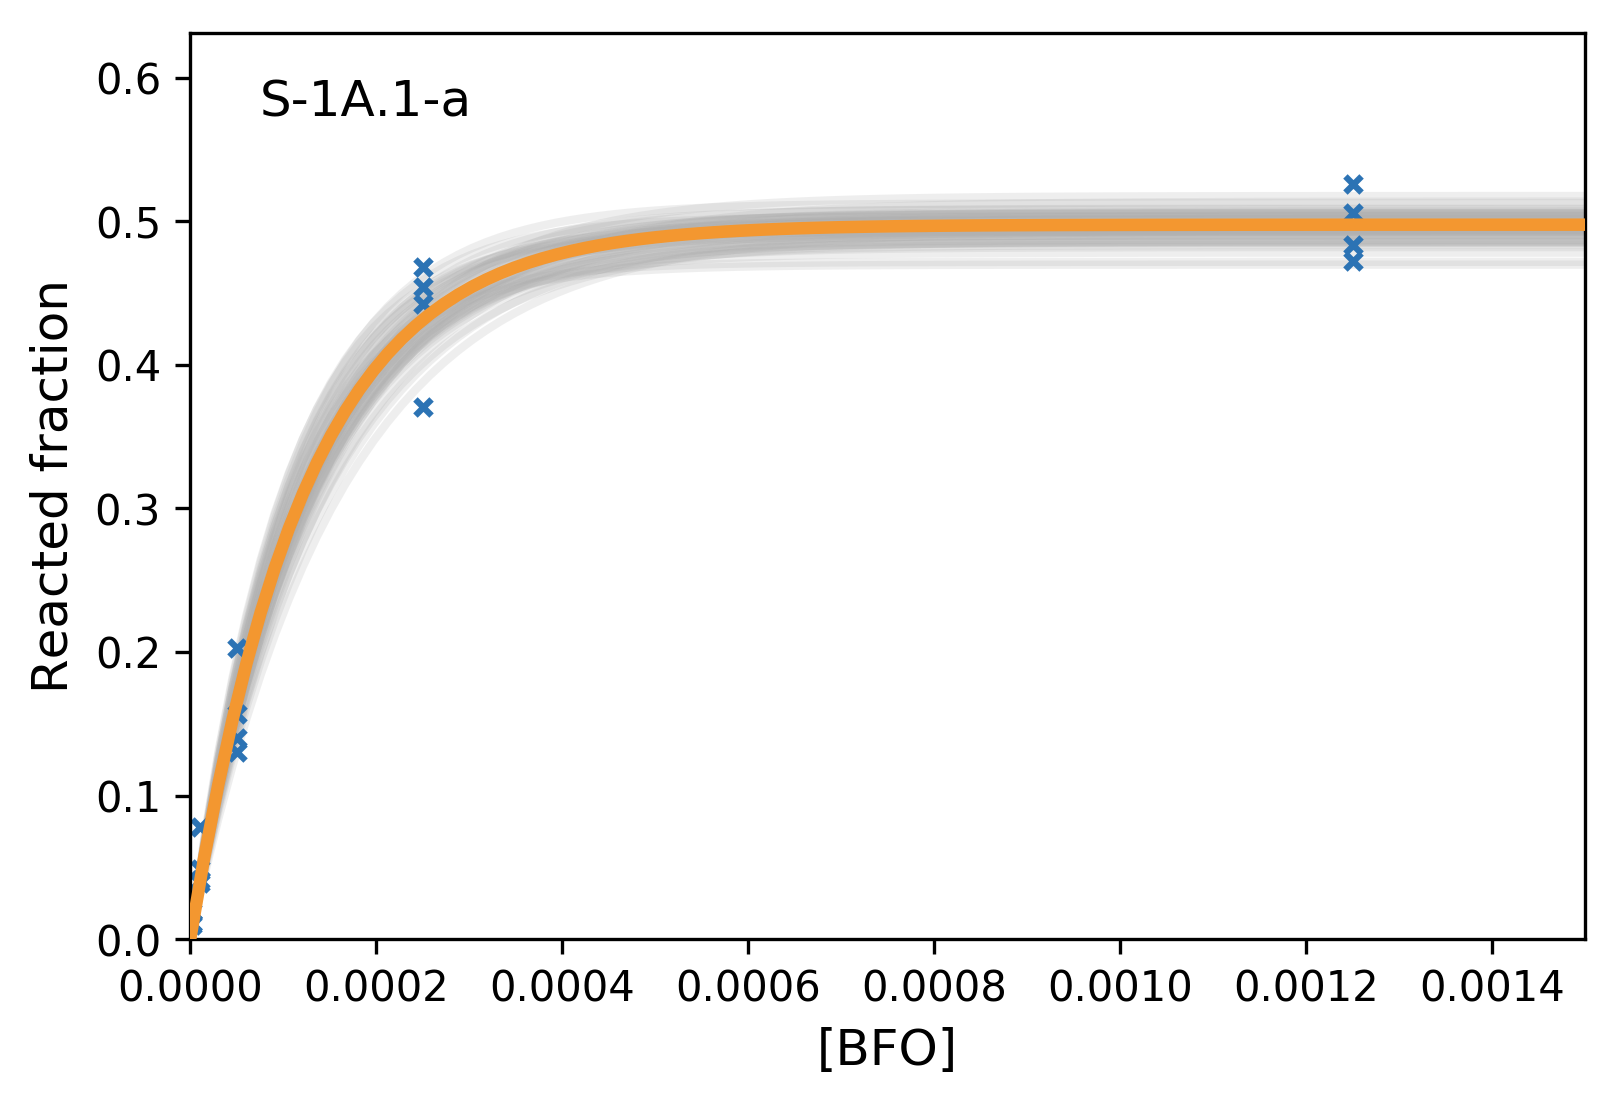

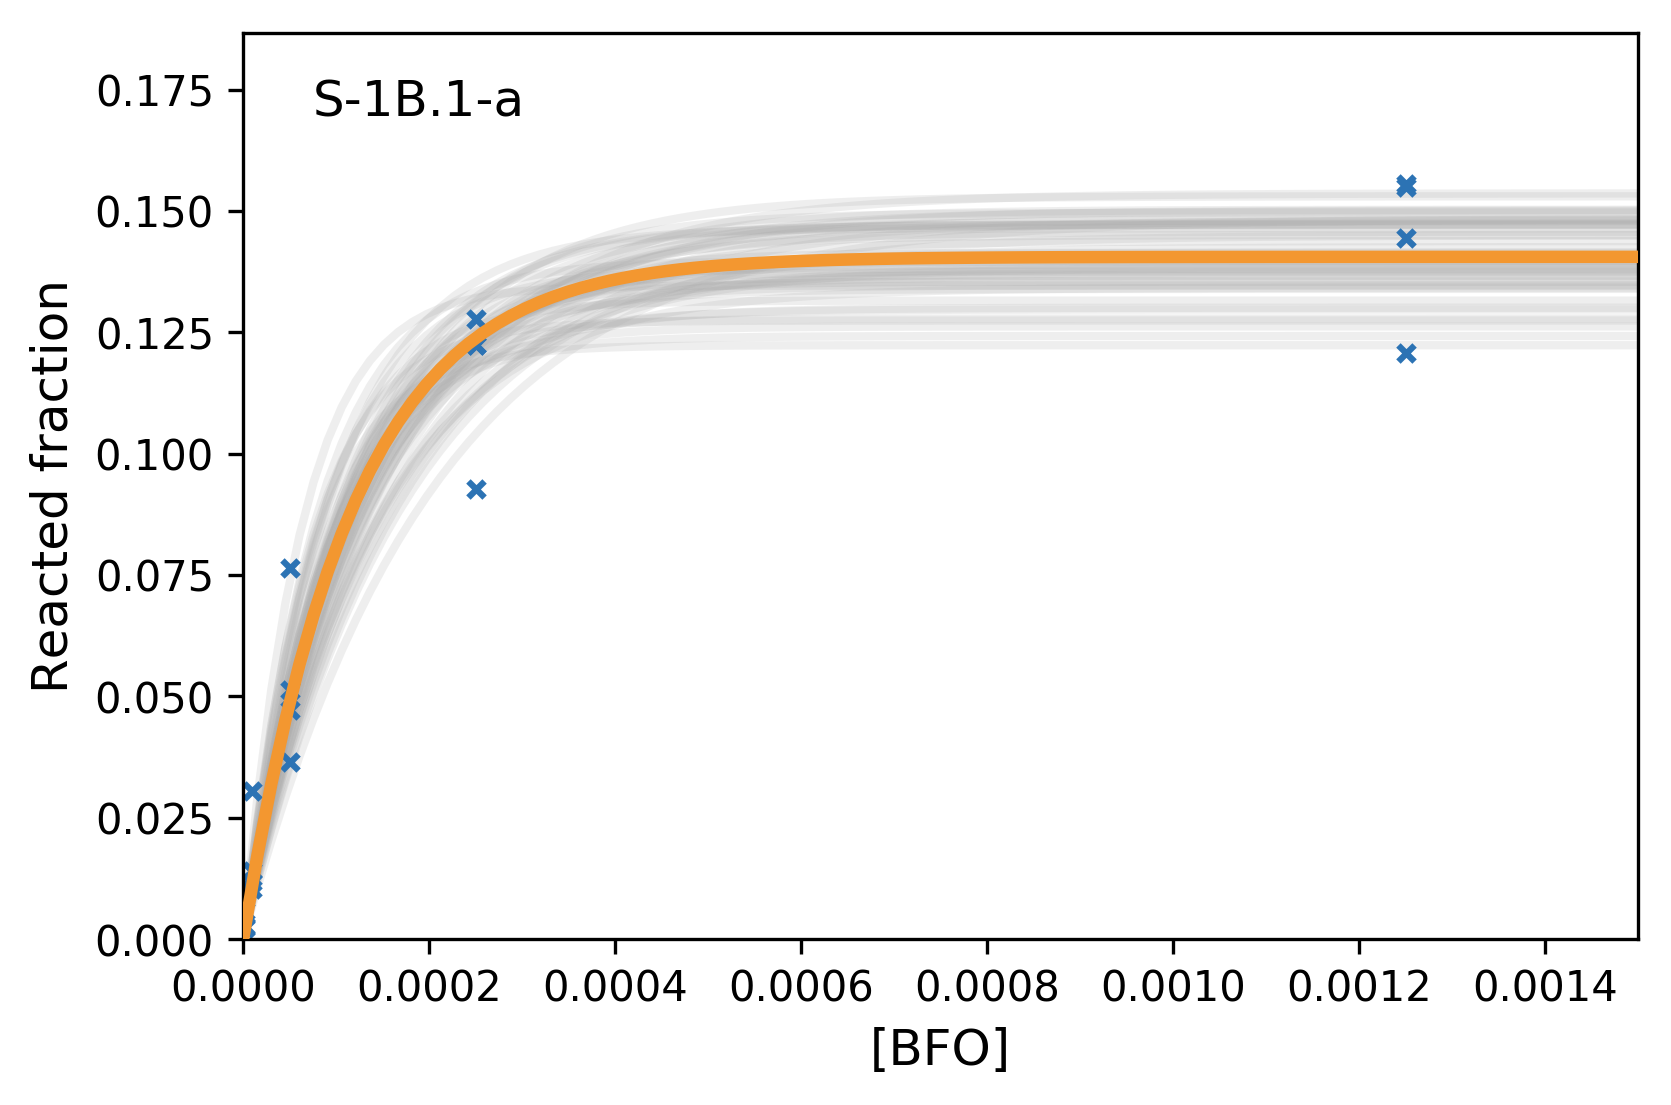

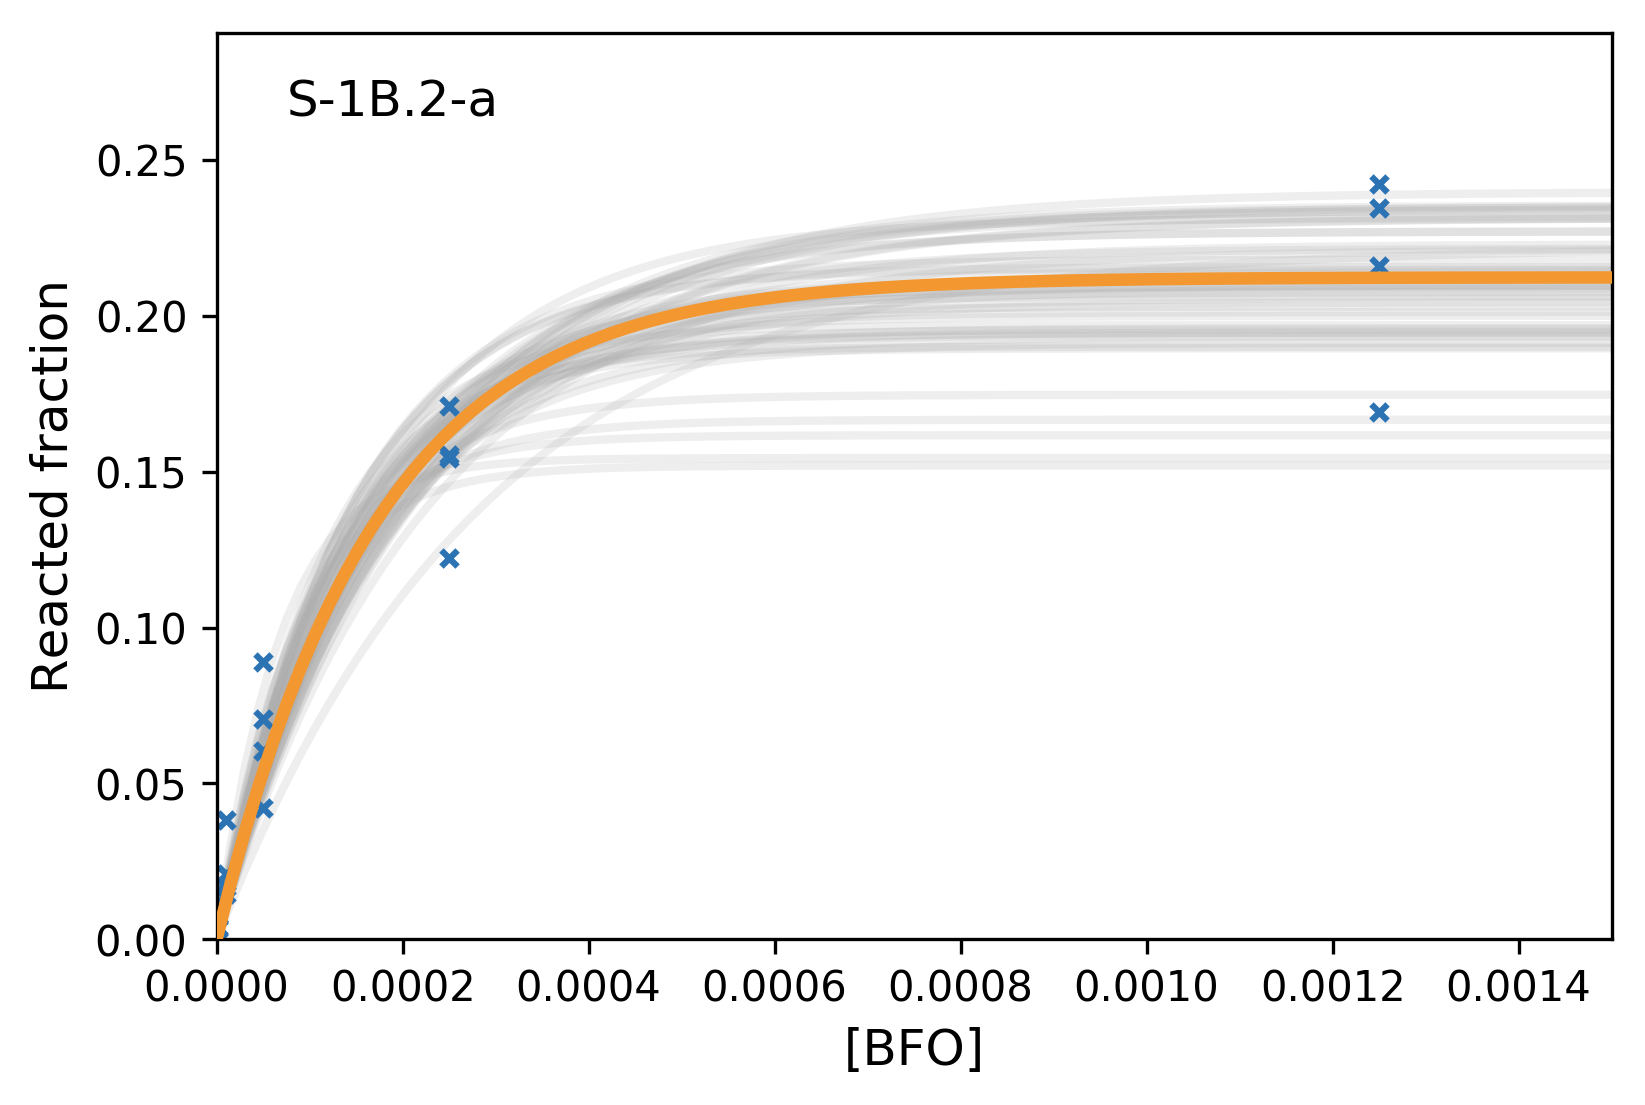

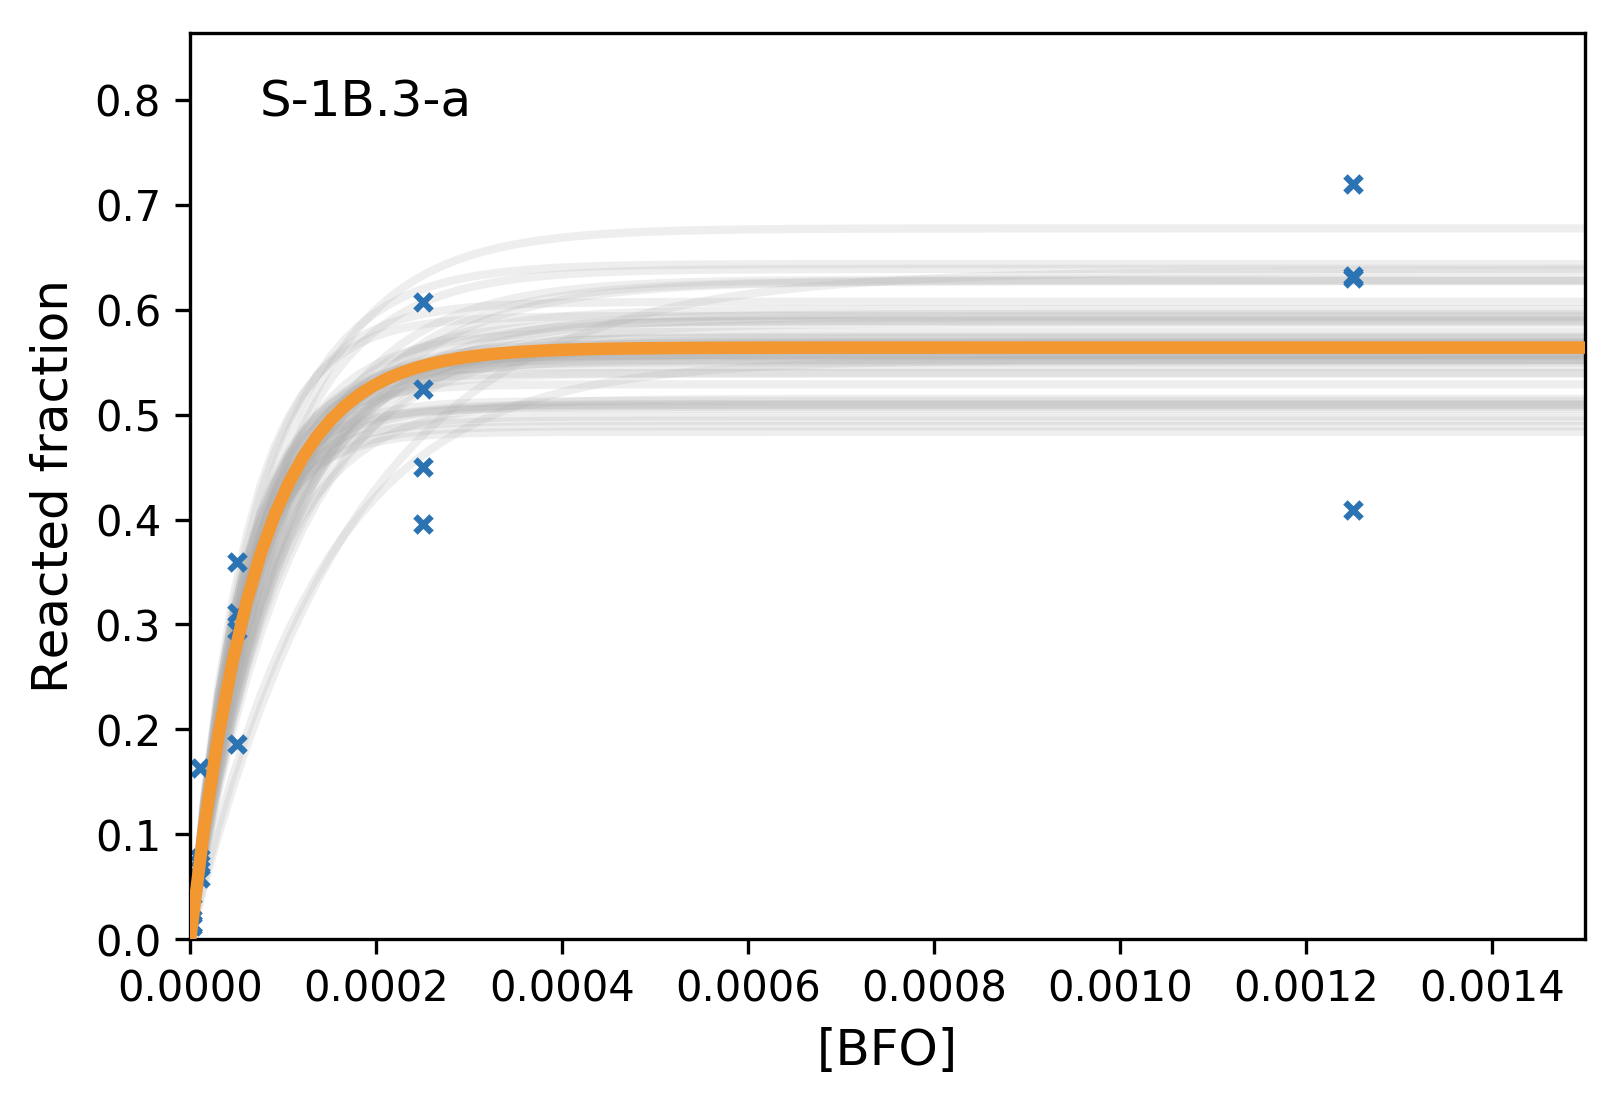

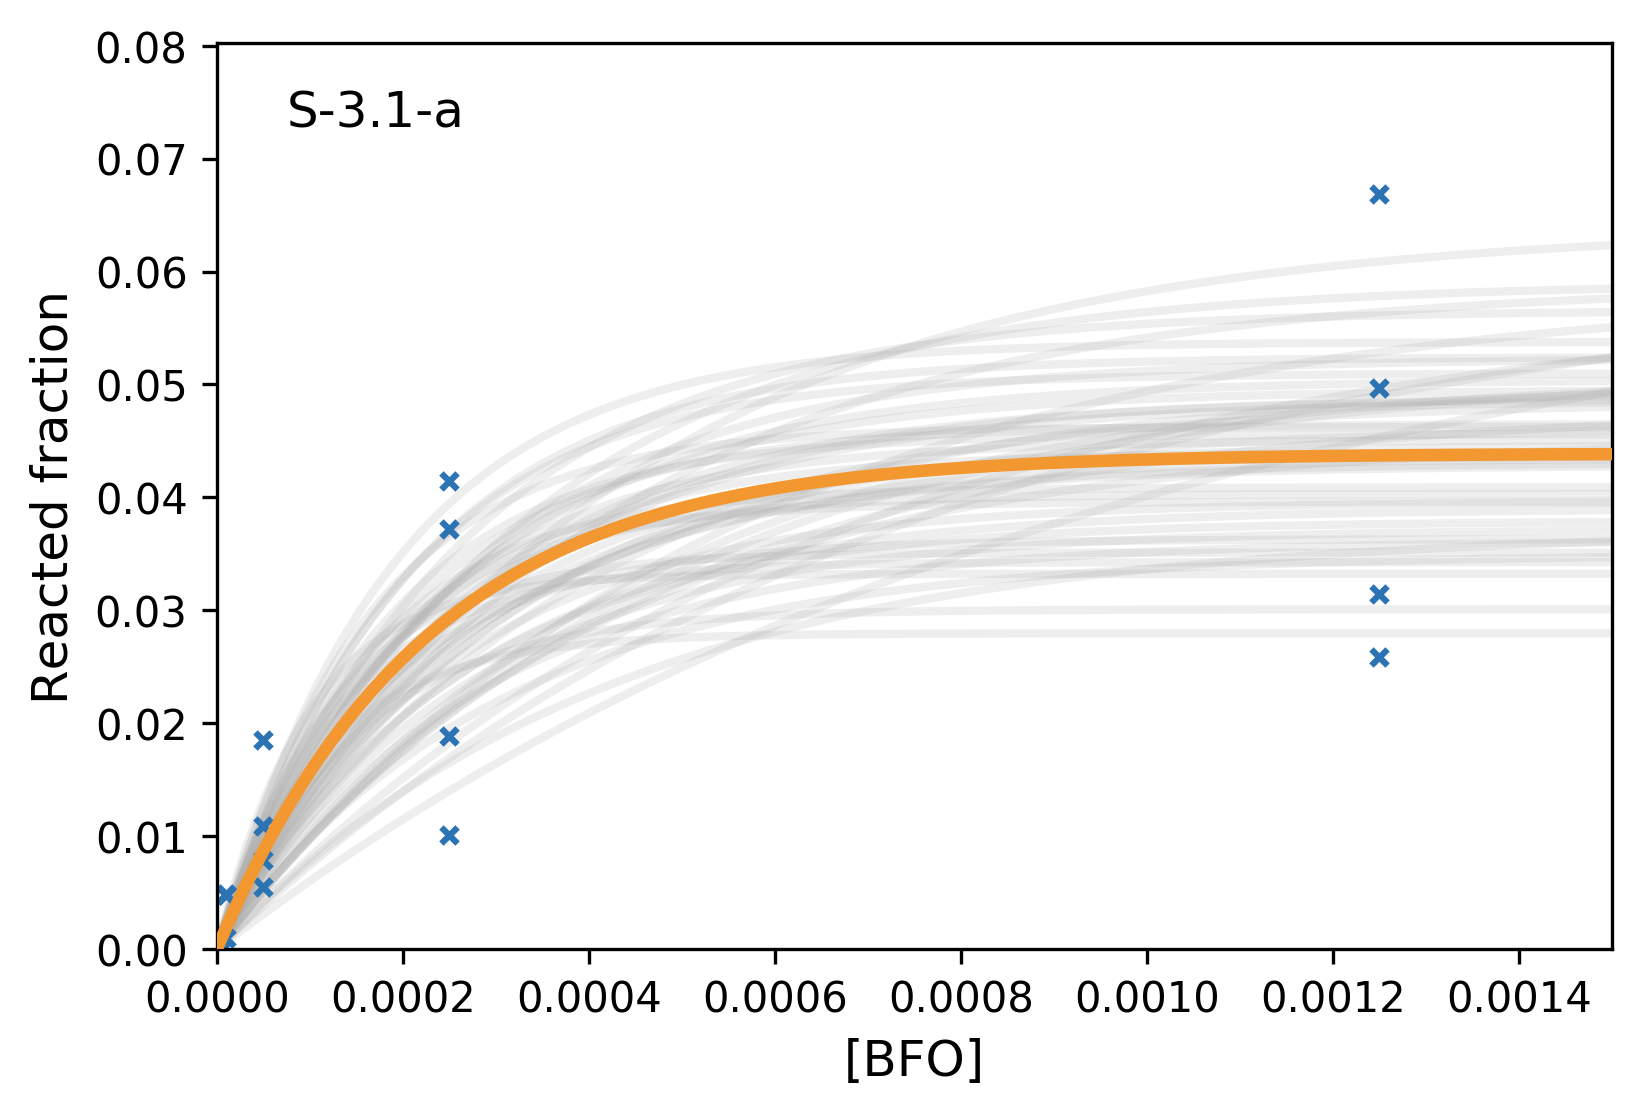

In [47]:
for sample in selected_seq.items():
    plot_fitting_single(seq_res=sample[1]['k_seq_res_bs_2'], func=func,
                        axis_labels=('[BFO]', 'Reacted fraction'),
                        seq_name=sample[0],
                        legend_off=True,
                        save_dirc='/mnt/storage/projects/k-seq/output/bfo_selected_fittings/k_seq_only_{}_wo_legend.jpeg'.format(sample[0]))

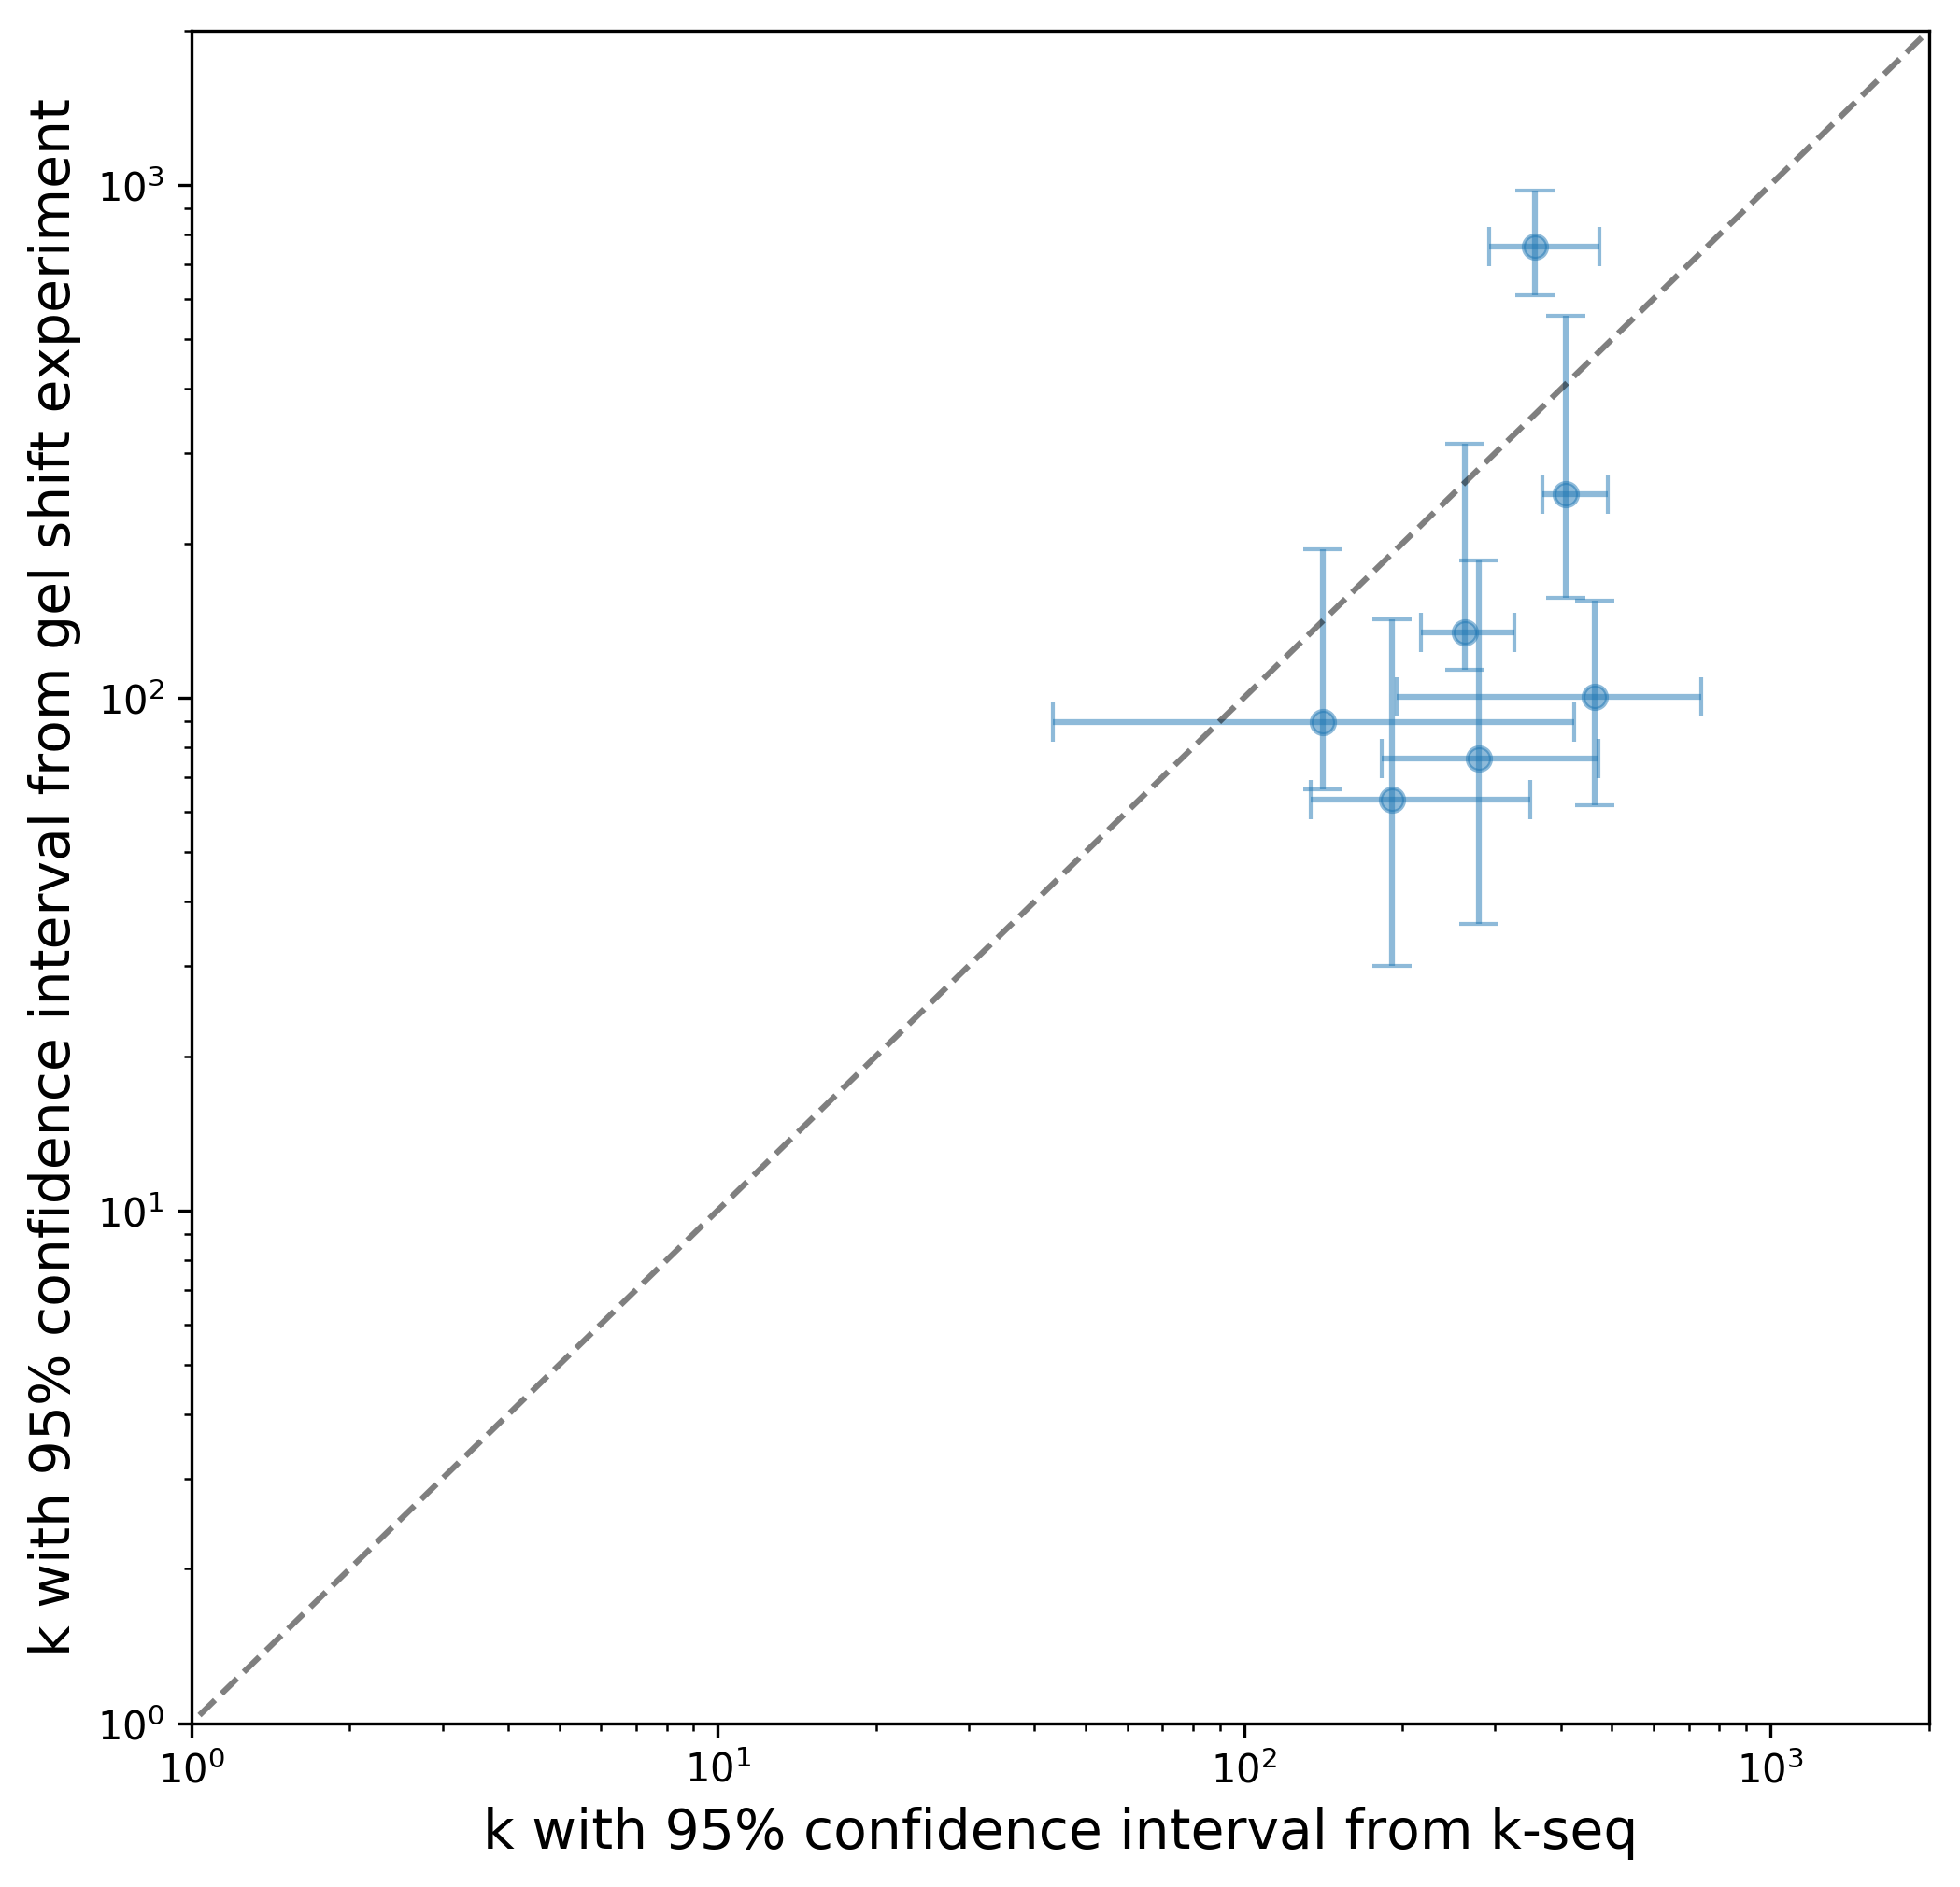

In [381]:
plot_param_alignment(selected_seq, method='bs', param='k', log=True)

In [383]:
for seq in selected_seq.keys():
    print('{}+-{}'.format(selected_seq[seq]['k_seq_res_classic']['point_estimation'][1], selected_seq[seq]['k_seq_res_classic']['sd_estimation'][1]*2/np.sqrt(3)))

354.55850373108507+-98.04184995221482
404.83624831597626+-79.32525233815313
264.0773386875383+-123.61166291691302
277.7028796493548+-344.5129581150551
186.9272771892548+-273.26001667795134
458.768496880749+-757.2387501389352
139.74489409125744+-184.6618699865587


In [382]:
import pprint

for seq in selected_seq.keys():
    print("------------------------------{}-------------------------------".format(seq))
    print(np.std(gel_reacted_frac[seq], axis=0, ddof=1)/np.mean(gel_reacted_frac[seq], axis=0))
    for ix, i in enumerate(selected_seq[seq]['gel_shift_res']['pct_res']):
        if ix%5 == 4:
            print(i)
        else:
            print("{}  ".format(i), end="")
    x_data = selected_seq[seq]['gel_shift_res']['x_data']
    y_data = selected_seq[seq]['gel_shift_res']['y_data']
    plt.scatter(x_data, y_data, marker='o', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    plt.plot(x, func(x, *selected_seq[seq]['gel_shift_res']['params']), color='#FC820D', ls='--', alpha=0.5)
    plt.xlim([-0.0001, 0.002])
    plt.show()

------------------------------S-2.1-a-------------------------------
[0.01283433 0.02905939 0.05679503 0.08184823 0.04091617]


KeyError: 'gel_shift_res'

In [384]:
import matplotlib.pyplot as plt

def func(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x))

fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for ix, seq in enumerate(selected_seq.keys()):
    ax = axes[int(ix/4), ix%4]
    ax.set_title(seq, fontsize=12)
    ### Plot k-seq data
    x_data = [x_series for _ in range(4)]
    x_data = np.reshape(a=x_data, newshape=np.size(x_data))
    y_data = selected_seq[seq]['k_seq_results']['reactedFrac']
    ax.scatter(x_data, y_data, marker='x', color='#2C73B4', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, func(x, selected_seq[seq]['k_seq_results']['params'][0], selected_seq[seq]['k_seq_results']['params'][1]), color='#2C73B4', ls='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.002])
    
    ### Plot gel data
    x_data = selected_seq[seq]['gel_shift_res']['x_data']
    y_data = selected_seq[seq]['gel_shift_res']['y_data']
    ax.scatter(x_data, y_data, marker='o', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, func(x, *selected_seq[seq]['gel_shift_res']['params']), color='#FC820D', ls='--', alpha=0.5)
axes[1, 3].set_axis_off()

plt.tight_layout()
plt.show()

KeyError: 'k_seq_results'

In [259]:
for seq in selected_seq.keys():
    print('{}:{}'.format(seq, list(sequence_set.count_table.loc[selected_seq[seq]['seq']])))
    print()

S-2.1-a:[187328, 404050, 400506, 609256, 365788, 361630, 35141, 130818, 721942, 2164490, 532884, 552783, 458399, 28600, 175288, 315116, 645996, 788838, 865530, 540316, 19330, 158150, 585013, 643909, 610342, 475823, 543003, 242058]

S-2.1-t:[122377, 318137, 342591, 484171, 273069, 264909, 22473, 86778, 530389, 1743335, 434234, 415769, 334349, 19589, 122615, 242093, 542956, 649970, 671806, 414178, 13571, 116200, 456371, 543917, 500790, 363967, 400029, 170455]

S-1A.1-a:[605843, 624126, 546971, 650718, 303851, 281969, 23699, 329164, 1069139, 3391792, 739631, 609722, 411664, 14626, 531449, 497181, 1036256, 988301, 856067, 452499, 10047, 540204, 998197, 1092010, 755244, 444605, 494326, 276180]

S-1B.1-a:[46155, 15868, 11811, 15714, 6933, 5919, 204, 24030, 23038, 76447, 23999, 20505, 11045, 110, 58220, 13124, 25832, 27940, 21260, 9464, 59, 55100, 26474, 25393, 21893, 10914, 9691, 4624]

S-1B.2-a:[2028, 1034, 727, 846, 453, 402, 13, 785, 1508, 4506, 1304, 1199, 686, 5, 2947, 996, 1615, 1796, 

------------------------------S-2.1-a-------------------------------
[0.01283433 0.02905939 0.05679503 0.08184823 0.04091617]
0.08523311154950572  -0.06663275038062208  0.0019614104369632002  0.32045382169206144  0.8046748652990724
0.061569017067882245  -0.10264693567806947  -0.09876264580524398  0.1304199388035908  0.6659991431859039
0.08580136371913197  -0.04994313765958133  -0.011201088052748762  0.28996857908447854  0.7115970920997958


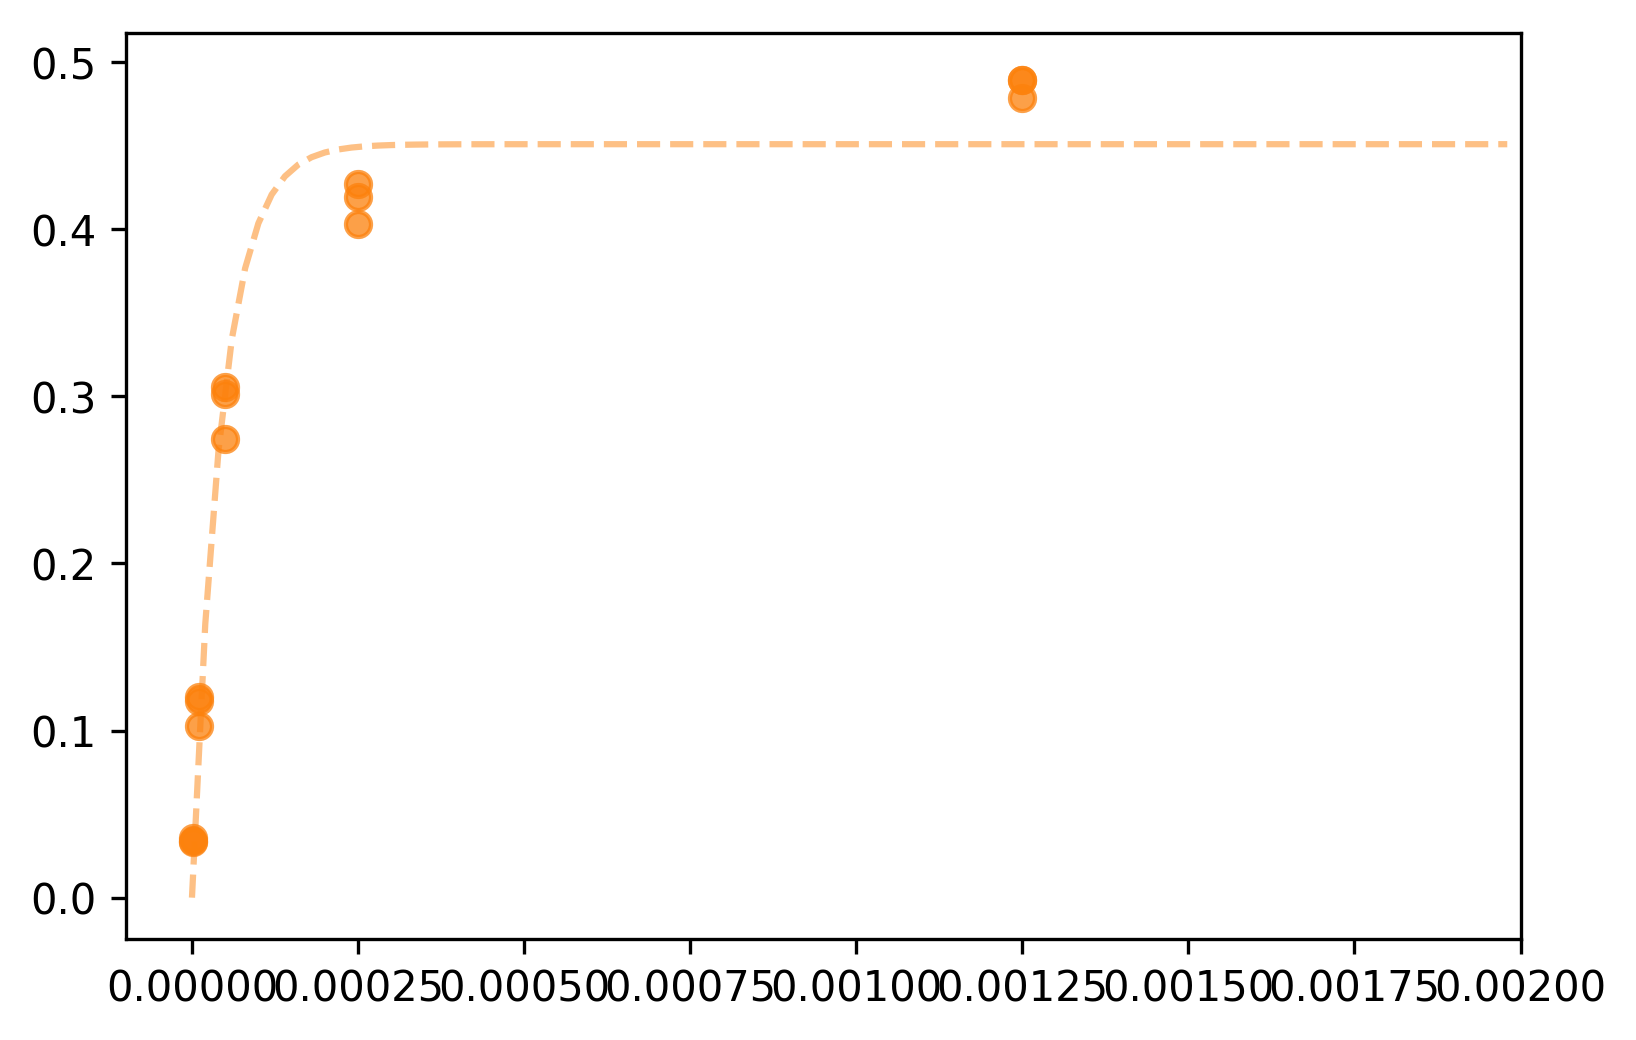

------------------------------S-2.1-t-------------------------------
[0.03653808 0.06642322 0.05916373 0.16115388 0.27364331]
0.11892085016284233  -0.05919790089875334  0.5660214468512264  2.3638209193147097  8.16629898109764
0.03466209333725198  -0.16195094288867035  0.4030104781065264  1.3233779115471427  3.090958633306892
0.04536065781560793  -0.17416669157929715  0.3262915476359354  1.284635583652446  4.152537029126901
0.09971540187152242  -0.1536068311169229  0.48977414358237564  1.9138865719666687  5.426153082851839
0.025274736655821188  -0.22542435323201138  0.4276727832560477  1.885368763524519  5.21561008055406
0.03997887030619839  -0.18930188372268153  0.5139491443446662  2.277192355969403  5.155499886585289


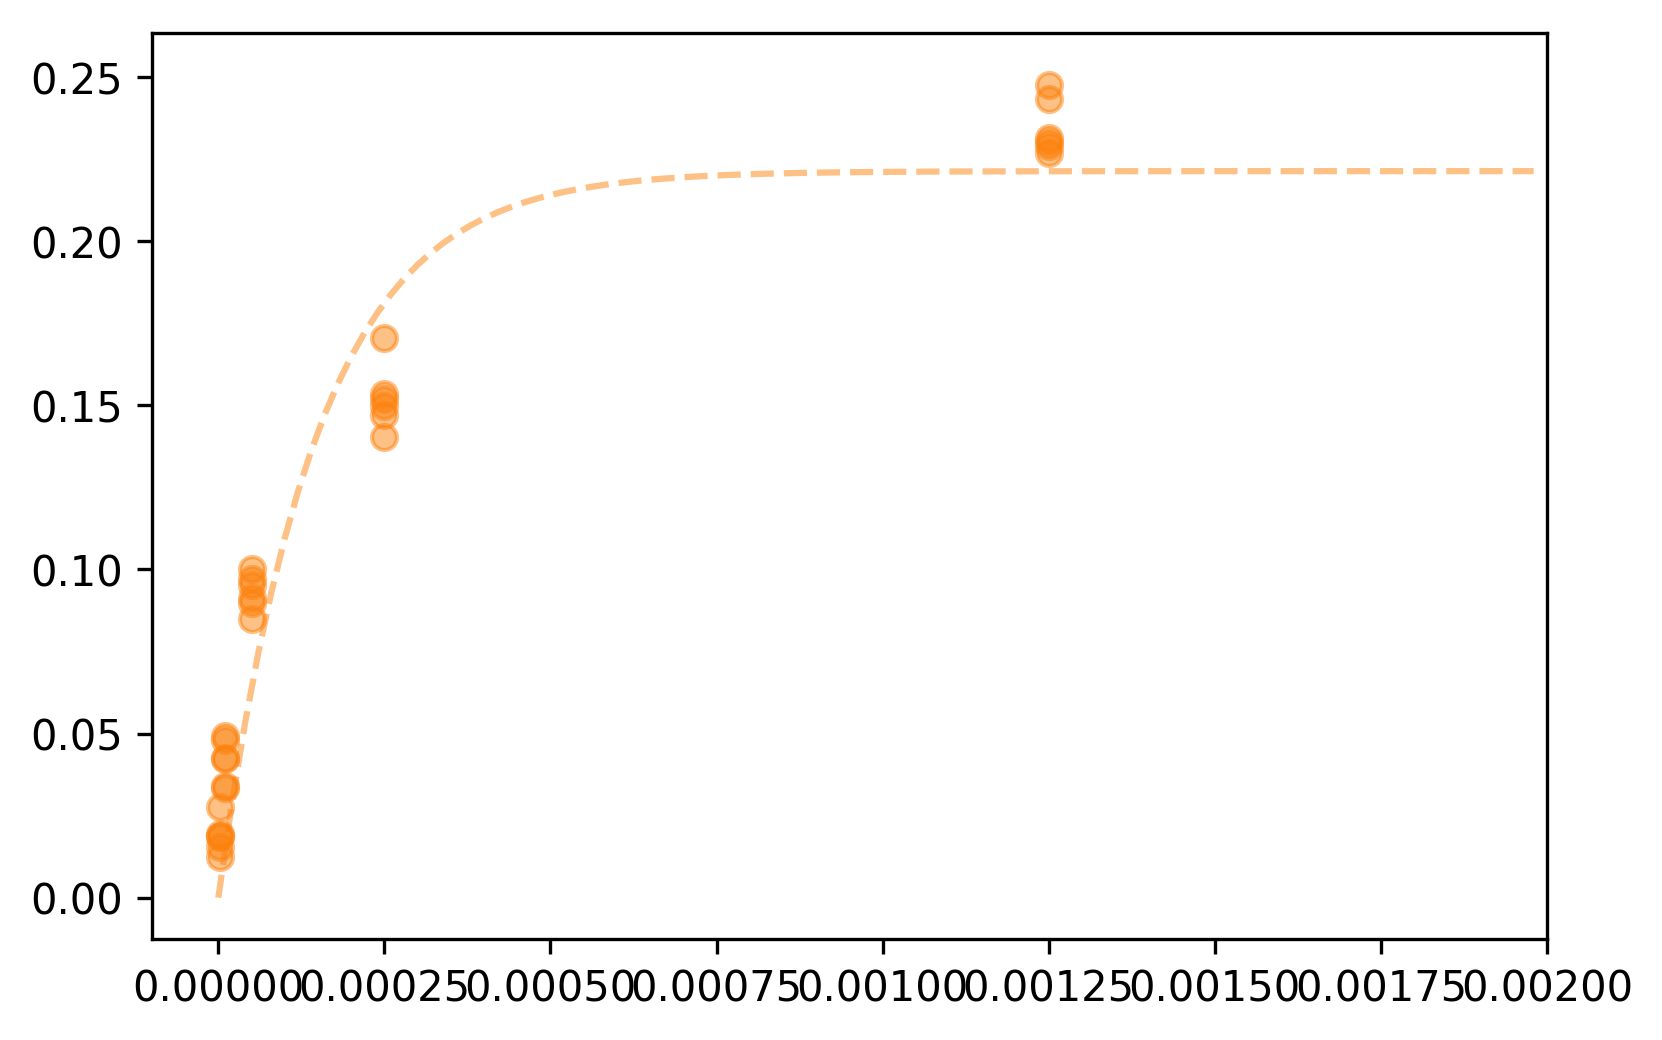

------------------------------S-1A.1-a-------------------------------
[0.02859583 0.06281947 0.29409743 0.51966634 0.54288644]
0.040786545351580515  -0.0007104862720845904  0.6399951403346813  4.308531462757867  21.60102952654809
-0.005132618963261071  -0.11609162974230558  -0.06272082530671609  1.2201530067354758  8.27976728533952
-0.012339477094700419  -0.03173813210581469  0.1286321218403117  1.4314548829256566  8.805959600174537


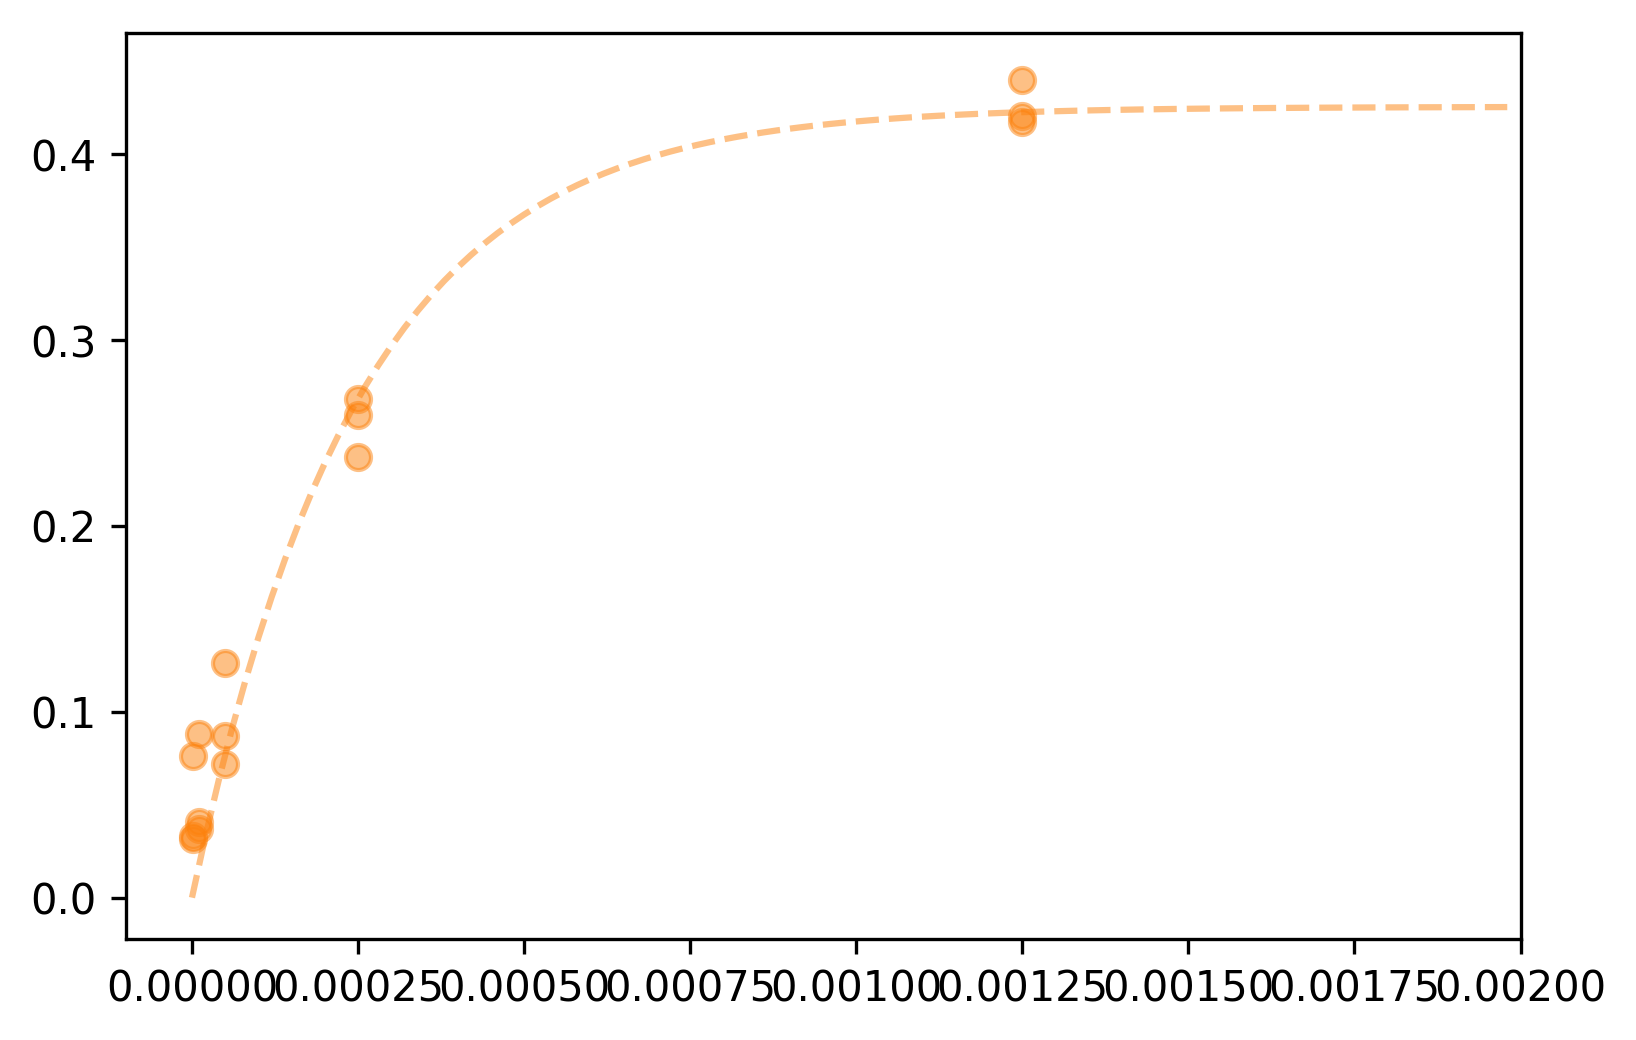

------------------------------S-1B.1-a-------------------------------
[0.15918132 0.28236686 0.27549079 0.05925294 0.66885077]
0.04079777276368118  0.019672257610198002  0.5333149249583198  2.0515059313411874  1.257880614145841
0.13812035311200266  0.21056241397261663  0.4831092670796798  1.7223567553193384  6.909503562832931
-0.17356877846103014  -0.3281681878338364  -0.11137980395744104  1.8155931002749817  11.200988138194155


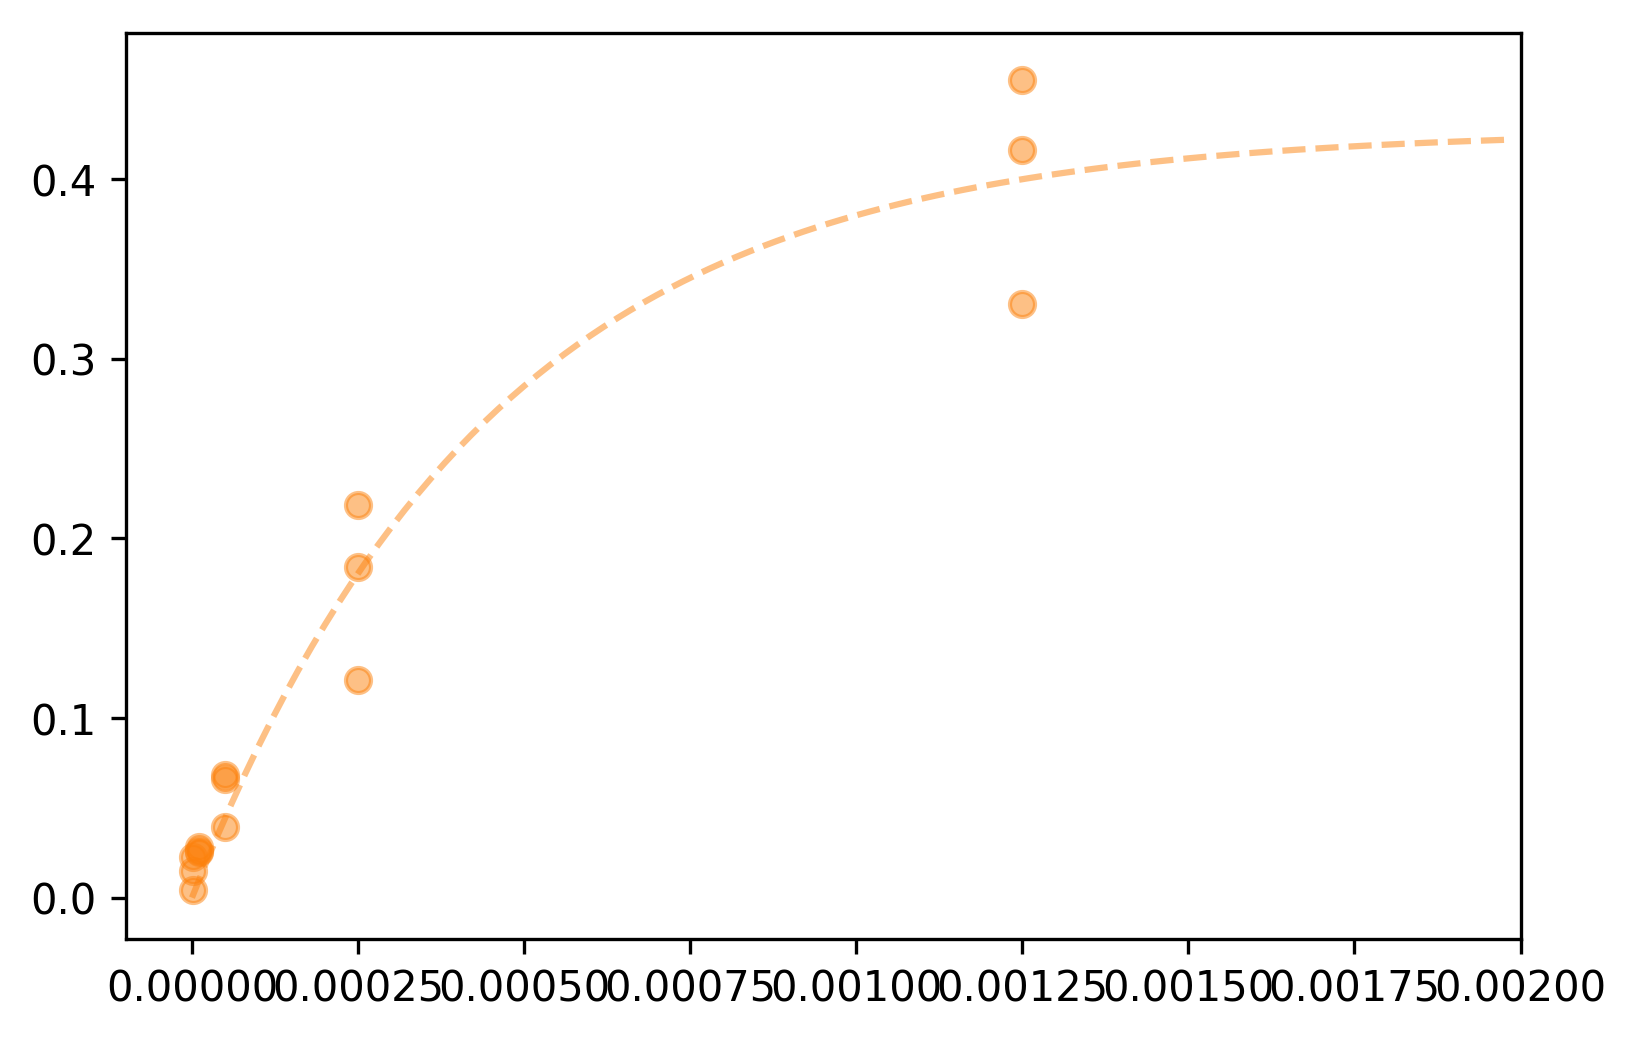

------------------------------S-1B.2-a-------------------------------
[0.19960049 0.28567269 0.16805393 0.21308271 0.28389678]
0.05674374989894209  0.027006032637489998  0.4027488418150345  3.30387530919558  19.105969487064705
0.16789815784565085  0.2076091473395652  0.4386519129458562  1.782478746421287  10.119960939120595
-0.2202518264177663  -0.3346901635365698  0.04491127719605397  2.7245919796374647  15.986641670424273


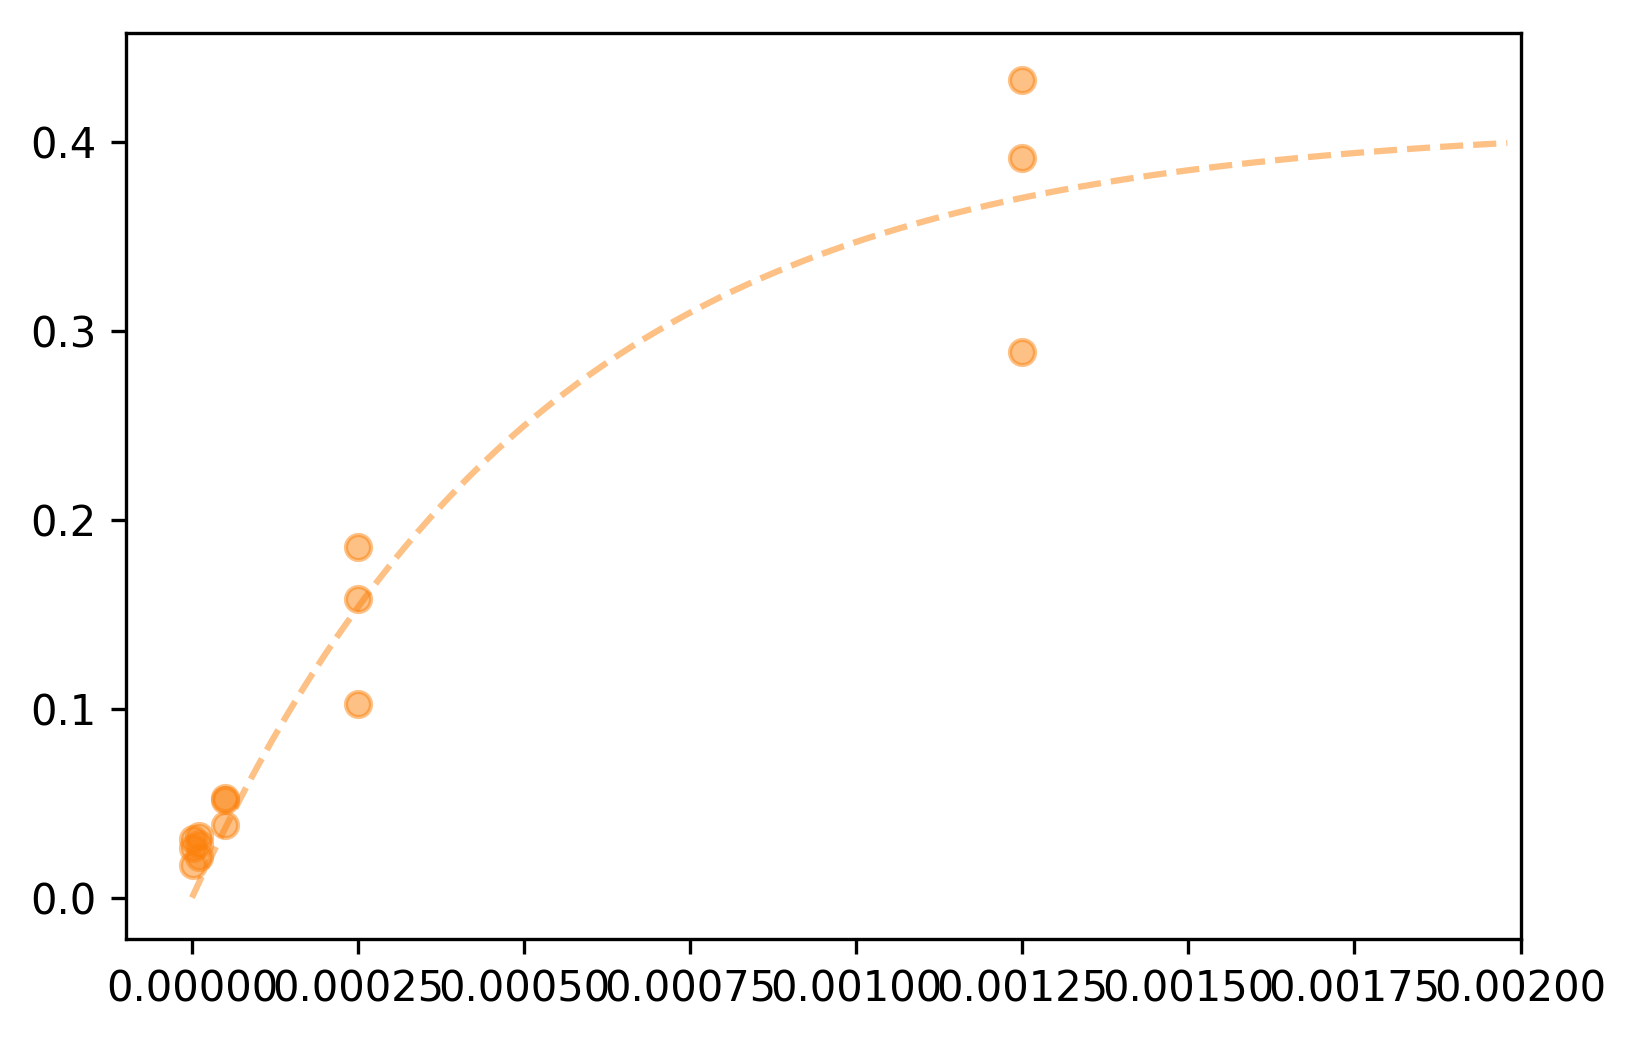

------------------------------S-1B.3-a-------------------------------
[0.16806901 0.29513477 0.2588336  0.160087   0.17032253]
-0.08125876541644107  -0.1688741745864736  0.1145268310714372  1.8207510360284174  10.26777096722902
0.022964086994019757  -0.029474494131514952  0.37199024847591616  1.5004247233441461  6.77818935231517
-0.23836575967105747  -0.44526953706250305  -0.21560261545991455  1.579222701000701  10.262672332461891
0.17313854296690365  0.23101245288279287  0.48942195471519745  2.0240727825202276  9.690842300598595
0.14115081139357144  0.2202417774954238  0.6117694790697776  2.6685835407719396  11.762367440007495


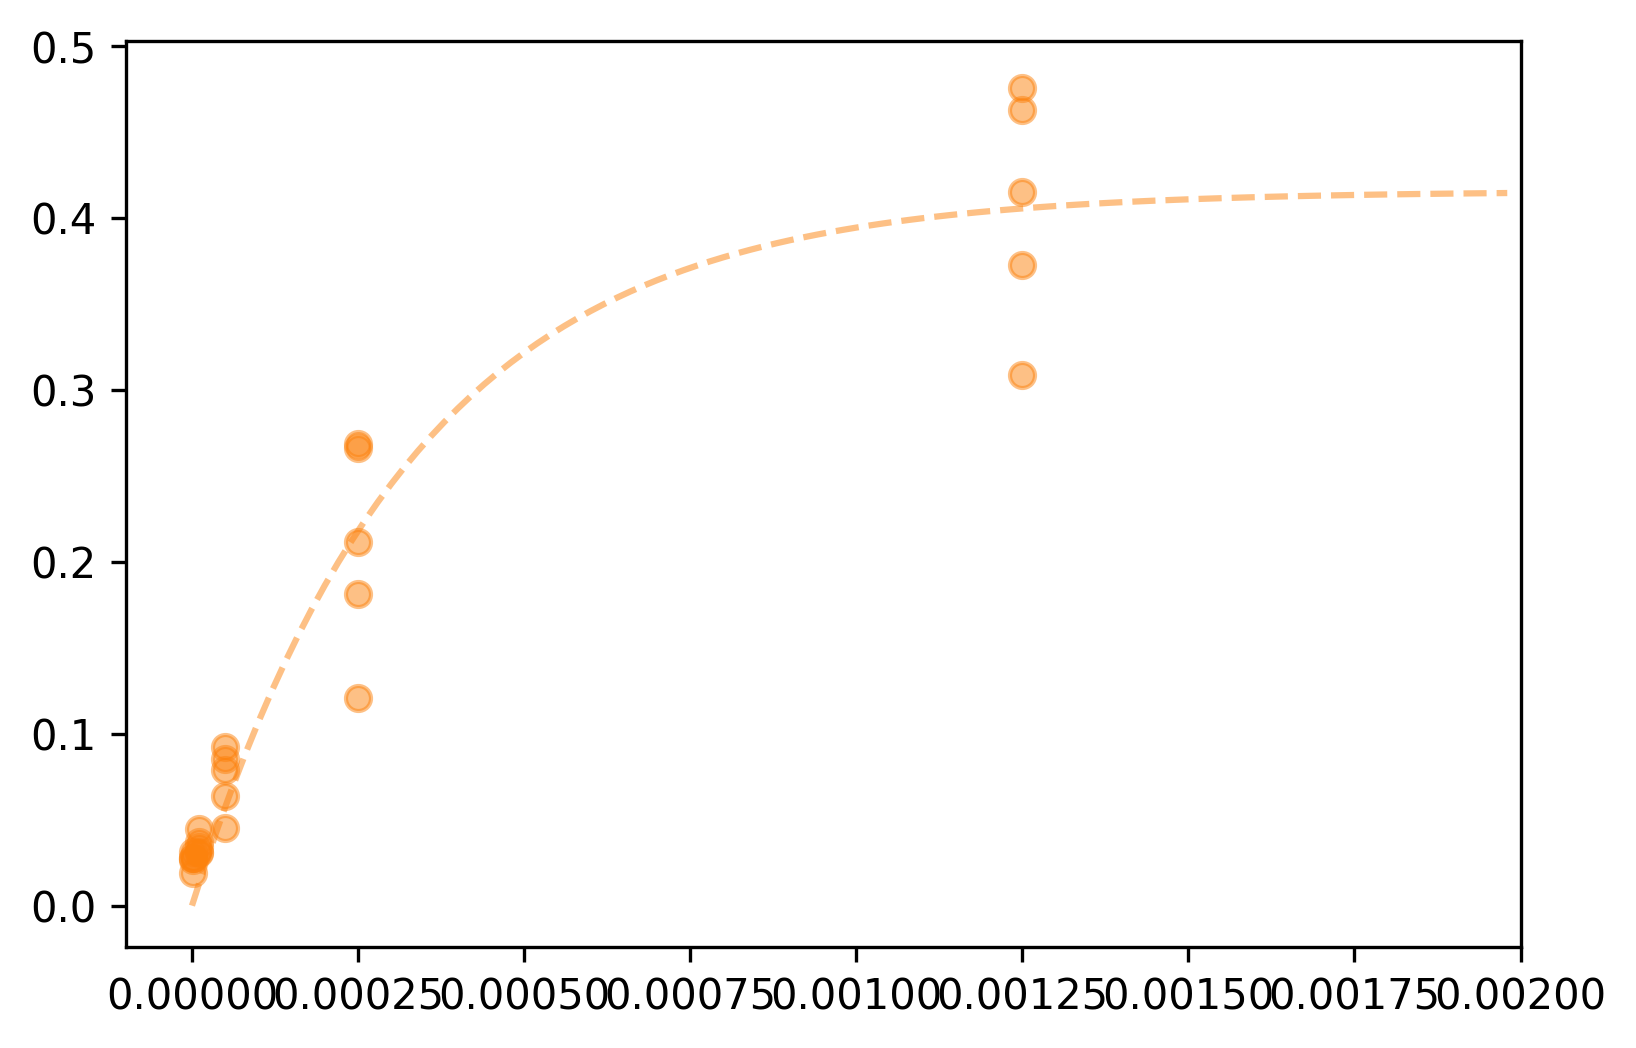

------------------------------S-3.1-a-------------------------------
[0.0531463  0.16461677 0.17109241 0.07267293 0.06041954]
-0.059262884662807346  -0.2114152537482263  -0.02598042264597562  1.2839003161364748  8.131422072663634
0.03645248809848633  0.050511562048375584  0.29078753959219045  1.5101275658589846  7.558059884383681
0.02906561328261958  0.07914469890023916  0.3629683139246217  1.6397054350707507  8.659350098690219


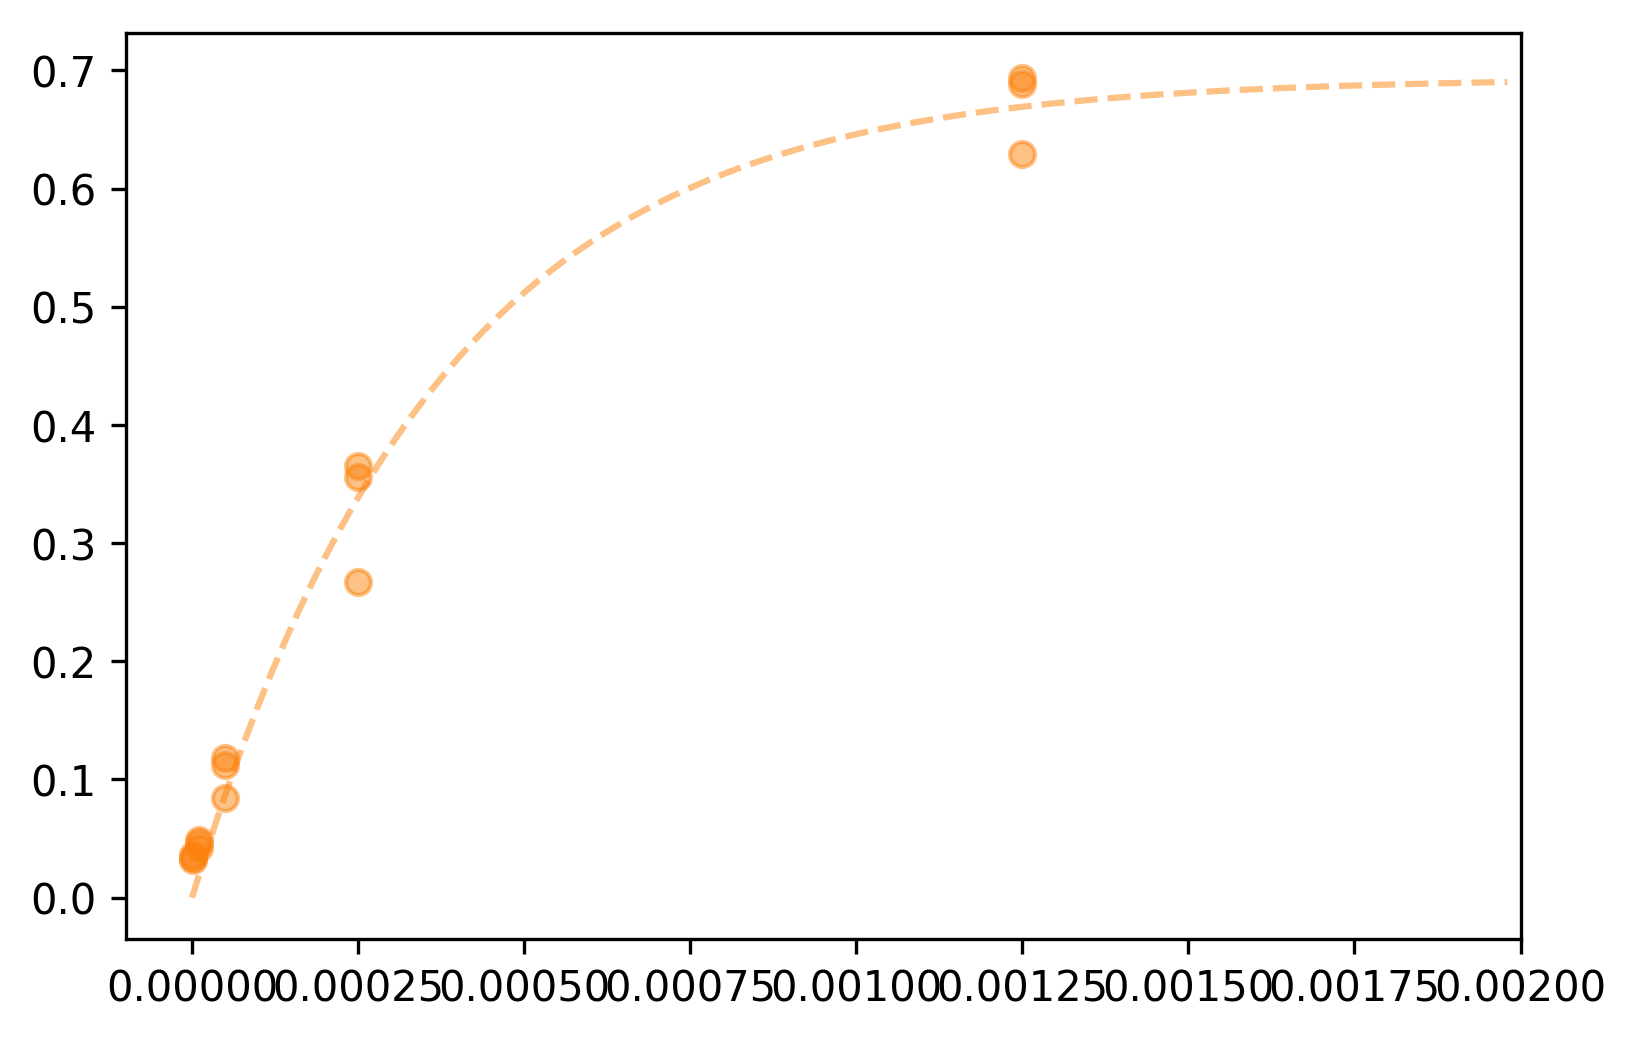

In [248]:
import pprint

for seq in selected_seq.keys():
    print("------------------------------{}-------------------------------".format(seq))
    print(np.std(gel_reacted_frac[seq], axis=0, ddof=1)/np.mean(gel_reacted_frac[seq], axis=0))
    for ix, i in enumerate(selected_seq[seq]['gel_shift_res']['pct_res']):
        if ix%5 == 4:
            print(i)
        else:
            print("{}  ".format(i), end="")
    x_data = selected_seq[seq]['gel_shift_res']['x_data']
    y_data = selected_seq[seq]['gel_shift_res']['y_data']
    plt.scatter(x_data, y_data, marker='o', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    plt.plot(x, func(x, *selected_seq[seq]['gel_shift_res']['params'][:2]), color='#FC820D', ls='--', alpha=0.5)
    plt.xlim([-0.0001, 0.002])
    plt.show()

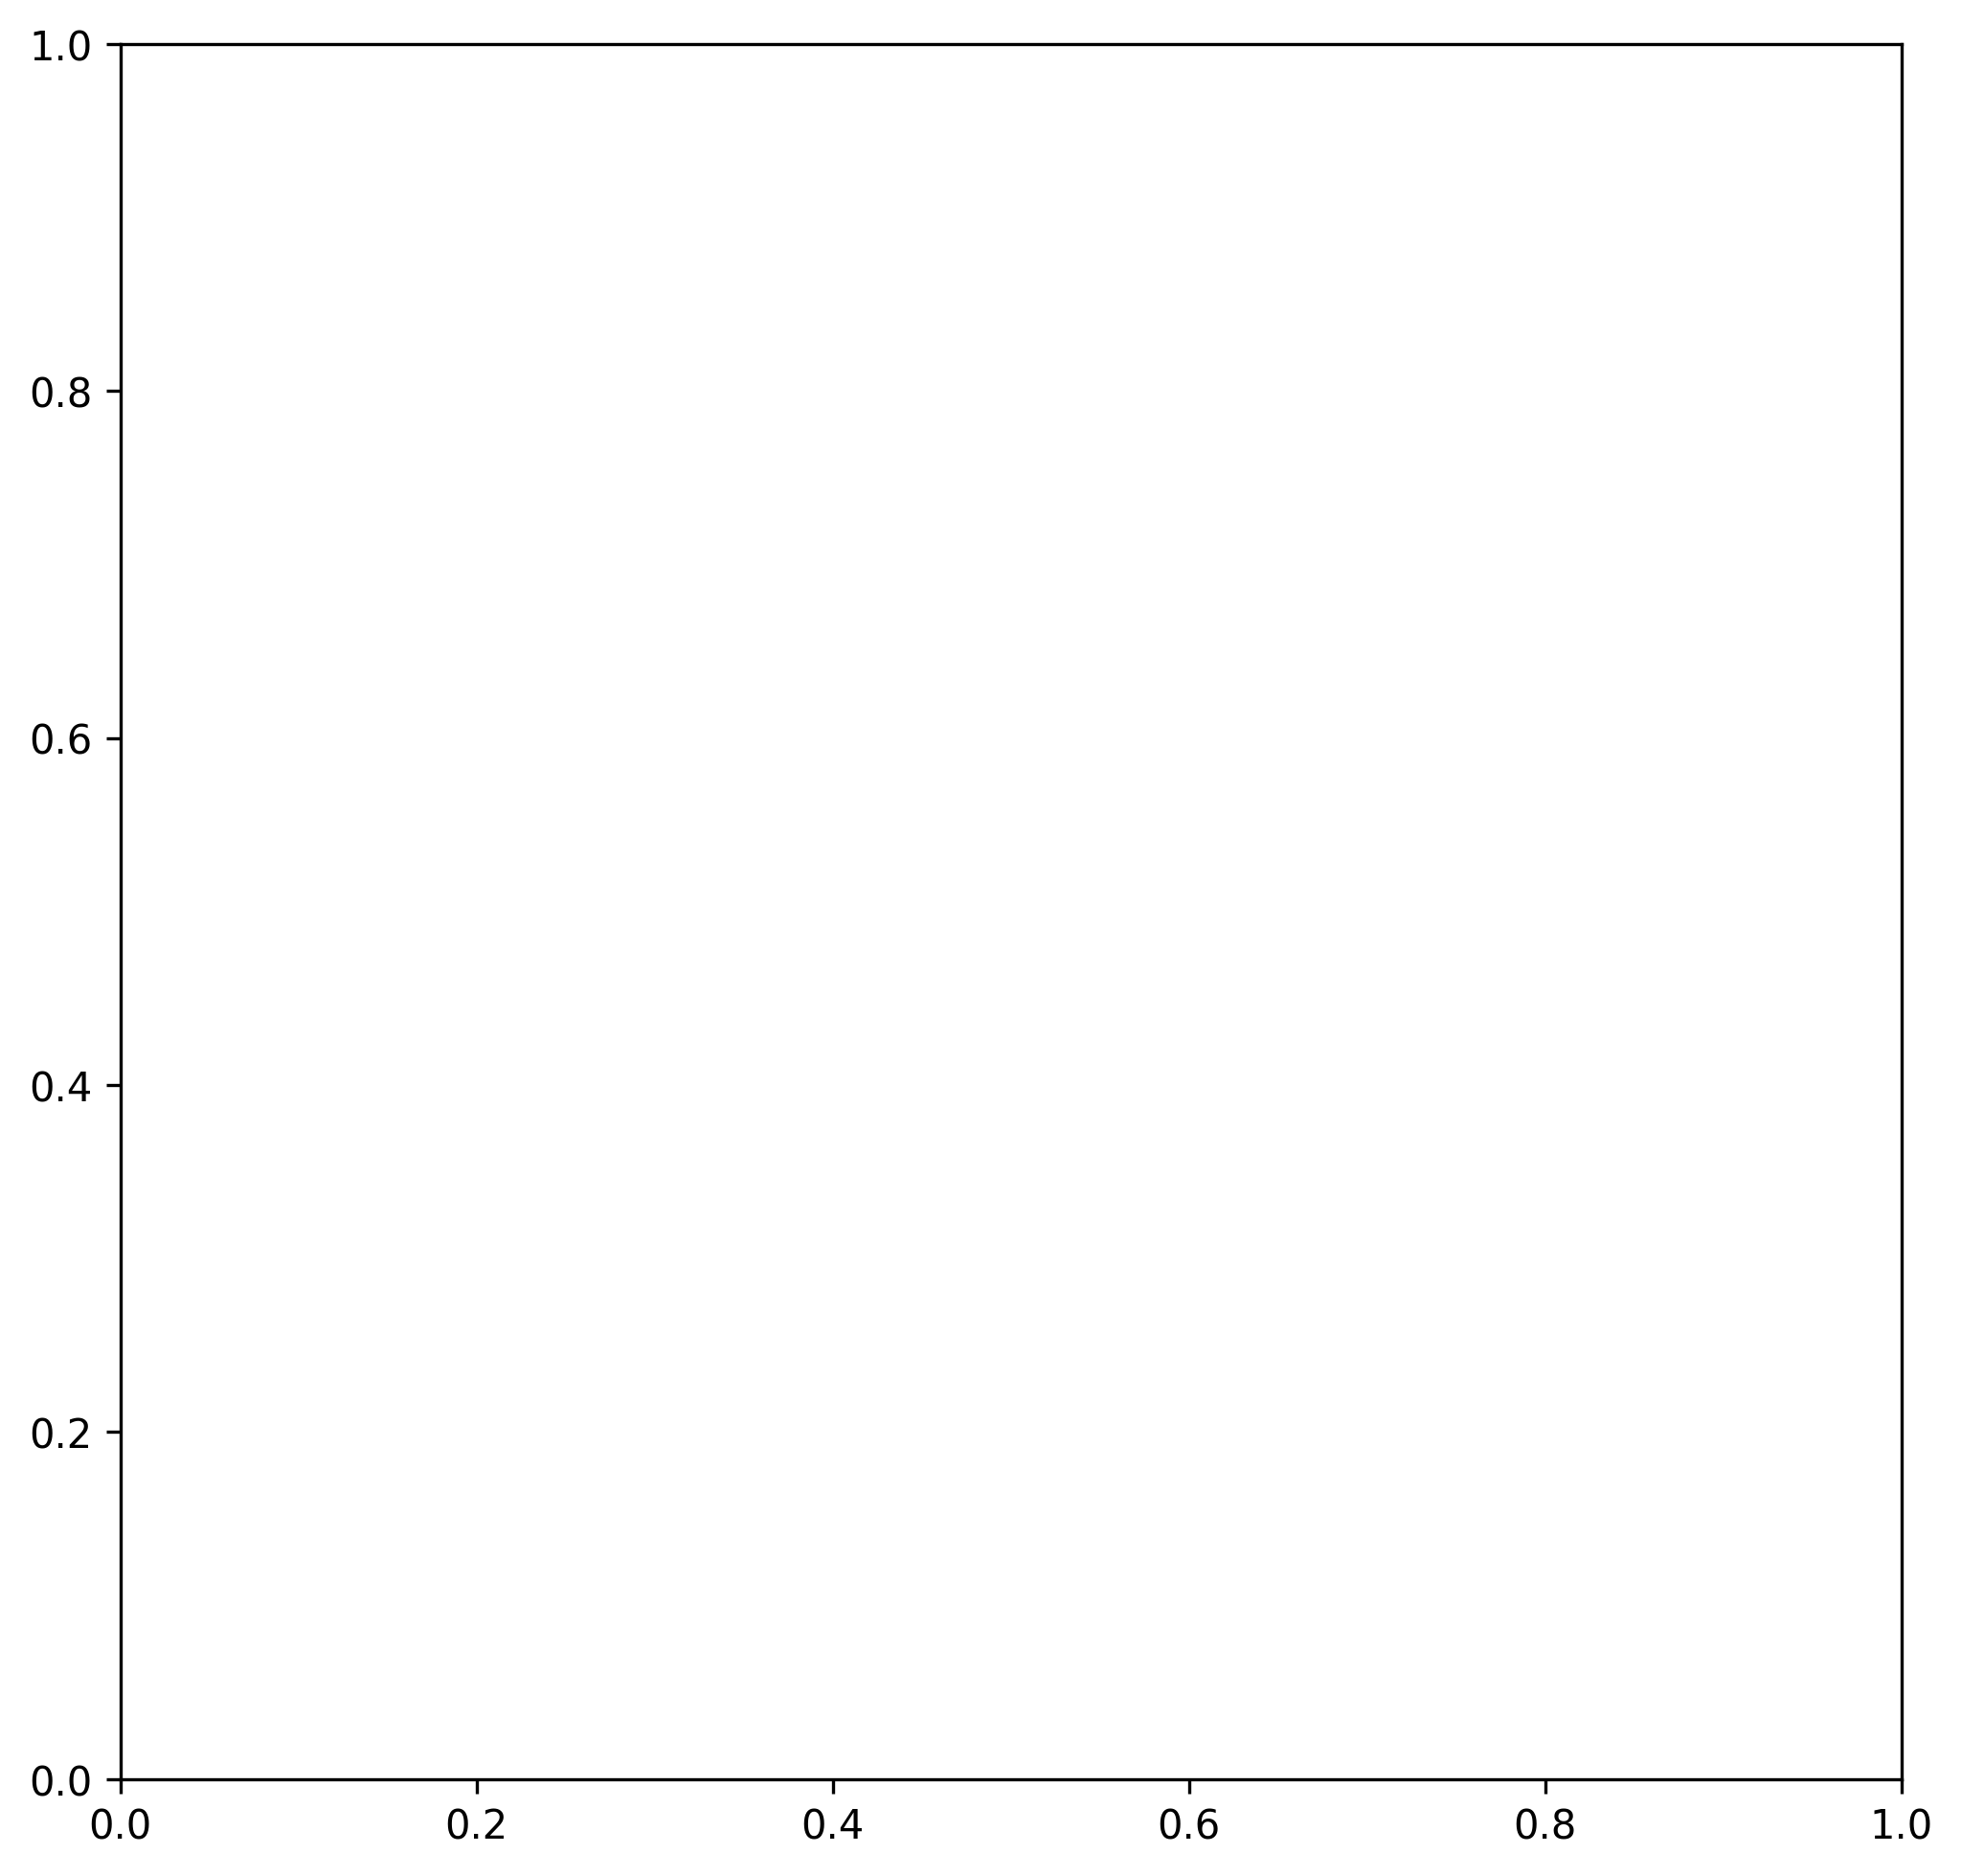

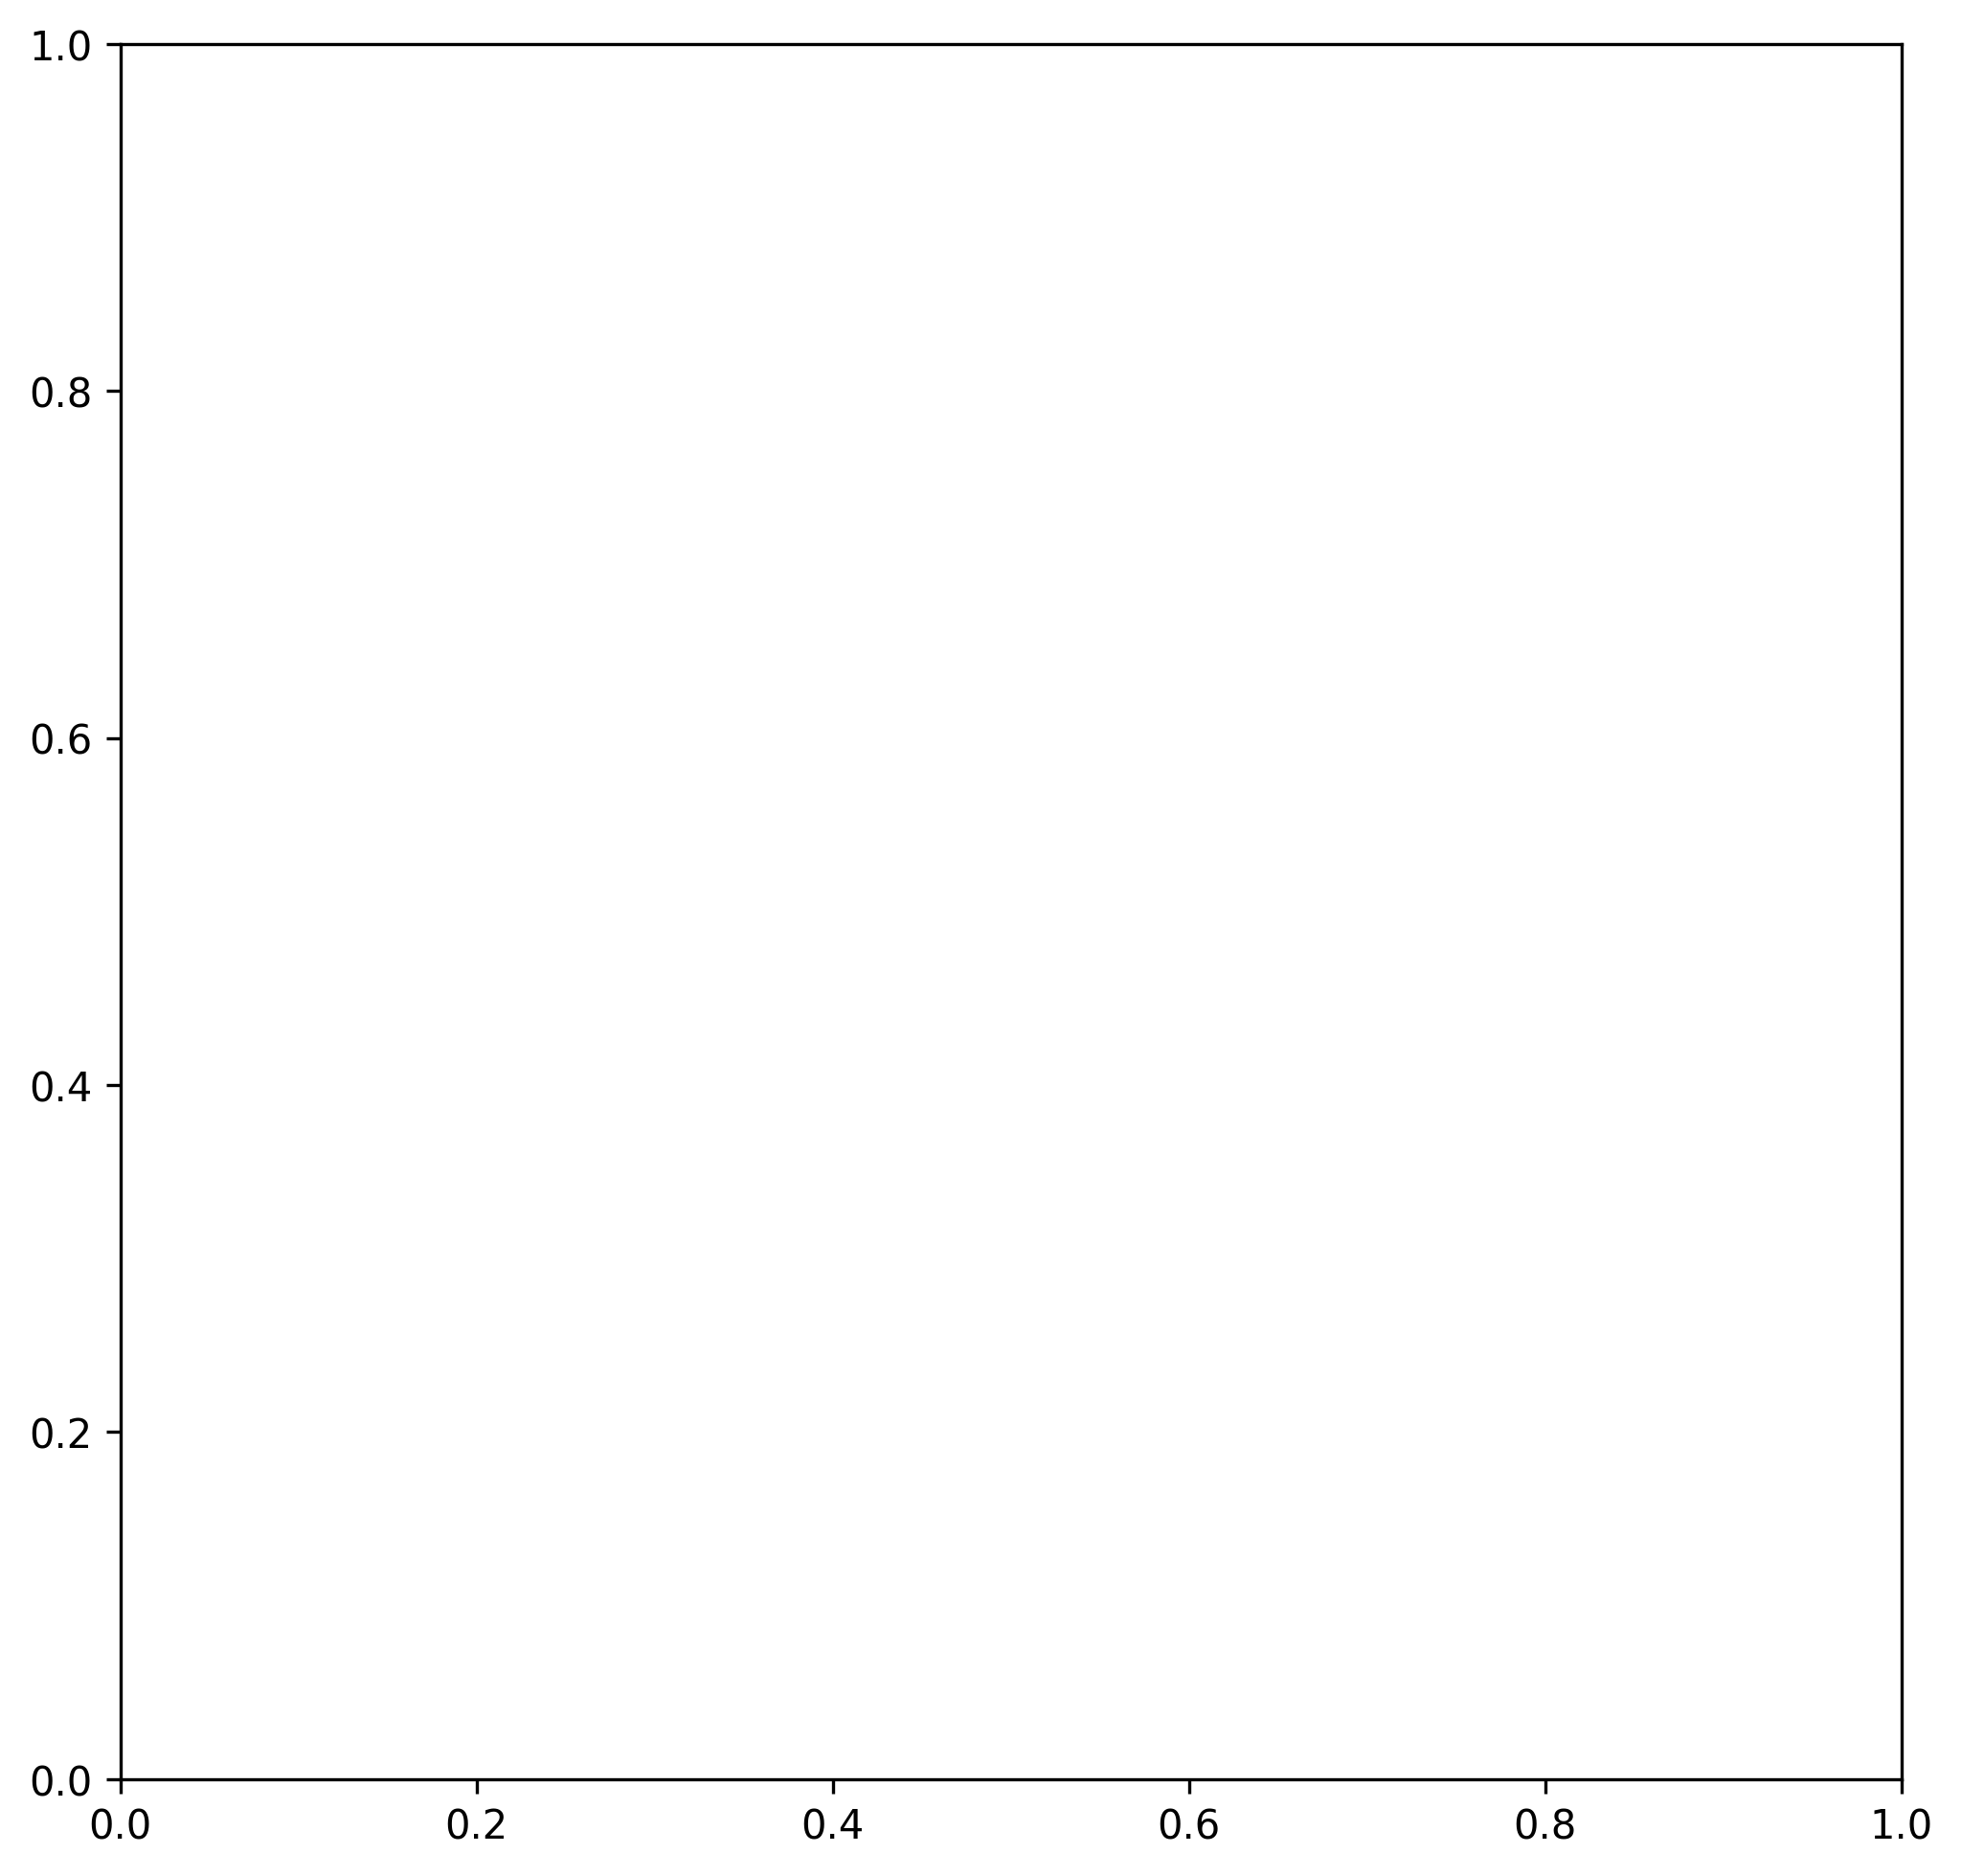

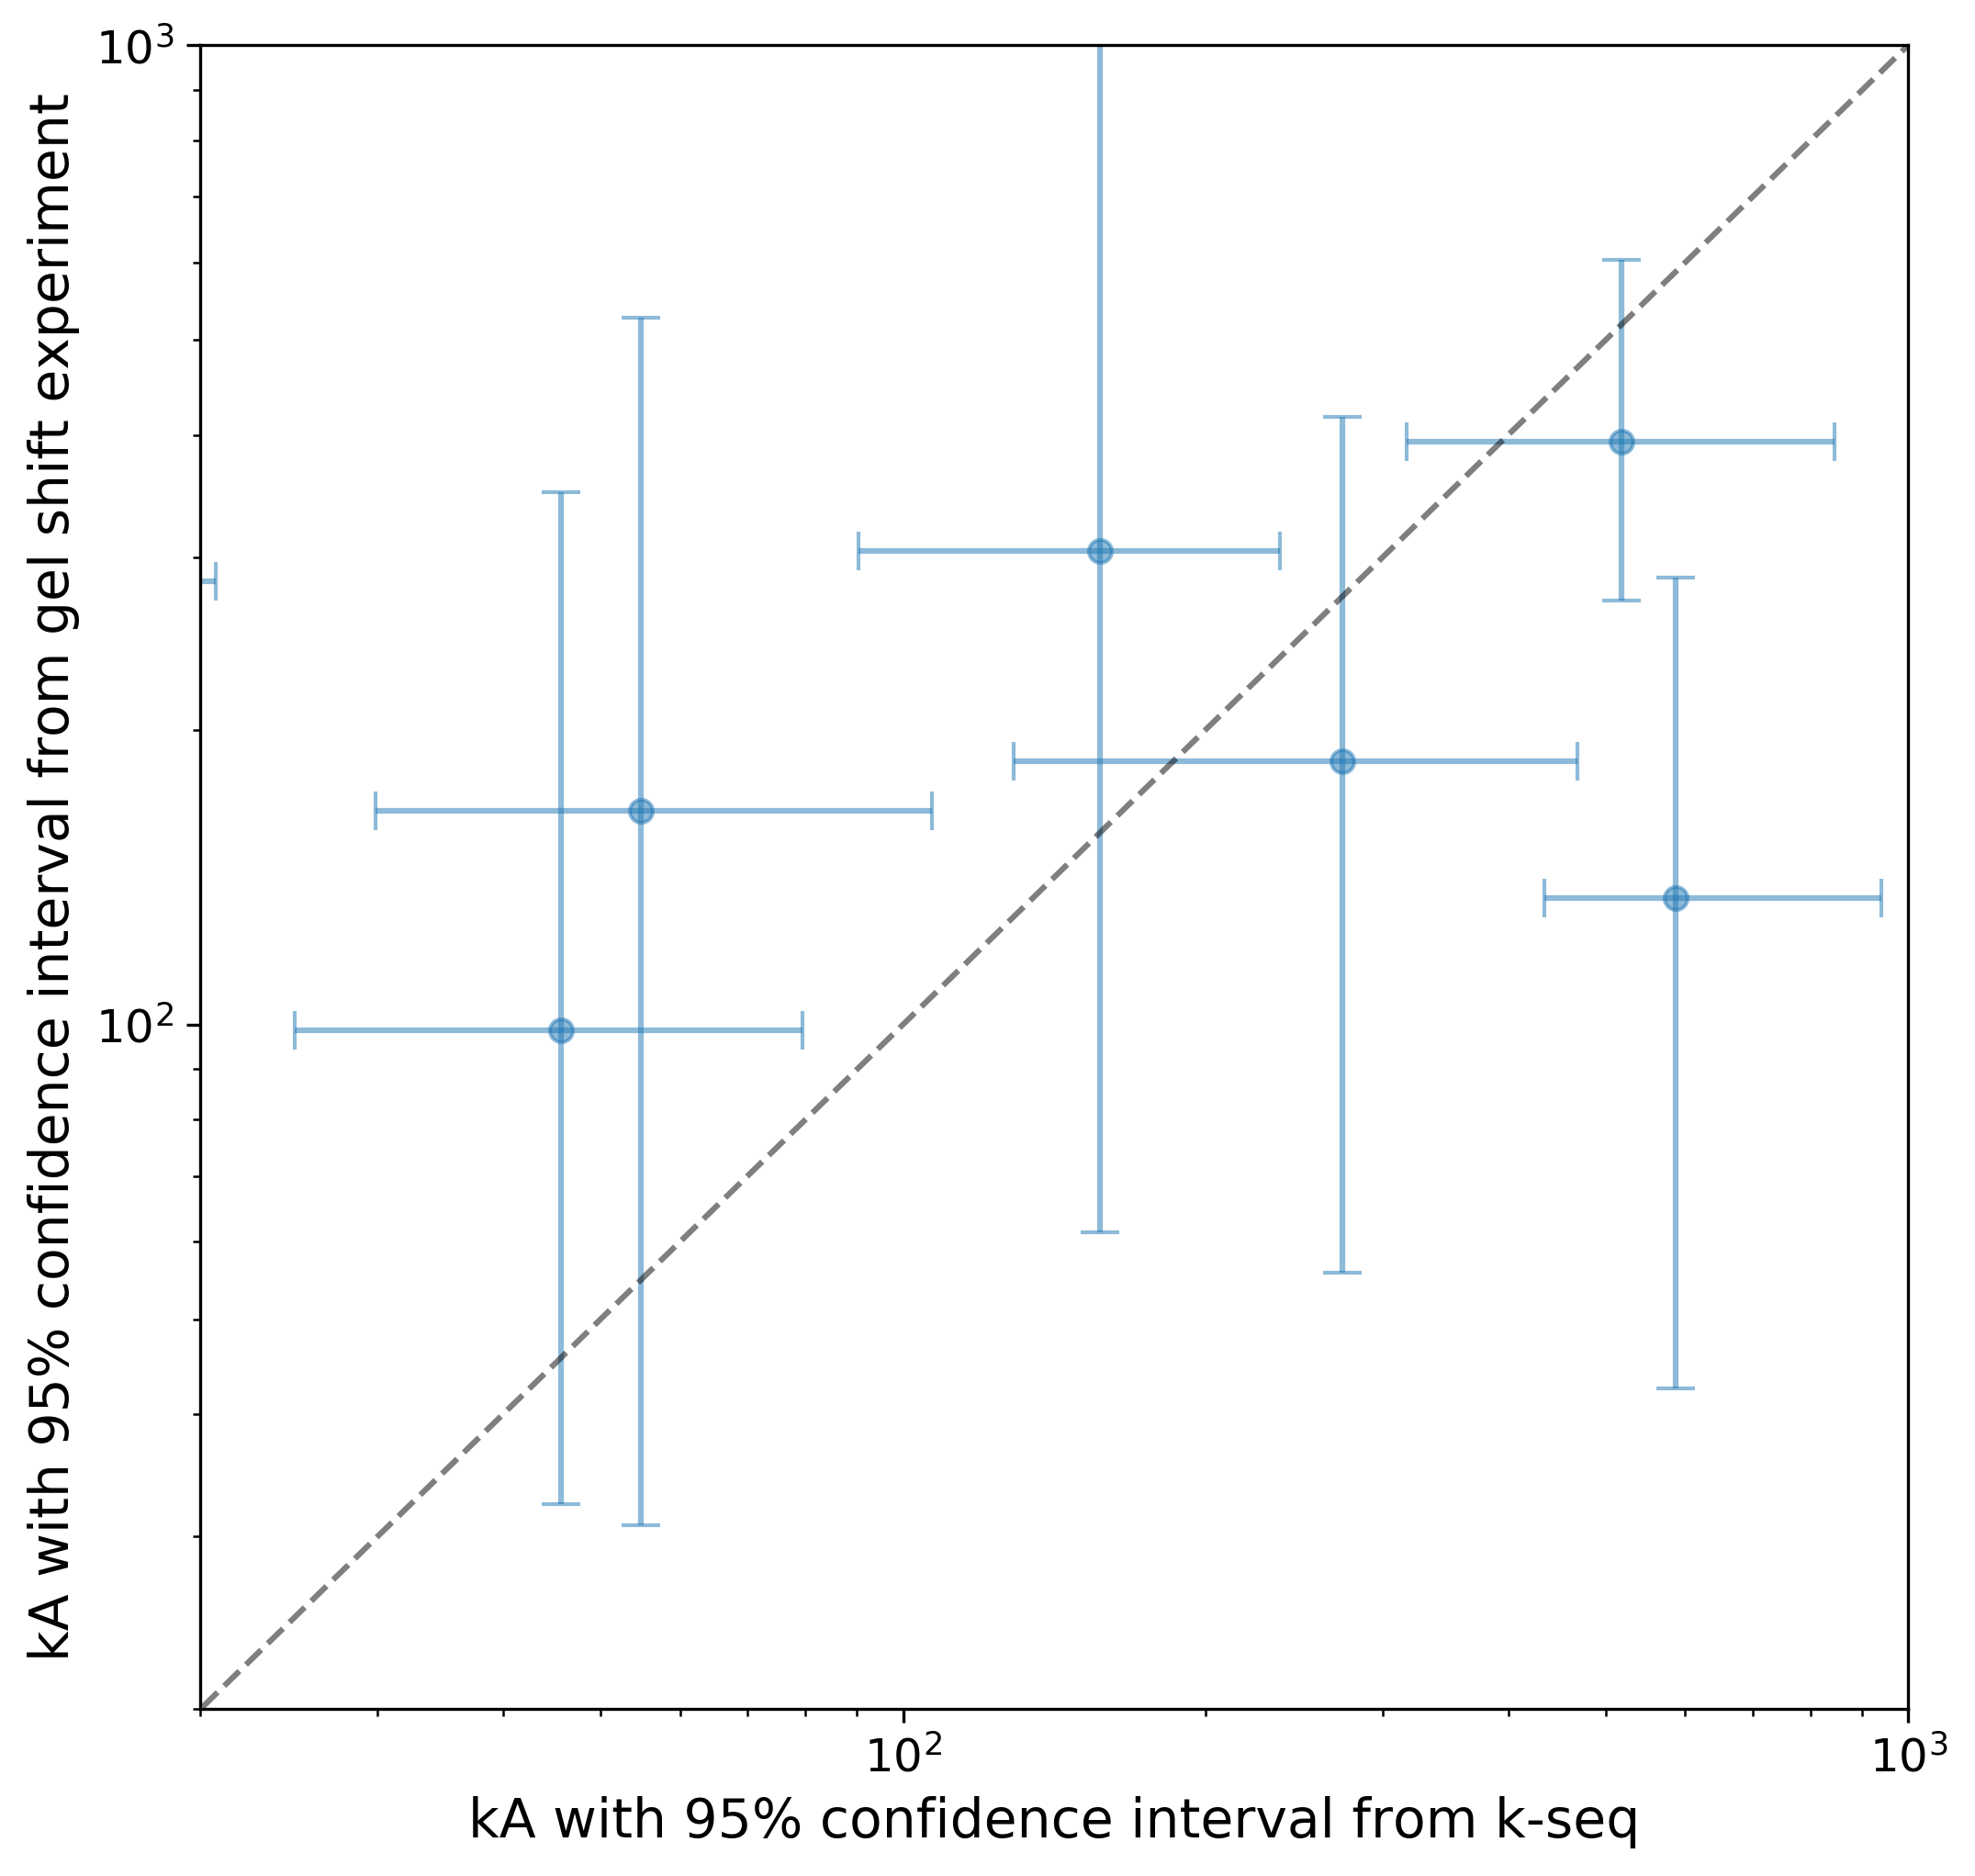

In [224]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=2
reskSeq = [selected_seq[seq]['k_seq_results']['ci95'][param][1] for seq in selected_seq.keys()]
reskSeq95 = [(selected_seq[seq]['k_seq_results']['ci95'][param][1] - selected_seq[seq]['k_seq_results']['ci95'][param][0], selected_seq[seq]['k_seq_results']['ci95'][param][2] - selected_seq[seq]['k_seq_results']['ci95'][param][1]) for seq in selected_seq.keys()]


resGel = [selected_seq[seq]['gel_shift_res']['percentiles']['50'][param] for seq in selected_seq.keys()]
resGel95 = [(selected_seq[seq]['gel_shift_res']['percentiles']['50'][param] - selected_seq[seq]['gel_shift_res']['percentiles']['2.5'][param], selected_seq[seq]['gel_shift_res']['percentiles']['97.5'][param] - selected_seq[seq]['gel_shift_res']['percentiles']['50'][param]) for seq in selected_seq.keys()]

ax.errorbar(x=reskSeq, y=resGel, xerr=np.array(reskSeq95).T, yerr=np.array(resGel95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)

ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)

plt.show()

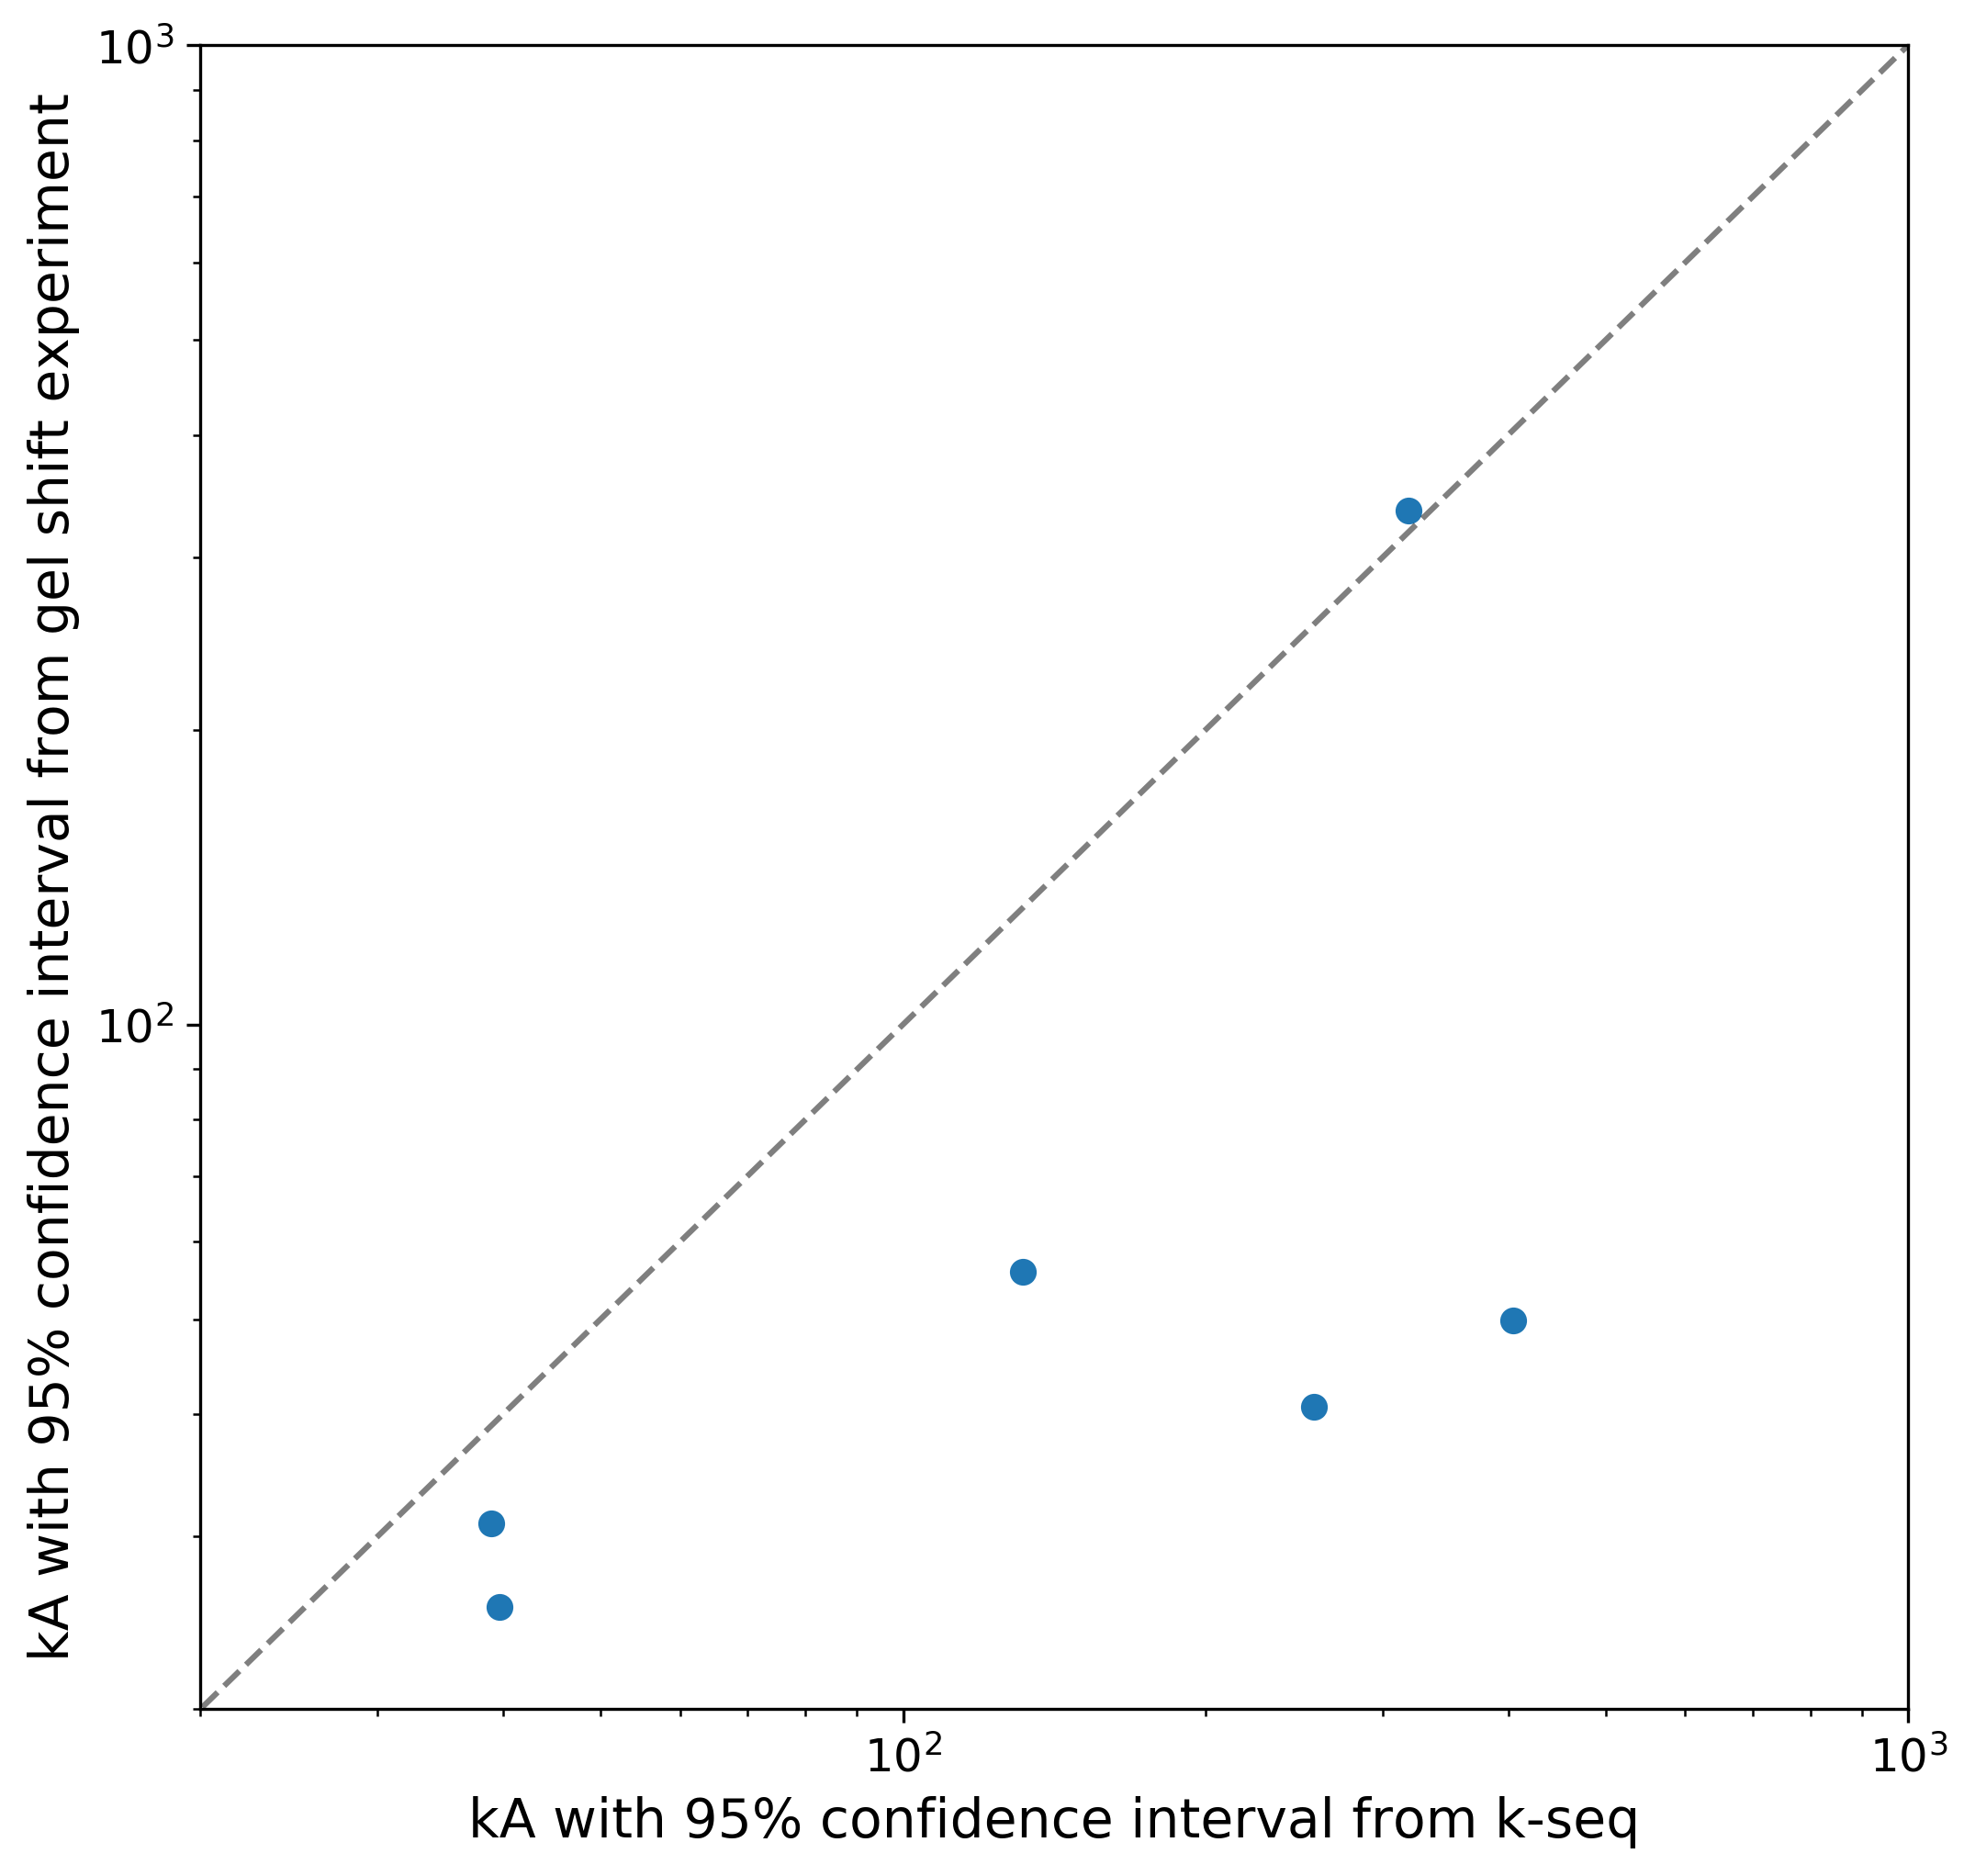

In [235]:
import plot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a * x + b


fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=2
x_k_seq = np.array([selected_seq[seq]['k_seq_results']['params'][param] for seq in selected_seq.keys()])
y_gel = np.array([selected_seq[seq]['gel_shift_res']['params'][param] for seq in selected_seq.keys()])

params, cov = curve_fit(linear_func, x_k_seq, y_gel)

y_hat = linear_func(x_k_seq, *params)
res = y_gel - y_hat
ss_res = np.sum(res ** 2)
ss_tot = np.sum((y_gel - np.mean(y_gel)) ** 2)
r2_0 = (1 - ss_res / ss_tot)


res = y_gel - x_k_seq
ss_res = np.sum(res ** 2)
ss_tot = np.sum((y_gel - np.mean(y_gel)) ** 2)
r2_1 = (1 - ss_res / ss_tot)

res = x_k_seq - y_gel
ss_res = np.sum(res ** 2)
ss_tot = np.sum((x_k_seq - np.mean(x_k_seq)) ** 2)
r2_2 = (1 - ss_res / ss_tot)


ax.scatter(x=x_k_seq, y=y_gel, marker='o')
plot.set_ticks_size(ax)

ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)



plt.show()

In [242]:
print(x_k_seq)
print(y_gel)

[318.12582175 404.83549281 131.56135188  38.91601611  39.64001181
 256.36330122   6.05323921]
[335.0400641   49.83563415  55.90053901  30.92180273  25.41991749
  40.72530348  61.26248913]


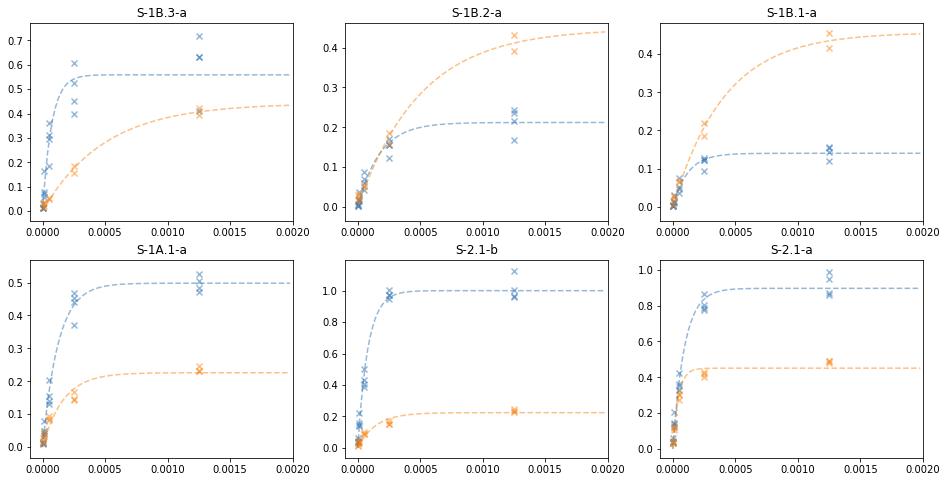

In [337]:
import matplotlib.pyplot as plt

def func(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x))

fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for ix, seqId in enumerate(seqFinished):
    ax = axes[int(ix/3), ix%3]
    ax.set_title(seqId, fontsize=12)
    ### Plot k-seq data
    x_data = [x_series for _ in range(len(selected_seq[seq]['gel_shift_data']))]
    x_data = np.reshape(a=x_data, newshape=np.size(x_data))
    y_data = np.reshape(
        a=selected_seq[seq]['gel_shift_data'],
        newshape=np.size(selected_seq[seq]['gel_shift_data'])
    )
    ax.scatter(xdata, ydata, marker='x', color='#2C73B4', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['kSeqRes']['params'][0], selectedSeq[seqId]['kSeqRes']['params'][1]), color='#2C73B4', ls='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.002])
    
    ### Plot gel data
    shape = np.shape(selectedSeq[seqId]['gelRaw'])
    xdata = np.tile(xValues[:-1], shape[0])
    ydata = np.reshape(selectedSeq[seqId]['gelRaw'][...,:-1], shape[0]*(shape[1]-1))
    ax.scatter(xdata, ydata, marker='x', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['gelRes']['params'][0], selectedSeq[seqId]['gelRes']['params'][1]), color='#FC820D', ls='--', alpha=0.5)

plt.show()

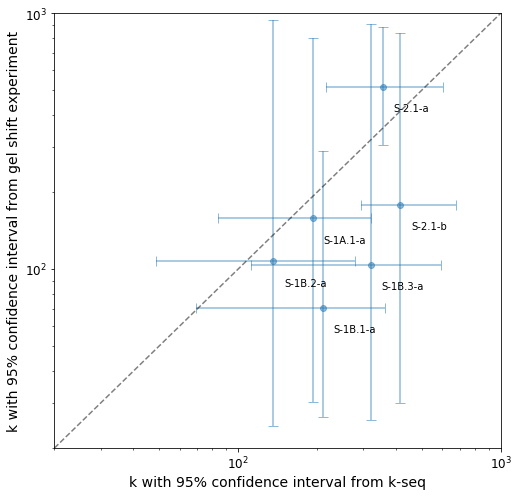

In [373]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=1
reskSeq = [selectedSeq[seqId]['kSeqRes']['ci95'][param][1] for seqId in seqFinished]
reskSeq95 = [(selectedSeq[seqId]['kSeqRes']['ci95'][param][1] - selectedSeq[seqId]['kSeqRes']['ci95'][param][0], selectedSeq[seqId]['kSeqRes']['ci95'][param][2] - selectedSeq[seqId]['kSeqRes']['ci95'][param][1]) for seqId in seqFinished]
resGel = [selectedSeq[seqId]['gelRes']['ci95'][param][1] for seqId in seqFinished]
resGel95 = [(selectedSeq[seqId]['gelRes']['ci95'][param][1] - selectedSeq[seqId]['gelRes']['ci95'][param][0], selectedSeq[seqId]['gelRes']['ci95'][param][2] - selectedSeq[seqId]['gelRes']['ci95'][param][1]) for seqId in seqFinished]
ax.errorbar(x=reskSeq, y=resGel, xerr=np.array(reskSeq95).T, yerr=np.array(resGel95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)

for seqId in seqFinished:
    ax.text(s=seqId, x=selectedSeq[seqId]['kSeqRes']['ci95'][param][1]*1.1, y=selectedSeq[seqId]['gelRes']['ci95'][param][1]*0.8)
ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)

plt.show()

# The rough error correction

In [27]:
import pandas as pd
seqRes = pd.read_csv('/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')
seqRes

seq  inputCountMedian       config  \
0                   AAAAACAAAAACAAA               151  [4 4 4 4 4]   
1              ATTACCCTGGTCATCGAGTT                 2  [4 4 4 4 4]   
2            CACCCCGCTTCAAGCAATCGGT                 1  [0 0 1 1 0]   
3             CCGCTCCAAACAATCGGTCTG                 1  [1 0 1 0 0]   
4                    AAAACAAAAACAAA                 4  [4 4 4 4 4]   
5                    AAAAACAAAAACAA                 1  [4 4 4 4 4]   
6              ATTCCCTGGTCATCGAGTGT                 2  [4 4 4 4 4]   
7             AAATTCAAAAACAAAAACAAA                 2  [4 3 4 4 4]   
8                          ATTACCCT                 1  [4 4 4 4 4]   
9             CCCCTTCAATAATCGGTCATG                 1  [1 0 1 0 0]   
10            CCTGGTTTCAAACAATCGGTC                 1  [1 1 1 0 0]   
11              ATTACCCTGGTCATCGAGT                 5  [4 4 4 4 4]   
12            CTACTCTTCAACCAATCGGTC                 1  [0 1 0 1 0]   
13             AAAAACAAACCAAAAACAAA                 1  [0 1 0 2 0]   
14            CTGTTTCAAACATTCGGTCTC                 1  [0 2 1 0 0]   
15            CTCATTTCAATAATCGCCTGC                 1  [1 0 1 0 0]   
16                        AAAAACAAA                 2  [4 4 4 4 4]   
17            ATTACCCCTGTCATCGAGTGA                 1  [4 4 4 4 4]   
18            CTGCTATCAATAATCGCCTGC                 1  [0 2 1 0 0]   
19                              GGT                 1  [0 1 2 0 0]   
20          ATTACCCTGGTCATCGAGTGTCA                 1  [4 4 4 4 4]   
21            CTCTACTTCAAACAATCGGTC                 1  [0 1 2 0 0]   
22                 AAAAAACAAAAACAAA                14  [4 4 4 4 4]   
23            CCCCTGCTTCAAGCAATCGGT                 1  [0 1 1 0 0]   
24            CCGGCTTCAAGCAATCGGTCT                 1  [0 1 1 0 0]   
25             ATTCCCTGGTCATCGAGTGA                 6  [4 4 4 4 4]   
26         ACCCCGCTTCAAGCAATCGGTCTG                 1  [1 1 0 0 0]   
27           CTACTTCAAAACAATCGGCCTG                 1  [0 1 1 0 0]   
28               ATTACCCTGGTCGAGTGT                13  [4 4 4 4 4]   
29            GCTCTTCAAACAATCGGTCTC                 1  [0 2 2 0 0]   
...                             ...               ...          ...   
9056          AACCCGCTTCAAGCAAACGGT                 1  [0 1 0 0 0]   
9057          AACAATTATTCCCCTACGTGA                 1  [0 0 1 0 0]   
9058          AAATGCTGGTCCTCCCTGTGA                 1  [0 0 0 1 0]   
9059          AAATAGCTTCAAGCAATCGGT                 1  [0 0 1 0 0]   
9060          AAAGTTGCCTTTCCCTCGTGA                 1  [0 1 0 0 0]   
9061          AAACTTCAAACAATCGGTCTG                 1  [0 0 0 0 1]   
9062          AAACCCGCTTTGCATGCGTGA                 1  [0 0 1 0 0]   
9063          AAACCACTTCAACAATCGGTC                 1  [1 0 0 0 0]   
9064                 AAACAGTCGGTCTG                 1  [0 1 0 0 0]   
9065      AAACAAAAAAAAAAACAAAAACAAA                 1  [0 1 0 0 0]   
9066         AAAACCCTGGTCATCGAGTGTT                 1  [0 0 1 0 0]   
9067            AAAACCAAACAAAAACAAA                 1  [0 0 1 0 0]   
9068         AAAACCAAAAACCAAAAACAAA                 1  [0 0 0 0 1]   
9069            AAAACAAAACAAAAAAAAA                 1  [0 0 0 0 1]   
9070         AAAAACCAAACACAAAAACAAA                 1  [0 0 1 0 0]   
9071           AAAAACCAAAAACAAACAAA                 1  [1 0 0 0 0]   
9072         AAAAACCAAAAACAAAAACGAA                 1  [1 0 0 0 0]   
9073          AAAAACAAACACGAAAACAAA                 1  [0 0 1 0 0]   
9074        AAAAACAAAACCAAAAAAACAAA                 1  [0 0 0 1 0]   
9075              AAAAACAAAAACAAAAC                 1  [1 0 0 0 0]   
9076    AAAAACAAAAACAAAAACAAAACCAAA                 1  [0 1 0 0 0]   
9077       AAAAACAAAAACAAAAAAAATAAA                 1  [0 0 1 0 0]   
9078      AAAAACAAAAAAAAAACAAAACAAA                 1  [0 0 0 0 1]   
9079              AAAAACAAAAAAAAAAA                 1  [0 1 0 0 0]   
9080          AAAAAAGAAAACAAAAACAAA                 1  [1 0 0 0 0]   
9081  AAAAAACAAAAAAAAAAAACAAAAACAAA       

limit_output extension: Maximum message size of 10000 exceeded with 31107 characters

In [ ]:
def seq_err_est_rough(seqList, pErrTotal, pErrLambda):
    """
    A rough method to estimate if a sequence can be possibly come from an error; If yes, label
    """
    
    def get_transition_probability(centerSeq, testSeq, pErrTotal, pErrLambda):
        import Levenshtein
        
        edits = Levenshtein.editops(centerSeq, testSeq)
        d1 = np.sum([1 for edit in edits if edit[0]=='replace'])
        d2 = len(edits) - d1
        return (1-pErrTotal)**len(centerSeq), (pErrLambda*pErrTotal/3)**d1*((1-pErrLambda)pErrTotal/2)**d2*(1-pErrTotal)**(len(centerSeq)-d1-d2)
    
    def test_end(seqList):
        while 
        for seq in seqList.iterrow():
            if pErrTotal**(len(seq['seq'])-1)(1-pErrTotal)*seq['inputCountMedian']:
                
        
        
    